# Проект 5. Flow Matching

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

Возьмем модель EDM

In [2]:
!git clone https://github.com/NVlabs/edm

Cloning into 'edm'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 54 (delta 13), reused 13 (delta 13), pack-reused 20 (from 1)
Receiving objects: 100% (54/54), 2.13 MiB | 5.21 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [3]:
import sys
sys.path.append('edm')
sys.path.append('edm/training/')
sys.path.append('edm/training/networks')

import pickle
from edm.dnnlib import util
#from torch_utils import misc

from edm.training.networks import EDMPrecond
from edm.training.loss import EDMLoss

## Работа с датасетом

Читаем датасет CIFAR-10, визуализируем

In [4]:
from torchvision import datasets, transforms
import torch

Изначально в блоке transform использовалим нормализацию и RandomHorizontalFLip. Результаты без этих аугментаций были даже немного лучше, а из-за низкого разрешения Cifar-10 при нормализации некоторые ключевые характеристики картинок терялись. Например, вот так:
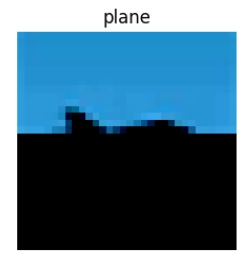

In [5]:
dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
           transforms.ToTensor(),
        #   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=10,
    drop_last=True,
)

100%|██████████| 170M/170M [00:05<00:00, 30.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


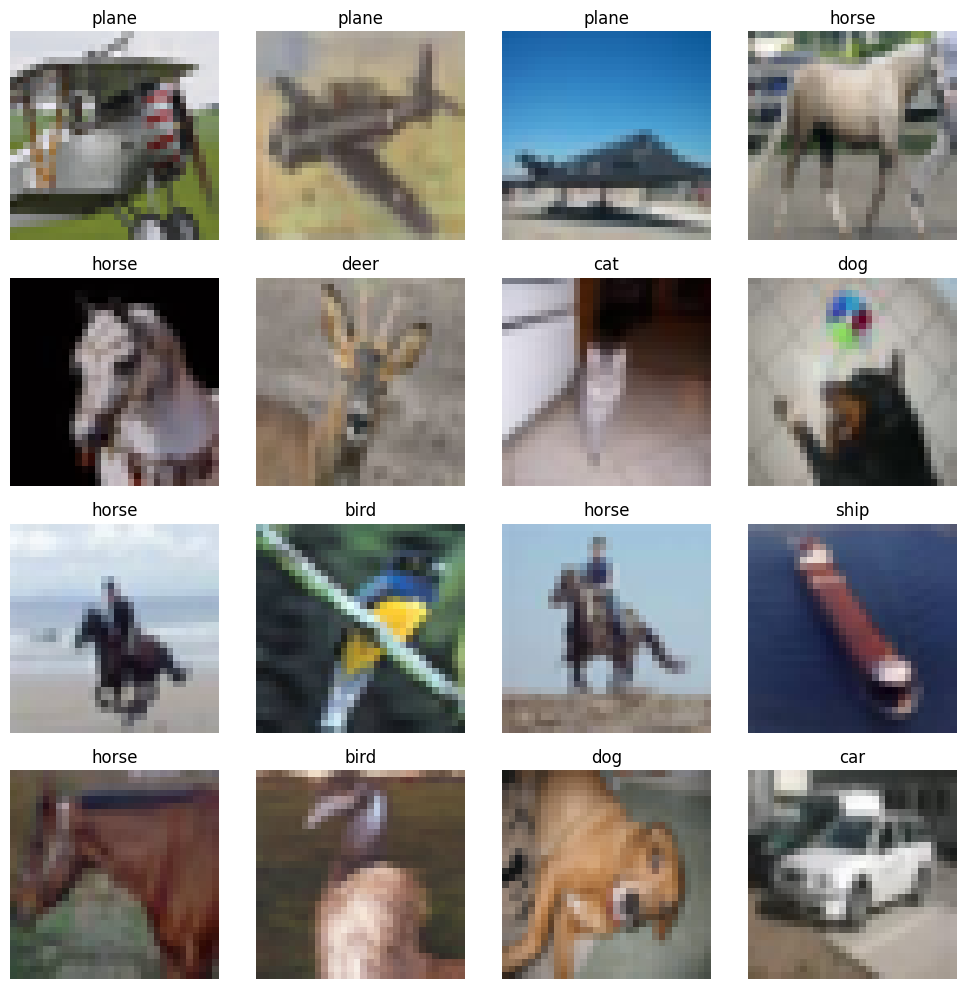

In [7]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

images, labels = next(iter(dataloader))

# CIFAR-10 classes
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()

for i in range(16):
    # Convert image tensor to NumPy array and rearrange dimensions
    img = images[i].permute(1, 2, 0).numpy()

    # Plot the image
    axes[i].imshow(img)
    axes[i].set_title(classes[labels[i]])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

В качестве оптимизатора взяли стандартный Адам. В оригинальной статье его используют без параметра weight_decay, но мы решили его взять, чтобы справиться с взрывающимся градиентом. Без него так же пробовали запускать CFM, вот результат MSE лосса : 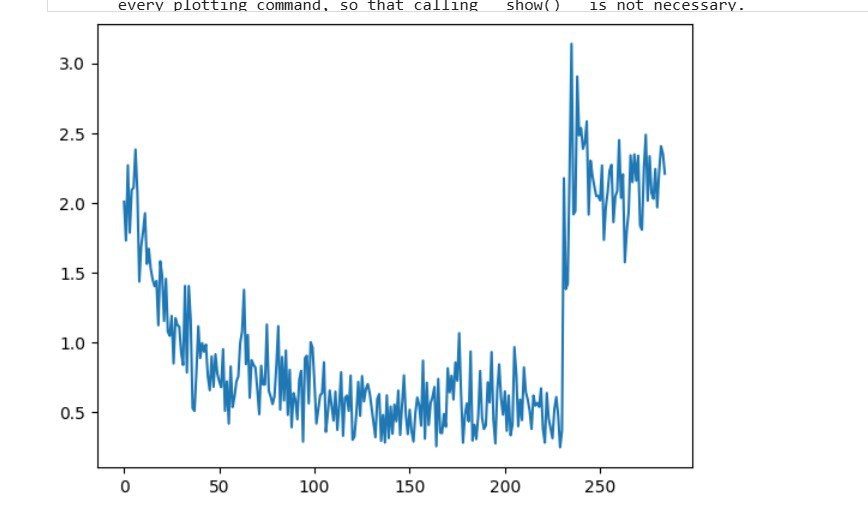

In [8]:
net = EDMPrecond(img_resolution=32,img_channels=3, label_dim=10).to('cuda')
opt = torch.optim.Adam(net.parameters(), lr=5e-4, weight_decay=0.001)
#opt = torch.optim.Adam(net.parameters(), lr=5e-4)
print(f'Network has {sum(p.numel() for p in net.parameters())} parameters')

Network has 279631875 parameters


После борьбы с взрывающимся градиентом стало понятно, что нужно уменьшать дисперсию лосса. Для этого решили воспользоваться Exponential Moving Average

In [9]:
import torch

class EMA_class:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.ema_model = self._clone_model(model)
        self.ema_model.eval()

    def _clone_model(self, model):
        ema_model = type(model)(img_resolution=32,img_channels=3, label_dim=10)
        ema_model.load_state_dict(model.state_dict())
        for param in ema_model.parameters():
            param.requires_grad_(False)
        return ema_model

    def update(self):
        with torch.no_grad():
            for ema_param, model_param in zip(self.ema_model.parameters(), self.model.parameters()):
                ema_param.data = self.decay * ema_param.data + (1.0 - self.decay) * model_param.data

    def to(self, device):
        self.ema_model.to(device)
        return self

    def state_dict(self):
        return self.ema_model.state_dict()

    def load_state_dict(self, state_dict):
        self.ema_model.load_state_dict(state_dict)

Значения лосса логировали через список

In [10]:
history=[]

Алгоритм Conditional Flow Matching. Использовали реализацию из 8 семинара + статью

In [11]:
# CFM
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_

# параметры ema из статьи
ema = EMA_class(net, decay=0.999)
ema.to('cuda')

def training_loop(net, opt, dataloader, num_epochs=10000):
    net.train()
    pbar = tqdm(range(num_epochs))
    for i in pbar:
        opt.zero_grad()
        data = next(iter(dataloader))
        x_1 = data[0].to('cuda')
        y = data[1].to('cpu')
        x_0 = torch.randn_like(x_1).to('cuda')
        batch_size = x_0.shape[0]

        # сэпмлим рандомно от 0 до 1
        t = torch.rand(batch_size, device=x_0.device)
        t = t.reshape(-1, *([1] * (x_0.dim() - 1)))
     #  print(t)
        x_t = x_0 + (x_1 - x_0) * t
        new_labels = torch.eye(10)[y]
    #    print(x_t.shape, t.shape, y.shape)
        f_x_t = net(x_t, t, class_labels=new_labels.to('cuda'))
        loss = ((f_x_t - (x_1 - x_0)) ** 2).mean()

        loss.backward()
        clip_grad_norm_(net.parameters(), max_norm=1.0)
        opt.step()
        pbar.set_description(f'Loss: {loss.item()}')
        if loss.item() > 2:
     #     print("!!!!!")
        history.append(loss.item())

        ema.update()
        with torch.no_grad():
            ema_x_t = ema.ema_model(x_t, t, class_labels=new_labels.to('cuda'))
            ema_loss = ((ema_x_t - (x_1 - x_0)) ** 2).mean()
            #логгируем лоссы EMA
            ema_model_losses.append(ema_loss.item())

In [13]:
history=[]
ema_model_losses=[]
#num_iters = 1000
training_loop(net, opt, dataloader, num_epochs=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 2.013185501098633:   0%|          | 0/3000 [00:03<?, ?it/s]

!!!!!


Loss: 2.013185501098633:   0%|          | 1/3000 [00:03<3:14:36,  3.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 2.029771327972412:   0%|          | 1/3000 [00:05<3:14:36,  3.89s/it]

!!!!!


Loss: 2.029771327972412:   0%|          | 2/3000 [00:06<2:22:11,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 2.1487302780151367:   0%|          | 2/3000 [00:07<2:22:11,  2.85s/it]

!!!!!


Loss: 2.1487302780151367:   0%|          | 3/3000 [00:08<2:07:06,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 2.15915584564209:   0%|          | 3/3000 [00:09<2:07:06,  2.54s/it]  

!!!!!


Loss: 2.15915584564209:   0%|          | 4/3000 [00:10<1:59:34,  2.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.8648594617843628:   0%|          | 5/3000 [00:12<1:55:47,  2.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 2.137943744659424:   0%|          | 5/3000 [00:14<1:55:47,  2.32s/it] 

!!!!!


Loss: 2.137943744659424:   0%|          | 6/3000 [00:15<1:58:35,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.822554349899292:   0%|          | 7/3000 [00:17<1:54:59,  2.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 2.101433277130127:   0%|          | 7/3000 [00:18<1:54:59,  2.31s/it]

!!!!!


Loss: 2.101433277130127:   0%|          | 8/3000 [00:19<1:52:59,  2.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.9802364110946655:   0%|          | 9/3000 [00:21<1:51:00,  2.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.9805896282196045:   0%|          | 10/3000 [00:23<1:49:51,  2.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.703627109527588:   0%|          | 11/3000 [00:26<1:54:28,  2.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 2.0088093280792236:   0%|          | 11/3000 [00:27<1:54:28,  2.30s/it]

!!!!!


Loss: 2.0088093280792236:   0%|          | 12/3000 [00:28<1:52:45,  2.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.7712793350219727:   0%|          | 13/3000 [00:30<1:51:49,  2.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.7421963214874268:   0%|          | 14/3000 [00:32<1:50:15,  2.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.8985767364501953:   0%|          | 15/3000 [00:34<1:49:09,  2.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.3179943561553955:   1%|          | 16/3000 [00:37<1:48:42,  2.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.7079179286956787:   1%|          | 17/3000 [00:39<1:53:40,  2.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.4490127563476562:   1%|          | 18/3000 [00:41<1:52:07,  2.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.5066499710083008:   1%|          | 19/3000 [00:43<1:51:00,  2.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.4820115566253662:   1%|          | 20/3000 [00:46<1:49:55,  2.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.4946368932724:   1%|          | 21/3000 [00:48<1:49:30,  2.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.4406681060791016:   1%|          | 22/3000 [00:50<1:54:37,  2.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.194934368133545:   1%|          | 23/3000 [00:52<1:52:33,  2.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.4801815748214722:   1%|          | 24/3000 [00:55<1:50:59,  2.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.38140869140625:   1%|          | 25/3000 [00:57<1:55:28,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.6301777362823486:   1%|          | 26/3000 [00:59<1:53:57,  2.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.033076524734497:   1%|          | 27/3000 [01:02<1:53:41,  2.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.2726283073425293:   1%|          | 28/3000 [01:04<1:55:12,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.0849902629852295:   1%|          | 29/3000 [01:06<1:52:41,  2.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.267608642578125:   1%|          | 30/3000 [01:08<1:51:37,  2.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.0895769596099854:   1%|          | 31/3000 [01:11<1:50:29,  2.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.955428957939148:   1%|          | 32/3000 [01:13<1:50:38,  2.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.3385601043701172:   1%|          | 33/3000 [01:15<1:55:24,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.1120928525924683:   1%|          | 34/3000 [01:18<1:53:30,  2.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.1612948179244995:   1%|          | 35/3000 [01:20<1:52:21,  2.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.0777443647384644:   1%|          | 36/3000 [01:22<1:51:37,  2.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7535433173179626:   1%|          | 37/3000 [01:24<1:50:56,  2.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8468044996261597:   1%|▏         | 38/3000 [01:27<1:50:31,  2.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.1173858642578125:   1%|▏         | 39/3000 [01:29<1:54:25,  2.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8436129093170166:   1%|▏         | 40/3000 [01:31<1:52:45,  2.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.016168475151062:   1%|▏         | 41/3000 [01:33<1:51:43,  2.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.0350532531738281:   1%|▏         | 42/3000 [01:36<1:51:41,  2.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.0089221000671387:   1%|▏         | 43/3000 [01:38<1:50:57,  2.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8231147527694702:   1%|▏         | 44/3000 [01:41<1:55:50,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8897432088851929:   2%|▏         | 45/3000 [01:43<1:53:54,  2.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.9682717323303223:   2%|▏         | 46/3000 [01:45<1:52:40,  2.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8524540662765503:   2%|▏         | 47/3000 [01:47<1:52:18,  2.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8187209963798523:   2%|▏         | 48/3000 [01:49<1:51:05,  2.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6621130108833313:   2%|▏         | 49/3000 [01:52<1:53:08,  2.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.782246470451355:   2%|▏         | 50/3000 [01:54<1:53:53,  2.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.1004350185394287:   2%|▏         | 51/3000 [01:56<1:52:16,  2.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.1284890174865723:   2%|▏         | 52/3000 [01:59<1:51:20,  2.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8752251863479614:   2%|▏         | 53/3000 [02:01<1:50:28,  2.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8945647478103638:   2%|▏         | 54/3000 [02:03<1:50:09,  2.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8180667161941528:   2%|▏         | 55/3000 [02:06<1:54:59,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6296428442001343:   2%|▏         | 56/3000 [02:08<1:53:01,  2.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6893213987350464:   2%|▏         | 57/3000 [02:10<1:51:30,  2.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4462014138698578:   2%|▏         | 58/3000 [02:12<1:51:04,  2.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6977533102035522:   2%|▏         | 59/3000 [02:15<1:50:39,  2.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7654118537902832:   2%|▏         | 60/3000 [02:17<1:56:12,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7088836431503296:   2%|▏         | 61/3000 [02:19<1:54:24,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6389936208724976:   2%|▏         | 62/3000 [02:22<1:52:52,  2.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7354130744934082:   2%|▏         | 63/3000 [02:24<1:52:40,  2.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3433060646057129:   2%|▏         | 64/3000 [02:26<1:51:53,  2.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8528100252151489:   2%|▏         | 65/3000 [02:29<1:51:39,  2.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6849448084831238:   2%|▏         | 66/3000 [02:31<1:55:58,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8328911662101746:   2%|▏         | 67/3000 [02:33<1:54:01,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.9773389101028442:   2%|▏         | 68/3000 [02:36<1:52:29,  2.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6684610247612:   2%|▏         | 69/3000 [02:38<1:52:12,  2.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5669988393783569:   2%|▏         | 70/3000 [02:40<1:51:20,  2.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8139157295227051:   2%|▏         | 71/3000 [02:43<1:55:55,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4804065227508545:   2%|▏         | 72/3000 [02:45<1:54:04,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4960194528102875:   2%|▏         | 73/3000 [02:47<1:52:36,  2.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.9780405759811401:   2%|▏         | 74/3000 [02:49<1:51:42,  2.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8933396339416504:   2%|▎         | 75/3000 [02:52<1:55:33,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7906240224838257:   3%|▎         | 76/3000 [02:55<1:59:29,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6013519763946533:   3%|▎         | 77/3000 [02:57<1:56:31,  2.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6682748794555664:   3%|▎         | 78/3000 [02:59<1:54:45,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4724844694137573:   3%|▎         | 79/3000 [03:01<1:53:20,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.9800702333450317:   3%|▎         | 80/3000 [03:04<1:52:36,  2.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6146949529647827:   3%|▎         | 81/3000 [03:06<1:53:37,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7033284902572632:   3%|▎         | 82/3000 [03:08<1:54:29,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.564012885093689:   3%|▎         | 83/3000 [03:11<1:53:10,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8407379984855652:   3%|▎         | 84/3000 [03:13<1:52:25,  2.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7780945301055908:   3%|▎         | 85/3000 [03:15<1:51:23,  2.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5977299213409424:   3%|▎         | 86/3000 [03:18<1:51:16,  2.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6184512972831726:   3%|▎         | 87/3000 [03:20<1:55:24,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6112382411956787:   3%|▎         | 88/3000 [03:22<1:53:54,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7455841302871704:   3%|▎         | 89/3000 [03:25<1:53:05,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41892847418785095:   3%|▎         | 90/3000 [03:27<1:52:25,  2.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6643325090408325:   3%|▎         | 91/3000 [03:29<1:51:58,  2.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6538712978363037:   3%|▎         | 92/3000 [03:32<1:56:31,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5573682188987732:   3%|▎         | 93/3000 [03:34<1:54:32,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5947614908218384:   3%|▎         | 94/3000 [03:36<1:53:38,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 1.0555155277252197:   3%|▎         | 95/3000 [03:39<1:52:36,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8703997135162354:   3%|▎         | 96/3000 [03:41<1:51:41,  2.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.48722052574157715:   3%|▎         | 97/3000 [03:44<1:56:43,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.75726318359375:   3%|▎         | 98/3000 [03:46<1:55:32,  2.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7570414543151855:   3%|▎         | 99/3000 [03:48<1:53:36,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5639512538909912:   3%|▎         | 100/3000 [03:51<1:52:14,  2.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6486884951591492:   3%|▎         | 101/3000 [03:53<1:51:36,  2.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5055190324783325:   3%|▎         | 102/3000 [03:55<1:52:15,  2.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6291729211807251:   3%|▎         | 103/3000 [03:58<1:56:52,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7922389507293701:   3%|▎         | 104/3000 [04:00<1:54:52,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5589019656181335:   4%|▎         | 105/3000 [04:02<1:51:06,  2.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.9211711883544922:   4%|▎         | 106/3000 [04:05<1:51:05,  2.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.9060977697372437:   4%|▎         | 107/3000 [04:07<1:50:54,  2.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5171749591827393:   4%|▎         | 108/3000 [04:09<1:54:46,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7043598890304565:   4%|▎         | 109/3000 [04:12<1:53:44,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4022778868675232:   4%|▎         | 110/3000 [04:14<1:52:27,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6951289176940918:   4%|▎         | 111/3000 [04:16<1:52:25,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3837204575538635:   4%|▎         | 112/3000 [04:19<1:51:39,  2.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5186728835105896:   4%|▍         | 113/3000 [04:21<1:56:47,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31688570976257324:   4%|▍         | 114/3000 [04:24<1:54:21,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5421711206436157:   4%|▍         | 115/3000 [04:26<1:53:08,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6110286712646484:   4%|▍         | 116/3000 [04:28<1:52:22,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7652602195739746:   4%|▍         | 117/3000 [04:30<1:51:25,  2.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41670045256614685:   4%|▍         | 118/3000 [04:33<1:51:50,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5742184519767761:   4%|▍         | 119/3000 [04:35<1:54:48,  2.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5048193335533142:   4%|▍         | 120/3000 [04:38<1:53:12,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8838376998901367:   4%|▍         | 121/3000 [04:40<1:52:01,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.626768946647644:   4%|▍         | 122/3000 [04:42<1:50:43,  2.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5877818465232849:   4%|▍         | 123/3000 [04:45<1:54:57,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5213463306427002:   4%|▍         | 124/3000 [04:48<2:01:07,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6896841526031494:   4%|▍         | 125/3000 [04:50<1:58:01,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.608173131942749:   4%|▍         | 126/3000 [04:52<1:55:22,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6215574145317078:   4%|▍         | 127/3000 [04:54<1:53:48,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8071708679199219:   4%|▍         | 128/3000 [04:57<1:52:39,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3804996907711029:   4%|▍         | 129/3000 [04:59<1:55:27,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3715657591819763:   4%|▍         | 130/3000 [05:02<1:54:00,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6068001985549927:   4%|▍         | 131/3000 [05:04<1:52:38,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7100583910942078:   4%|▍         | 132/3000 [05:06<1:51:55,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5349900126457214:   4%|▍         | 133/3000 [05:09<1:51:35,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7315296530723572:   4%|▍         | 134/3000 [05:11<1:51:09,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39741143584251404:   4%|▍         | 135/3000 [05:13<1:54:44,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5639621019363403:   5%|▍         | 136/3000 [05:16<1:53:41,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3260602355003357:   5%|▍         | 137/3000 [05:18<1:52:26,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30238109827041626:   5%|▍         | 138/3000 [05:20<1:51:08,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5080069303512573:   5%|▍         | 139/3000 [05:23<1:50:43,  2.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6732147932052612:   5%|▍         | 140/3000 [05:25<1:54:48,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6781196594238281:   5%|▍         | 141/3000 [05:28<1:53:14,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30517610907554626:   5%|▍         | 142/3000 [05:30<1:51:36,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2566775977611542:   5%|▍         | 143/3000 [05:32<1:50:54,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7957032918930054:   5%|▍         | 144/3000 [05:34<1:50:12,  2.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2963443398475647:   5%|▍         | 145/3000 [05:37<1:56:32,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.613490641117096:   5%|▍         | 146/3000 [05:39<1:54:22,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7034963369369507:   5%|▍         | 147/3000 [05:42<1:52:58,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3058084547519684:   5%|▍         | 148/3000 [05:44<1:51:51,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5021089315414429:   5%|▍         | 149/3000 [05:46<1:51:04,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5927778482437134:   5%|▌         | 150/3000 [05:49<1:55:30,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6078386306762695:   5%|▌         | 151/3000 [05:51<1:53:57,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.45226383209228516:   5%|▌         | 152/3000 [05:54<1:52:21,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8242735862731934:   5%|▌         | 153/3000 [05:56<1:50:59,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.47398144006729126:   5%|▌         | 154/3000 [05:58<1:50:15,  2.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5697192549705505:   5%|▌         | 155/3000 [06:01<1:51:42,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36602625250816345:   5%|▌         | 156/3000 [06:03<1:54:46,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.45593714714050293:   5%|▌         | 157/3000 [06:06<1:53:13,  2.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.449880450963974:   5%|▌         | 158/3000 [06:08<1:52:10,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.45178914070129395:   5%|▌         | 159/3000 [06:10<1:51:09,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.760713517665863:   5%|▌         | 160/3000 [06:12<1:50:18,  2.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41083431243896484:   5%|▌         | 161/3000 [06:15<1:54:56,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4189099073410034:   5%|▌         | 162/3000 [06:17<1:52:50,  2.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2931157946586609:   5%|▌         | 163/3000 [06:20<1:51:41,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24790942668914795:   5%|▌         | 164/3000 [06:22<1:50:38,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3702225089073181:   6%|▌         | 165/3000 [06:24<1:49:43,  2.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6277363896369934:   6%|▌         | 166/3000 [06:27<1:54:49,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4939239025115967:   6%|▌         | 167/3000 [06:29<1:52:28,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.45300430059432983:   6%|▌         | 168/3000 [06:32<1:51:47,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6186062097549438:   6%|▌         | 169/3000 [06:34<1:51:16,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.46262645721435547:   6%|▌         | 170/3000 [06:36<1:50:35,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3319682776927948:   6%|▌         | 171/3000 [06:39<1:56:02,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.49186772108078003:   6%|▌         | 172/3000 [06:42<2:01:35,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5694760084152222:   6%|▌         | 173/3000 [06:44<1:57:48,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6177425980567932:   6%|▌         | 174/3000 [06:46<1:55:00,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23674318194389343:   6%|▌         | 175/3000 [06:49<1:53:16,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.48653727769851685:   6%|▌         | 176/3000 [06:51<1:52:08,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5931541323661804:   6%|▌         | 177/3000 [06:54<1:55:57,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5344328880310059:   6%|▌         | 178/3000 [06:56<1:53:26,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5367185473442078:   6%|▌         | 179/3000 [06:58<1:51:30,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2436017394065857:   6%|▌         | 180/3000 [07:01<1:50:39,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5064302086830139:   6%|▌         | 181/3000 [07:03<1:50:06,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31564804911613464:   6%|▌         | 182/3000 [07:06<1:55:16,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.48457926511764526:   6%|▌         | 183/3000 [07:08<1:53:05,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.541175127029419:   6%|▌         | 184/3000 [07:10<1:51:27,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2876126766204834:   6%|▌         | 185/3000 [07:13<1:50:59,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29820287227630615:   6%|▌         | 186/3000 [07:15<1:50:43,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5830230712890625:   6%|▌         | 187/3000 [07:17<1:53:34,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5270290374755859:   6%|▋         | 188/3000 [07:20<1:54:32,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39041730761528015:   6%|▋         | 189/3000 [07:22<1:52:22,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21594616770744324:   6%|▋         | 190/3000 [07:25<1:51:32,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29830920696258545:   6%|▋         | 191/3000 [07:27<1:50:09,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28628993034362793:   6%|▋         | 192/3000 [07:29<1:49:31,  2.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24675774574279785:   6%|▋         | 193/3000 [07:32<1:53:48,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5974450707435608:   6%|▋         | 194/3000 [07:34<1:52:09,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4185582995414734:   6%|▋         | 195/3000 [07:36<1:50:42,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24778680503368378:   7%|▋         | 196/3000 [07:39<1:50:04,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2908551096916199:   7%|▋         | 197/3000 [07:41<1:49:55,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.46052050590515137:   7%|▋         | 198/3000 [07:44<1:53:47,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26189953088760376:   7%|▋         | 199/3000 [07:46<1:52:26,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30902647972106934:   7%|▋         | 200/3000 [07:48<1:51:22,  2.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29940518736839294:   7%|▋         | 201/3000 [07:51<1:50:28,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3176026940345764:   7%|▋         | 202/3000 [07:53<1:50:04,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4843716025352478:   7%|▋         | 203/3000 [07:56<1:55:03,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6424219608306885:   7%|▋         | 204/3000 [07:58<1:53:03,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.467487096786499:   7%|▋         | 205/3000 [08:00<1:51:35,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6682490706443787:   7%|▋         | 206/3000 [08:03<1:50:29,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3856596350669861:   7%|▋         | 207/3000 [08:05<1:49:42,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43848341703414917:   7%|▋         | 208/3000 [08:08<1:54:50,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4627360701560974:   7%|▋         | 209/3000 [08:10<1:52:34,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38101130723953247:   7%|▋         | 210/3000 [08:12<1:51:19,  2.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5229846239089966:   7%|▋         | 211/3000 [08:15<1:50:35,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4585754871368408:   7%|▋         | 212/3000 [08:17<1:49:45,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6355261206626892:   7%|▋         | 213/3000 [08:20<1:53:24,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4501536786556244:   7%|▋         | 214/3000 [08:22<1:51:53,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43574416637420654:   7%|▋         | 215/3000 [08:24<1:50:41,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.47437649965286255:   7%|▋         | 216/3000 [08:27<1:49:47,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.47004783153533936:   7%|▋         | 217/3000 [08:29<1:48:56,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5492987036705017:   7%|▋         | 218/3000 [08:31<1:49:30,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5689666867256165:   7%|▋         | 219/3000 [08:34<1:57:01,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5658694505691528:   7%|▋         | 220/3000 [08:37<1:53:54,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41340726613998413:   7%|▋         | 221/3000 [08:39<1:52:25,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5261352062225342:   7%|▋         | 222/3000 [08:41<1:51:05,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4509897232055664:   7%|▋         | 223/3000 [08:44<1:50:18,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1730852574110031:   7%|▋         | 224/3000 [08:46<1:54:54,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6024116277694702:   8%|▊         | 225/3000 [08:49<1:52:30,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.44708114862442017:   8%|▊         | 226/3000 [08:51<1:51:01,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5026415586471558:   8%|▊         | 227/3000 [08:53<1:50:23,  2.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3188052773475647:   8%|▊         | 228/3000 [08:56<1:49:35,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36629027128219604:   8%|▊         | 229/3000 [08:58<1:54:08,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34054312109947205:   8%|▊         | 230/3000 [09:01<1:51:44,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5089408755302429:   8%|▊         | 231/3000 [09:03<1:50:24,  2.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22717982530593872:   8%|▊         | 232/3000 [09:05<1:49:54,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23910653591156006:   8%|▊         | 233/3000 [09:08<1:49:23,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3924899101257324:   8%|▊         | 234/3000 [09:10<1:53:35,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.8117986917495728:   8%|▊         | 235/3000 [09:13<1:51:07,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38283905386924744:   8%|▊         | 236/3000 [09:15<1:49:35,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.45539939403533936:   8%|▊         | 237/3000 [09:17<1:49:35,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3370067775249481:   8%|▊         | 238/3000 [09:20<1:48:41,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36467891931533813:   8%|▊         | 239/3000 [09:22<1:51:34,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2600252330303192:   8%|▊         | 240/3000 [09:25<1:51:11,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.48773059248924255:   8%|▊         | 241/3000 [09:27<1:48:48,  2.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6037101149559021:   8%|▊         | 242/3000 [09:29<1:48:17,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.46256011724472046:   8%|▊         | 243/3000 [09:32<1:48:05,  2.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30449649691581726:   8%|▊         | 244/3000 [09:34<1:48:13,  2.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3964698016643524:   8%|▊         | 245/3000 [09:37<1:52:12,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43778324127197266:   8%|▊         | 246/3000 [09:39<1:51:07,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5999757051467896:   8%|▊         | 247/3000 [09:41<1:50:02,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3888486325740814:   8%|▊         | 248/3000 [09:44<1:48:56,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19028830528259277:   8%|▊         | 249/3000 [09:46<1:48:55,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5232552289962769:   8%|▊         | 250/3000 [09:49<1:54:15,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43152135610580444:   8%|▊         | 251/3000 [09:51<1:52:19,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4789772927761078:   8%|▊         | 252/3000 [09:54<1:50:29,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5028148293495178:   8%|▊         | 253/3000 [09:56<1:49:31,  2.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5665852427482605:   8%|▊         | 254/3000 [09:58<1:49:05,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3264250159263611:   8%|▊         | 255/3000 [10:01<1:53:34,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6257840394973755:   9%|▊         | 256/3000 [10:03<1:51:41,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6480351686477661:   9%|▊         | 257/3000 [10:06<1:49:51,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5912438035011292:   9%|▊         | 258/3000 [10:08<1:48:58,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28916501998901367:   9%|▊         | 259/3000 [10:10<1:48:47,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39101386070251465:   9%|▊         | 260/3000 [10:13<1:53:12,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36982184648513794:   9%|▊         | 261/3000 [10:15<1:51:20,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3584107756614685:   9%|▊         | 262/3000 [10:18<1:50:19,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41745004057884216:   9%|▉         | 263/3000 [10:20<1:49:27,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3135010898113251:   9%|▉         | 264/3000 [10:22<1:49:05,  2.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3592759966850281:   9%|▉         | 265/3000 [10:25<1:54:03,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5019329786300659:   9%|▉         | 266/3000 [10:28<1:52:32,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5955729484558105:   9%|▉         | 267/3000 [10:30<1:55:08,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17123055458068848:   9%|▉         | 268/3000 [10:33<1:52:51,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39153167605400085:   9%|▉         | 269/3000 [10:35<1:51:06,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41234076023101807:   9%|▉         | 270/3000 [10:38<1:55:40,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5165917873382568:   9%|▉         | 271/3000 [10:40<1:53:08,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.42696213722229004:   9%|▉         | 272/3000 [10:43<1:51:29,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6188485026359558:   9%|▉         | 273/3000 [10:45<1:49:27,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.46072083711624146:   9%|▉         | 274/3000 [10:47<1:48:13,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3638307452201843:   9%|▉         | 275/3000 [10:50<1:53:41,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3506971597671509:   9%|▉         | 276/3000 [10:52<1:51:21,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43655499815940857:   9%|▉         | 277/3000 [10:55<1:49:51,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5657567977905273:   9%|▉         | 278/3000 [10:57<1:48:44,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32301443815231323:   9%|▉         | 279/3000 [10:59<1:47:51,  2.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.48050031065940857:   9%|▉         | 280/3000 [11:02<1:54:17,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.46803760528564453:   9%|▉         | 281/3000 [11:04<1:51:59,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3743535876274109:   9%|▉         | 282/3000 [11:07<1:53:00,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3281210958957672:   9%|▉         | 283/3000 [11:09<1:50:37,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20209547877311707:   9%|▉         | 284/3000 [11:12<1:49:20,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5010082125663757:  10%|▉         | 285/3000 [11:14<1:54:01,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2417404055595398:  10%|▉         | 286/3000 [11:17<1:51:17,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25633272528648376:  10%|▉         | 287/3000 [11:19<1:49:38,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40344929695129395:  10%|▉         | 288/3000 [11:21<1:48:31,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22930803894996643:  10%|▉         | 289/3000 [11:24<1:48:34,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3659542500972748:  10%|▉         | 290/3000 [11:27<1:54:08,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.44437235593795776:  10%|▉         | 291/3000 [11:29<1:52:57,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2503856420516968:  10%|▉         | 292/3000 [11:32<1:51:21,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41938430070877075:  10%|▉         | 293/3000 [11:34<1:50:25,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6592326760292053:  10%|▉         | 294/3000 [11:36<1:49:13,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2304135262966156:  10%|▉         | 295/3000 [11:39<1:53:52,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43609488010406494:  10%|▉         | 296/3000 [11:41<1:51:40,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33721527457237244:  10%|▉         | 297/3000 [11:44<1:50:16,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3122931718826294:  10%|▉         | 298/3000 [11:46<1:49:15,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3721502721309662:  10%|▉         | 299/3000 [11:49<1:49:04,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3307936191558838:  10%|█         | 300/3000 [11:51<1:54:23,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2989335060119629:  10%|█         | 301/3000 [11:54<1:52:16,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4278673529624939:  10%|█         | 302/3000 [11:56<1:50:41,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5895975828170776:  10%|█         | 303/3000 [11:59<1:49:24,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6138144135475159:  10%|█         | 304/3000 [12:01<1:48:11,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30601048469543457:  10%|█         | 305/3000 [12:04<1:54:04,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5046781897544861:  10%|█         | 306/3000 [12:06<1:51:46,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4212842583656311:  10%|█         | 307/3000 [12:09<1:50:32,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34689879417419434:  10%|█         | 308/3000 [12:11<1:48:44,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6916300654411316:  10%|█         | 309/3000 [12:13<1:48:20,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4217134714126587:  10%|█         | 310/3000 [12:16<1:53:31,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3577995002269745:  10%|█         | 311/3000 [12:18<1:51:11,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3260207772254944:  10%|█         | 312/3000 [12:21<1:49:52,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.380094051361084:  10%|█         | 313/3000 [12:23<1:48:42,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5398907661437988:  10%|█         | 314/3000 [12:26<1:52:35,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.47077709436416626:  10%|█         | 315/3000 [12:29<1:55:17,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41465258598327637:  11%|█         | 316/3000 [12:31<1:52:31,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37926626205444336:  11%|█         | 317/3000 [12:33<1:51:03,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21994850039482117:  11%|█         | 318/3000 [12:36<1:49:31,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33373093605041504:  11%|█         | 319/3000 [12:38<1:48:22,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21779844164848328:  11%|█         | 320/3000 [12:41<1:52:36,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29506123065948486:  11%|█         | 321/3000 [12:43<1:50:16,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4305374026298523:  11%|█         | 322/3000 [12:46<1:49:06,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6811930537223816:  11%|█         | 323/3000 [12:48<1:48:12,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6462159156799316:  11%|█         | 324/3000 [12:50<1:47:36,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4309660792350769:  11%|█         | 325/3000 [12:53<1:52:26,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39410924911499023:  11%|█         | 326/3000 [12:56<1:50:08,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37190794944763184:  11%|█         | 327/3000 [12:58<1:48:40,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.687269926071167:  11%|█         | 328/3000 [13:00<1:47:57,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2914302945137024:  11%|█         | 329/3000 [13:03<1:46:51,  2.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.44037479162216187:  11%|█         | 330/3000 [13:05<1:52:32,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2887125313282013:  11%|█         | 331/3000 [13:08<1:50:23,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19446849822998047:  11%|█         | 332/3000 [13:10<1:49:01,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.262555330991745:  11%|█         | 333/3000 [13:13<1:47:44,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5485117435455322:  11%|█         | 334/3000 [13:15<1:47:17,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3625408113002777:  11%|█         | 335/3000 [13:18<1:52:37,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4639515280723572:  11%|█         | 336/3000 [13:20<1:50:34,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30800968408584595:  11%|█         | 337/3000 [13:23<1:48:43,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3635568618774414:  11%|█▏        | 338/3000 [13:25<1:48:21,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34817013144493103:  11%|█▏        | 339/3000 [13:27<1:47:31,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38031184673309326:  11%|█▏        | 340/3000 [13:30<1:52:44,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3193155825138092:  11%|█▏        | 341/3000 [13:33<1:50:36,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3057863712310791:  11%|█▏        | 342/3000 [13:35<1:48:49,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37732169032096863:  11%|█▏        | 343/3000 [13:37<1:47:52,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.48502713441848755:  11%|█▏        | 344/3000 [13:40<1:46:59,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33428940176963806:  12%|█▏        | 345/3000 [13:43<1:52:55,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13458716869354248:  12%|█▏        | 346/3000 [13:45<1:50:26,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3756853938102722:  12%|█▏        | 347/3000 [13:47<1:49:17,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32460126280784607:  12%|█▏        | 348/3000 [13:50<1:48:25,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3197954297065735:  12%|█▏        | 349/3000 [13:52<1:47:39,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3376714587211609:  12%|█▏        | 350/3000 [13:55<1:52:12,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40232712030410767:  12%|█▏        | 351/3000 [13:57<1:50:11,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34130915999412537:  12%|█▏        | 352/3000 [14:00<1:48:34,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4993385970592499:  12%|█▏        | 353/3000 [14:02<1:47:40,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5899475812911987:  12%|█▏        | 354/3000 [14:04<1:46:41,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2960391640663147:  12%|█▏        | 355/3000 [14:07<1:51:24,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3471570909023285:  12%|█▏        | 356/3000 [14:10<1:49:28,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2185717672109604:  12%|█▏        | 357/3000 [14:12<1:48:04,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2812497913837433:  12%|█▏        | 358/3000 [14:14<1:46:56,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26076802611351013:  12%|█▏        | 359/3000 [14:17<1:46:35,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33911198377609253:  12%|█▏        | 360/3000 [14:20<1:52:08,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3424277901649475:  12%|█▏        | 361/3000 [14:22<1:54:38,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2948243319988251:  12%|█▏        | 362/3000 [14:25<1:51:36,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2786427140235901:  12%|█▏        | 363/3000 [14:27<1:49:27,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40718528628349304:  12%|█▏        | 364/3000 [14:29<1:47:49,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14703357219696045:  12%|█▏        | 365/3000 [14:32<1:51:51,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34866422414779663:  12%|█▏        | 366/3000 [14:35<1:49:51,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4571620225906372:  12%|█▏        | 367/3000 [14:37<1:48:18,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24024419486522675:  12%|█▏        | 368/3000 [14:39<1:46:44,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3864808678627014:  12%|█▏        | 369/3000 [14:42<1:45:56,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4459359347820282:  12%|█▏        | 370/3000 [14:45<1:51:42,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4608287811279297:  12%|█▏        | 371/3000 [14:47<1:49:45,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4779624938964844:  12%|█▏        | 372/3000 [14:49<1:48:09,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22047320008277893:  12%|█▏        | 373/3000 [14:52<1:46:41,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.45073843002319336:  12%|█▏        | 374/3000 [14:54<1:45:45,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4631436765193939:  12%|█▎        | 375/3000 [14:57<1:50:04,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3666415810585022:  13%|█▎        | 376/3000 [14:59<1:48:22,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.42041194438934326:  13%|█▎        | 377/3000 [15:02<1:47:19,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30969637632369995:  13%|█▎        | 378/3000 [15:04<1:46:37,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2710891366004944:  13%|█▎        | 379/3000 [15:06<1:45:41,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43830499053001404:  13%|█▎        | 380/3000 [15:09<1:50:31,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3526870906352997:  13%|█▎        | 381/3000 [15:12<1:48:07,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3477921485900879:  13%|█▎        | 382/3000 [15:14<1:47:07,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2072162926197052:  13%|█▎        | 383/3000 [15:16<1:45:41,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.528732180595398:  13%|█▎        | 384/3000 [15:19<1:45:09,  2.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5061361193656921:  13%|█▎        | 385/3000 [15:22<1:50:59,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35765671730041504:  13%|█▎        | 386/3000 [15:24<1:49:01,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4147237241268158:  13%|█▎        | 387/3000 [15:26<1:47:48,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6935749053955078:  13%|█▎        | 388/3000 [15:29<1:46:32,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40312787890434265:  13%|█▎        | 389/3000 [15:31<1:45:21,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.254738450050354:  13%|█▎        | 390/3000 [15:34<1:50:07,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41246339678764343:  13%|█▎        | 391/3000 [15:36<1:47:52,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25344523787498474:  13%|█▎        | 392/3000 [15:39<1:46:28,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3690875470638275:  13%|█▎        | 393/3000 [15:41<1:45:53,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22906255722045898:  13%|█▎        | 394/3000 [15:43<1:45:13,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37436890602111816:  13%|█▎        | 395/3000 [15:46<1:49:49,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2523851990699768:  13%|█▎        | 396/3000 [15:49<1:47:53,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3690551221370697:  13%|█▎        | 397/3000 [15:51<1:46:52,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4875792860984802:  13%|█▎        | 398/3000 [15:53<1:46:07,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.757941722869873:  13%|█▎        | 399/3000 [15:56<1:45:20,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3981071412563324:  13%|█▎        | 400/3000 [15:59<1:50:20,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.49414724111557007:  13%|█▎        | 401/3000 [16:01<1:47:59,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3830127716064453:  13%|█▎        | 402/3000 [16:03<1:46:33,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7247506380081177:  13%|█▎        | 403/3000 [16:06<1:45:40,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22005441784858704:  13%|█▎        | 404/3000 [16:08<1:45:16,  2.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5539955496788025:  14%|█▎        | 405/3000 [16:11<1:49:56,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31715404987335205:  14%|█▎        | 406/3000 [16:13<1:48:25,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37778031826019287:  14%|█▎        | 407/3000 [16:16<1:49:55,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4276638925075531:  14%|█▎        | 408/3000 [16:19<1:49:30,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26600882411003113:  14%|█▎        | 409/3000 [16:21<1:47:51,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30662548542022705:  14%|█▎        | 410/3000 [16:24<1:51:15,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41890668869018555:  14%|█▎        | 411/3000 [16:26<1:48:59,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35827454924583435:  14%|█▎        | 412/3000 [16:29<1:47:17,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.42123886942863464:  14%|█▍        | 413/3000 [16:31<1:45:58,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31930702924728394:  14%|█▍        | 414/3000 [16:33<1:45:06,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23942720890045166:  14%|█▍        | 415/3000 [16:36<1:49:29,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.46062368154525757:  14%|█▍        | 416/3000 [16:38<1:47:20,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.596049964427948:  14%|█▍        | 417/3000 [16:41<1:46:06,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35427722334861755:  14%|█▍        | 418/3000 [16:43<1:45:01,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3683457374572754:  14%|█▍        | 419/3000 [16:46<1:44:09,  2.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3872227370738983:  14%|█▍        | 420/3000 [16:48<1:49:00,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23900848627090454:  14%|█▍        | 421/3000 [16:51<1:47:42,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36280375719070435:  14%|█▍        | 422/3000 [16:53<1:46:40,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3462044894695282:  14%|█▍        | 423/3000 [16:56<1:45:53,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16452686488628387:  14%|█▍        | 424/3000 [16:58<1:44:51,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.289008766412735:  14%|█▍        | 425/3000 [17:01<1:49:06,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23317043483257294:  14%|█▍        | 426/3000 [17:03<1:47:23,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3627389073371887:  14%|█▍        | 427/3000 [17:06<1:46:16,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6049713492393494:  14%|█▍        | 428/3000 [17:08<1:45:16,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3182758390903473:  14%|█▍        | 429/3000 [17:11<1:44:33,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2442447543144226:  14%|█▍        | 430/3000 [17:13<1:48:32,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28860580921173096:  14%|█▍        | 431/3000 [17:16<1:47:03,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3537660241127014:  14%|█▍        | 432/3000 [17:18<1:45:50,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.287870317697525:  14%|█▍        | 433/3000 [17:21<1:46:11,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22520878911018372:  14%|█▍        | 434/3000 [17:23<1:45:12,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37844118475914:  14%|█▍        | 435/3000 [17:26<1:49:47,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6484109163284302:  15%|█▍        | 436/3000 [17:28<1:47:22,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5625177025794983:  15%|█▍        | 437/3000 [17:31<1:46:12,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4463323950767517:  15%|█▍        | 438/3000 [17:33<1:45:24,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23855090141296387:  15%|█▍        | 439/3000 [17:36<1:44:53,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.47453898191452026:  15%|█▍        | 440/3000 [17:38<1:49:28,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3902896046638489:  15%|█▍        | 441/3000 [17:41<1:47:29,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16537326574325562:  15%|█▍        | 442/3000 [17:43<1:46:23,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20062285661697388:  15%|█▍        | 443/3000 [17:46<1:45:39,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14726269245147705:  15%|█▍        | 444/3000 [17:48<1:44:24,  2.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5249730348587036:  15%|█▍        | 445/3000 [17:51<1:49:49,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.320650577545166:  15%|█▍        | 446/3000 [17:53<1:47:19,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.374067485332489:  15%|█▍        | 447/3000 [17:56<1:45:56,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17755131423473358:  15%|█▍        | 448/3000 [17:58<1:44:40,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3346169888973236:  15%|█▍        | 449/3000 [18:00<1:43:45,  2.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34762510657310486:  15%|█▌        | 450/3000 [18:03<1:48:46,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38299235701560974:  15%|█▌        | 451/3000 [18:06<1:46:44,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.45539554953575134:  15%|█▌        | 452/3000 [18:08<1:45:56,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2665554881095886:  15%|█▌        | 453/3000 [18:11<1:45:08,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.287993848323822:  15%|█▌        | 454/3000 [18:13<1:49:39,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3641453683376312:  15%|█▌        | 455/3000 [18:16<1:52:16,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4999564588069916:  15%|█▌        | 456/3000 [18:19<1:49:36,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23355017602443695:  15%|█▌        | 457/3000 [18:21<1:49:04,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2550693154335022:  15%|█▌        | 458/3000 [18:24<1:46:53,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3579574525356293:  15%|█▌        | 459/3000 [18:26<1:45:35,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1306893229484558:  15%|█▌        | 460/3000 [18:29<1:50:57,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31495773792266846:  15%|█▌        | 461/3000 [18:31<1:48:15,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23414695262908936:  15%|█▌        | 462/3000 [18:34<1:46:15,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.44508838653564453:  15%|█▌        | 463/3000 [18:36<1:45:24,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1753740906715393:  15%|█▌        | 464/3000 [18:39<1:44:42,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27896785736083984:  16%|█▌        | 465/3000 [18:41<1:48:35,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24038086831569672:  16%|█▌        | 466/3000 [18:44<1:46:37,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1738031804561615:  16%|█▌        | 467/3000 [18:46<1:45:10,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28724801540374756:  16%|█▌        | 468/3000 [18:49<1:44:14,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4274744391441345:  16%|█▌        | 469/3000 [18:51<1:43:56,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2812483012676239:  16%|█▌        | 470/3000 [18:54<1:48:29,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2975247800350189:  16%|█▌        | 471/3000 [18:56<1:46:23,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5375903844833374:  16%|█▌        | 472/3000 [18:59<1:45:04,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30616891384124756:  16%|█▌        | 473/3000 [19:01<1:44:12,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37935495376586914:  16%|█▌        | 474/3000 [19:04<1:43:45,  2.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3972775936126709:  16%|█▌        | 475/3000 [19:07<1:48:02,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5219833254814148:  16%|█▌        | 476/3000 [19:09<1:46:15,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28226253390312195:  16%|█▌        | 477/3000 [19:11<1:44:47,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3743221163749695:  16%|█▌        | 478/3000 [19:14<1:43:55,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4027619957923889:  16%|█▌        | 479/3000 [19:16<1:43:47,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2992708086967468:  16%|█▌        | 480/3000 [19:19<1:48:37,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31990060210227966:  16%|█▌        | 481/3000 [19:22<1:47:12,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24722659587860107:  16%|█▌        | 482/3000 [19:24<1:45:37,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22784975171089172:  16%|█▌        | 483/3000 [19:26<1:44:51,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5198438167572021:  16%|█▌        | 484/3000 [19:29<1:43:57,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23938952386379242:  16%|█▌        | 485/3000 [19:32<1:48:49,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22601020336151123:  16%|█▌        | 486/3000 [19:34<1:46:25,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34772738814353943:  16%|█▌        | 487/3000 [19:37<1:45:10,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33318352699279785:  16%|█▋        | 488/3000 [19:39<1:44:03,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5093806982040405:  16%|█▋        | 489/3000 [19:41<1:43:19,  2.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5137290358543396:  16%|█▋        | 490/3000 [19:44<1:48:43,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.709450900554657:  16%|█▋        | 491/3000 [19:47<1:46:57,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3089802861213684:  16%|█▋        | 492/3000 [19:49<1:44:59,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19175729155540466:  16%|█▋        | 493/3000 [19:52<1:44:09,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23583292961120605:  16%|█▋        | 494/3000 [19:54<1:43:33,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3514172434806824:  16%|█▋        | 495/3000 [19:57<1:48:28,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41279977560043335:  17%|█▋        | 496/3000 [19:59<1:46:00,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.324069082736969:  17%|█▋        | 497/3000 [20:02<1:44:31,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25076961517333984:  17%|█▋        | 498/3000 [20:04<1:43:21,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32686305046081543:  17%|█▋        | 499/3000 [20:07<1:43:28,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16840112209320068:  17%|█▋        | 500/3000 [20:10<1:51:55,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16800455749034882:  17%|█▋        | 501/3000 [20:12<1:48:52,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24480876326560974:  17%|█▋        | 502/3000 [20:15<1:46:37,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13685697317123413:  17%|█▋        | 503/3000 [20:17<1:45:15,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16392961144447327:  17%|█▋        | 504/3000 [20:20<1:43:54,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4702185392379761:  17%|█▋        | 505/3000 [20:23<1:50:00,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3787238597869873:  17%|█▋        | 506/3000 [20:25<1:47:23,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36402127146720886:  17%|█▋        | 507/3000 [20:28<1:45:34,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.45128756761550903:  17%|█▋        | 508/3000 [20:30<1:44:08,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17806756496429443:  17%|█▋        | 509/3000 [20:32<1:43:17,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2437603920698166:  17%|█▋        | 510/3000 [20:35<1:48:25,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11915944516658783:  17%|█▋        | 511/3000 [20:38<1:46:31,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3588716387748718:  17%|█▋        | 512/3000 [20:40<1:44:39,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43650132417678833:  17%|█▋        | 513/3000 [20:43<1:43:32,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5172431468963623:  17%|█▋        | 514/3000 [20:45<1:42:56,  2.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28784704208374023:  17%|█▋        | 515/3000 [20:48<1:47:01,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2419622242450714:  17%|█▋        | 516/3000 [20:50<1:45:02,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37029218673706055:  17%|█▋        | 517/3000 [20:53<1:45:03,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4220374524593353:  17%|█▋        | 518/3000 [20:55<1:43:57,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3446776866912842:  17%|█▋        | 519/3000 [20:58<1:42:51,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3214747905731201:  17%|█▋        | 520/3000 [21:01<1:47:55,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12556064128875732:  17%|█▋        | 521/3000 [21:03<1:46:12,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32614582777023315:  17%|█▋        | 522/3000 [21:06<1:44:48,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33643221855163574:  17%|█▋        | 523/3000 [21:08<1:43:42,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21478156745433807:  17%|█▋        | 524/3000 [21:11<1:42:58,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4731483459472656:  18%|█▊        | 525/3000 [21:13<1:46:53,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1451297104358673:  18%|█▊        | 526/3000 [21:16<1:45:15,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4795264005661011:  18%|█▊        | 527/3000 [21:18<1:44:13,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.47395285964012146:  18%|█▊        | 528/3000 [21:21<1:43:27,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19261404871940613:  18%|█▊        | 529/3000 [21:23<1:43:54,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26807641983032227:  18%|█▊        | 530/3000 [21:26<1:47:35,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18924014270305634:  18%|█▊        | 531/3000 [21:29<1:45:34,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15935543179512024:  18%|█▊        | 532/3000 [21:31<1:44:33,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.263824999332428:  18%|█▊        | 533/3000 [21:34<1:43:23,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36760056018829346:  18%|█▊        | 534/3000 [21:36<1:42:40,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3562425971031189:  18%|█▊        | 535/3000 [21:39<1:46:49,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28062736988067627:  18%|█▊        | 536/3000 [21:41<1:45:04,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.132189080119133:  18%|█▊        | 537/3000 [21:44<1:43:48,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34922051429748535:  18%|█▊        | 538/3000 [21:46<1:42:57,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2782178223133087:  18%|█▊        | 539/3000 [21:49<1:42:11,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1536238044500351:  18%|█▊        | 540/3000 [21:52<1:47:38,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3929869830608368:  18%|█▊        | 541/3000 [21:54<1:45:54,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22414952516555786:  18%|█▊        | 542/3000 [21:57<1:44:15,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5449747443199158:  18%|█▊        | 543/3000 [21:59<1:43:02,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3636570870876312:  18%|█▊        | 544/3000 [22:01<1:42:29,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3571246564388275:  18%|█▊        | 545/3000 [22:04<1:46:48,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33940836787223816:  18%|█▊        | 546/3000 [22:07<1:50:40,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26212579011917114:  18%|█▊        | 547/3000 [22:10<1:47:36,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.185730442404747:  18%|█▊        | 548/3000 [22:12<1:45:10,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3639376759529114:  18%|█▊        | 549/3000 [22:15<1:45:20,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15347979962825775:  18%|█▊        | 550/3000 [22:17<1:45:23,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.262300044298172:  18%|█▊        | 551/3000 [22:20<1:43:56,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.260747492313385:  18%|█▊        | 552/3000 [22:22<1:42:51,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6163023710250854:  18%|█▊        | 553/3000 [22:25<1:41:48,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20290730893611908:  18%|█▊        | 554/3000 [22:27<1:44:11,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2109498232603073:  18%|█▊        | 555/3000 [22:30<1:43:39,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3087480664253235:  19%|█▊        | 556/3000 [22:32<1:42:48,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12773486971855164:  19%|█▊        | 557/3000 [22:35<1:41:54,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3683706521987915:  19%|█▊        | 558/3000 [22:37<1:41:50,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27633318305015564:  19%|█▊        | 559/3000 [22:40<1:44:27,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.44426244497299194:  19%|█▊        | 560/3000 [22:43<1:43:33,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3363454341888428:  19%|█▊        | 561/3000 [22:45<1:42:33,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2629583477973938:  19%|█▊        | 562/3000 [22:47<1:41:40,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2045210599899292:  19%|█▉        | 563/3000 [22:50<1:40:57,  2.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3688933253288269:  19%|█▉        | 564/3000 [22:53<1:45:12,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2621685862541199:  19%|█▉        | 565/3000 [22:55<1:43:57,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13421207666397095:  19%|█▉        | 566/3000 [22:58<1:42:50,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4286574125289917:  19%|█▉        | 567/3000 [23:00<1:41:58,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20883771777153015:  19%|█▉        | 568/3000 [23:03<1:41:10,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16338148713111877:  19%|█▉        | 569/3000 [23:06<1:46:28,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6433766484260559:  19%|█▉        | 570/3000 [23:08<1:44:31,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36817702651023865:  19%|█▉        | 571/3000 [23:11<1:43:07,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.09834037721157074:  19%|█▉        | 572/3000 [23:13<1:41:57,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5126550197601318:  19%|█▉        | 573/3000 [23:15<1:40:57,  2.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15209417045116425:  19%|█▉        | 574/3000 [23:18<1:46:28,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3241261839866638:  19%|█▉        | 575/3000 [23:21<1:44:11,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6102273464202881:  19%|█▉        | 576/3000 [23:23<1:43:57,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20628289878368378:  19%|█▉        | 577/3000 [23:26<1:42:39,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24366557598114014:  19%|█▉        | 578/3000 [23:28<1:41:55,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30030903220176697:  19%|█▉        | 579/3000 [23:31<1:46:35,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5868015289306641:  19%|█▉        | 580/3000 [23:34<1:43:53,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.47033029794692993:  19%|█▉        | 581/3000 [23:36<1:42:31,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39010176062583923:  19%|█▉        | 582/3000 [23:39<1:41:40,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4200636148452759:  19%|█▉        | 583/3000 [23:41<1:41:01,  2.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5976583361625671:  19%|█▉        | 584/3000 [23:44<1:45:42,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2679859399795532:  20%|█▉        | 585/3000 [23:46<1:43:56,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22955486178398132:  20%|█▉        | 586/3000 [23:49<1:42:39,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16588906943798065:  20%|█▉        | 587/3000 [23:51<1:41:31,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24824795126914978:  20%|█▉        | 588/3000 [23:54<1:42:19,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4250725209712982:  20%|█▉        | 589/3000 [23:57<1:46:13,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2439730167388916:  20%|█▉        | 590/3000 [23:59<1:44:30,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14836159348487854:  20%|█▉        | 591/3000 [24:02<1:43:06,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13927778601646423:  20%|█▉        | 592/3000 [24:05<1:47:57,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4284774959087372:  20%|█▉        | 593/3000 [24:08<1:48:53,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12404827773571014:  20%|█▉        | 594/3000 [24:10<1:45:56,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18661318719387054:  20%|█▉        | 595/3000 [24:13<1:43:51,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2545827627182007:  20%|█▉        | 596/3000 [24:15<1:42:19,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3572797179222107:  20%|█▉        | 597/3000 [24:17<1:41:28,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41634270548820496:  20%|█▉        | 598/3000 [24:20<1:45:58,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39735516905784607:  20%|█▉        | 599/3000 [24:23<1:43:49,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24461305141448975:  20%|██        | 600/3000 [24:25<1:42:21,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.574402391910553:  20%|██        | 601/3000 [24:28<1:41:20,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19027720391750336:  20%|██        | 602/3000 [24:30<1:40:40,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2223924845457077:  20%|██        | 603/3000 [24:33<1:45:58,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2531546950340271:  20%|██        | 604/3000 [24:36<1:44:34,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18306133151054382:  20%|██        | 605/3000 [24:38<1:42:42,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25684791803359985:  20%|██        | 606/3000 [24:41<1:41:19,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6288032531738281:  20%|██        | 607/3000 [24:43<1:40:42,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4219030737876892:  20%|██        | 608/3000 [24:46<1:45:12,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15037094056606293:  20%|██        | 609/3000 [24:49<1:43:07,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23159289360046387:  20%|██        | 610/3000 [24:51<1:41:56,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1818975806236267:  20%|██        | 611/3000 [24:54<1:41:31,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3237568736076355:  20%|██        | 612/3000 [24:56<1:43:45,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3944413661956787:  20%|██        | 613/3000 [24:59<1:46:29,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.524939239025116:  20%|██        | 614/3000 [25:02<1:44:11,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19201259315013885:  20%|██        | 615/3000 [25:04<1:42:30,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18577560782432556:  21%|██        | 616/3000 [25:07<1:41:09,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41903775930404663:  21%|██        | 617/3000 [25:09<1:40:49,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21939586102962494:  21%|██        | 618/3000 [25:12<1:44:49,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.42029792070388794:  21%|██        | 619/3000 [25:15<1:43:00,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36388492584228516:  21%|██        | 620/3000 [25:17<1:41:49,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33185920119285583:  21%|██        | 621/3000 [25:20<1:40:48,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2888176739215851:  21%|██        | 622/3000 [25:22<1:40:22,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28251054883003235:  21%|██        | 623/3000 [25:25<1:44:38,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4120093584060669:  21%|██        | 624/3000 [25:27<1:42:47,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34067532420158386:  21%|██        | 625/3000 [25:30<1:41:31,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34319090843200684:  21%|██        | 626/3000 [25:32<1:40:28,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.263583242893219:  21%|██        | 627/3000 [25:35<1:39:35,  2.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20241621136665344:  21%|██        | 628/3000 [25:38<1:43:51,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26359260082244873:  21%|██        | 629/3000 [25:40<1:41:53,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.45768770575523376:  21%|██        | 630/3000 [25:43<1:40:59,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2079227864742279:  21%|██        | 631/3000 [25:45<1:40:08,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1916612833738327:  21%|██        | 632/3000 [25:48<1:39:51,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3107225000858307:  21%|██        | 633/3000 [25:51<1:44:10,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24681618809700012:  21%|██        | 634/3000 [25:53<1:42:15,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4287031590938568:  21%|██        | 635/3000 [25:56<1:40:51,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41129717230796814:  21%|██        | 636/3000 [25:58<1:39:58,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2043895423412323:  21%|██        | 637/3000 [26:01<1:41:59,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3837502896785736:  21%|██▏       | 638/3000 [26:04<1:49:18,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21700021624565125:  21%|██▏       | 639/3000 [26:06<1:45:41,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12351593375205994:  21%|██▏       | 640/3000 [26:09<1:43:37,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2850874662399292:  21%|██▏       | 641/3000 [26:11<1:41:42,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23590087890625:  21%|██▏       | 642/3000 [26:14<1:40:23,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26766619086265564:  21%|██▏       | 643/3000 [26:17<1:45:47,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.42893704771995544:  21%|██▏       | 644/3000 [26:19<1:43:19,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19466784596443176:  22%|██▏       | 645/3000 [26:22<1:41:24,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.177325040102005:  22%|██▏       | 646/3000 [26:24<1:40:41,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2793061435222626:  22%|██▏       | 647/3000 [26:27<1:39:47,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38166674971580505:  22%|██▏       | 648/3000 [26:30<1:44:57,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38584741950035095:  22%|██▏       | 649/3000 [26:32<1:42:43,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23943136632442474:  22%|██▏       | 650/3000 [26:35<1:40:55,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30243515968322754:  22%|██▏       | 651/3000 [26:37<1:39:58,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39800453186035156:  22%|██▏       | 652/3000 [26:40<1:39:10,  2.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3512895703315735:  22%|██▏       | 653/3000 [26:43<1:43:43,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7336875796318054:  22%|██▏       | 654/3000 [26:45<1:41:46,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35654735565185547:  22%|██▏       | 655/3000 [26:48<1:40:51,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2610864043235779:  22%|██▏       | 656/3000 [26:50<1:39:44,  2.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26089757680892944:  22%|██▏       | 657/3000 [26:53<1:40:03,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20831525325775146:  22%|██▏       | 658/3000 [26:56<1:43:56,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24192796647548676:  22%|██▏       | 659/3000 [26:58<1:42:03,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2782098650932312:  22%|██▏       | 660/3000 [27:01<1:40:42,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22140833735466003:  22%|██▏       | 661/3000 [27:03<1:39:56,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.226152241230011:  22%|██▏       | 662/3000 [27:06<1:39:49,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37424224615097046:  22%|██▏       | 663/3000 [27:09<1:43:11,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2151452749967575:  22%|██▏       | 664/3000 [27:11<1:41:49,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3460251986980438:  22%|██▏       | 665/3000 [27:14<1:40:38,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35901591181755066:  22%|██▏       | 666/3000 [27:16<1:40:25,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16208398342132568:  22%|██▏       | 667/3000 [27:19<1:41:28,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.45663759112358093:  22%|██▏       | 668/3000 [27:22<1:42:43,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14013636112213135:  22%|██▏       | 669/3000 [27:24<1:40:52,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2723793685436249:  22%|██▏       | 670/3000 [27:27<1:39:26,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3258669078350067:  22%|██▏       | 671/3000 [27:29<1:38:28,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15607526898384094:  22%|██▏       | 672/3000 [27:32<1:41:09,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4339791238307953:  22%|██▏       | 673/3000 [27:34<1:40:07,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3684978187084198:  22%|██▏       | 674/3000 [27:37<1:39:09,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3018917143344879:  22%|██▎       | 675/3000 [27:39<1:38:21,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3741030693054199:  23%|██▎       | 676/3000 [27:42<1:38:11,  2.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22194896638393402:  23%|██▎       | 677/3000 [27:45<1:44:19,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2882007658481598:  23%|██▎       | 678/3000 [27:48<1:42:09,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3406859040260315:  23%|██▎       | 679/3000 [27:50<1:40:40,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2791321277618408:  23%|██▎       | 680/3000 [27:53<1:39:41,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21033929288387299:  23%|██▎       | 681/3000 [27:55<1:40:13,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33104097843170166:  23%|██▎       | 682/3000 [27:58<1:44:58,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32731032371520996:  23%|██▎       | 683/3000 [28:01<1:48:12,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14715030789375305:  23%|██▎       | 684/3000 [28:04<1:45:09,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3312140703201294:  23%|██▎       | 685/3000 [28:06<1:42:16,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37003597617149353:  23%|██▎       | 686/3000 [28:09<1:40:52,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3457936644554138:  23%|██▎       | 687/3000 [28:12<1:45:04,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25399458408355713:  23%|██▎       | 688/3000 [28:14<1:42:38,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2279876470565796:  23%|██▎       | 689/3000 [28:17<1:41:17,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30960139632225037:  23%|██▎       | 690/3000 [28:19<1:39:57,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16612350940704346:  23%|██▎       | 691/3000 [28:22<1:39:58,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2015160769224167:  23%|██▎       | 692/3000 [28:25<1:42:48,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17947904765605927:  23%|██▎       | 693/3000 [28:27<1:41:14,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15959136188030243:  23%|██▎       | 694/3000 [28:30<1:39:28,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.48662495613098145:  23%|██▎       | 695/3000 [28:32<1:38:32,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37974750995635986:  23%|██▎       | 696/3000 [28:35<1:39:40,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5126923322677612:  23%|██▎       | 697/3000 [28:38<1:40:03,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33902013301849365:  23%|██▎       | 698/3000 [28:40<1:39:00,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40951353311538696:  23%|██▎       | 699/3000 [28:43<1:38:27,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33217835426330566:  23%|██▎       | 700/3000 [28:45<1:37:59,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33233627676963806:  23%|██▎       | 701/3000 [28:48<1:42:12,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3646211624145508:  23%|██▎       | 702/3000 [28:51<1:40:25,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34552574157714844:  23%|██▎       | 703/3000 [28:53<1:38:51,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33478233218193054:  23%|██▎       | 704/3000 [28:56<1:39:16,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4353356957435608:  24%|██▎       | 705/3000 [28:58<1:38:00,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10862620174884796:  24%|██▎       | 706/3000 [29:01<1:42:30,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13976049423217773:  24%|██▎       | 707/3000 [29:04<1:40:42,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25919198989868164:  24%|██▎       | 708/3000 [29:06<1:39:37,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28492653369903564:  24%|██▎       | 709/3000 [29:09<1:38:42,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32612642645835876:  24%|██▎       | 710/3000 [29:11<1:38:08,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1669294834136963:  24%|██▎       | 711/3000 [29:14<1:42:43,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28865671157836914:  24%|██▎       | 712/3000 [29:17<1:41:25,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4079325795173645:  24%|██▍       | 713/3000 [29:19<1:39:29,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23900823295116425:  24%|██▍       | 714/3000 [29:22<1:38:25,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23703204095363617:  24%|██▍       | 715/3000 [29:24<1:37:35,  2.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3383365273475647:  24%|██▍       | 716/3000 [29:27<1:41:50,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39478573203086853:  24%|██▍       | 717/3000 [29:30<1:40:05,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3203452527523041:  24%|██▍       | 718/3000 [29:32<1:39:01,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21721546351909637:  24%|██▍       | 719/3000 [29:35<1:38:00,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30994924902915955:  24%|██▍       | 720/3000 [29:38<1:38:37,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3939840793609619:  24%|██▍       | 721/3000 [29:40<1:41:21,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40677499771118164:  24%|██▍       | 722/3000 [29:43<1:39:54,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14143002033233643:  24%|██▍       | 723/3000 [29:46<1:38:50,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13065606355667114:  24%|██▍       | 724/3000 [29:48<1:38:06,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21929511427879333:  24%|██▍       | 725/3000 [29:51<1:39:18,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27290937304496765:  24%|██▍       | 726/3000 [29:53<1:39:26,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3589406907558441:  24%|██▍       | 727/3000 [29:56<1:38:46,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2938273549079895:  24%|██▍       | 728/3000 [29:59<1:43:11,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4601273536682129:  24%|██▍       | 729/3000 [30:02<1:40:51,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21183940768241882:  24%|██▍       | 730/3000 [30:05<1:45:43,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32646211981773376:  24%|██▍       | 731/3000 [30:07<1:42:41,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3661532402038574:  24%|██▍       | 732/3000 [30:10<1:40:18,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3951878249645233:  24%|██▍       | 733/3000 [30:12<1:38:59,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.184268981218338:  24%|██▍       | 734/3000 [30:15<1:37:57,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3794119358062744:  24%|██▍       | 735/3000 [30:18<1:42:33,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29719266295433044:  25%|██▍       | 736/3000 [30:20<1:40:24,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27626287937164307:  25%|██▍       | 737/3000 [30:23<1:38:54,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33691784739494324:  25%|██▍       | 738/3000 [30:25<1:37:53,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26651546359062195:  25%|██▍       | 739/3000 [30:28<1:36:43,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2751654386520386:  25%|██▍       | 740/3000 [30:31<1:40:51,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27599668502807617:  25%|██▍       | 741/3000 [30:33<1:38:42,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24366047978401184:  25%|██▍       | 742/3000 [30:36<1:38:06,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1371222734451294:  25%|██▍       | 743/3000 [30:38<1:37:19,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.510869026184082:  25%|██▍       | 744/3000 [30:41<1:38:33,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20411252975463867:  25%|██▍       | 745/3000 [30:44<1:39:19,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4003227651119232:  25%|██▍       | 746/3000 [30:46<1:37:54,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2535317540168762:  25%|██▍       | 747/3000 [30:49<1:37:01,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3053681254386902:  25%|██▍       | 748/3000 [30:51<1:36:23,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2597930431365967:  25%|██▍       | 749/3000 [30:54<1:39:58,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22190317511558533:  25%|██▌       | 750/3000 [30:57<1:39:21,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2568439841270447:  25%|██▌       | 751/3000 [30:59<1:37:47,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27567869424819946:  25%|██▌       | 752/3000 [31:02<1:37:04,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17430397868156433:  25%|██▌       | 753/3000 [31:04<1:36:23,  2.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37797415256500244:  25%|██▌       | 754/3000 [31:08<1:41:57,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11804729700088501:  25%|██▌       | 755/3000 [31:10<1:39:51,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4391970634460449:  25%|██▌       | 756/3000 [31:13<1:38:08,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2245534360408783:  25%|██▌       | 757/3000 [31:15<1:37:00,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18802574276924133:  25%|██▌       | 758/3000 [31:18<1:36:34,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11592423915863037:  25%|██▌       | 759/3000 [31:21<1:42:23,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2082066386938095:  25%|██▌       | 760/3000 [31:23<1:40:17,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19964925944805145:  25%|██▌       | 761/3000 [31:26<1:38:27,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5400468707084656:  25%|██▌       | 762/3000 [31:28<1:37:03,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22178837656974792:  25%|██▌       | 763/3000 [31:31<1:37:10,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.359760046005249:  25%|██▌       | 764/3000 [31:34<1:40:57,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5364665389060974:  26%|██▌       | 765/3000 [31:37<1:39:21,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2592265009880066:  26%|██▌       | 766/3000 [31:39<1:38:08,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19236701726913452:  26%|██▌       | 767/3000 [31:42<1:37:23,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20622216165065765:  26%|██▌       | 768/3000 [31:44<1:38:42,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30014318227767944:  26%|██▌       | 769/3000 [31:47<1:38:28,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1036592572927475:  26%|██▌       | 770/3000 [31:50<1:37:32,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21035486459732056:  26%|██▌       | 771/3000 [31:52<1:36:47,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18783502280712128:  26%|██▌       | 772/3000 [31:55<1:36:16,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3050572872161865:  26%|██▌       | 773/3000 [31:58<1:44:00,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.524804949760437:  26%|██▌       | 774/3000 [32:01<1:46:18,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5008315443992615:  26%|██▌       | 775/3000 [32:04<1:42:38,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21661138534545898:  26%|██▌       | 776/3000 [32:06<1:40:02,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13355711102485657:  26%|██▌       | 777/3000 [32:09<1:38:16,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36474937200546265:  26%|██▌       | 778/3000 [32:11<1:38:00,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19070544838905334:  26%|██▌       | 779/3000 [32:14<1:39:54,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19054356217384338:  26%|██▌       | 780/3000 [32:17<1:38:54,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4775160551071167:  26%|██▌       | 781/3000 [32:19<1:37:36,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2266061007976532:  26%|██▌       | 782/3000 [32:22<1:36:19,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4904644191265106:  26%|██▌       | 783/3000 [32:25<1:39:09,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2350427210330963:  26%|██▌       | 784/3000 [32:27<1:37:33,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3150075078010559:  26%|██▌       | 785/3000 [32:30<1:36:26,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15069881081581116:  26%|██▌       | 786/3000 [32:32<1:35:22,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36952418088912964:  26%|██▌       | 787/3000 [32:35<1:35:12,  2.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27849647402763367:  26%|██▋       | 788/3000 [32:38<1:40:51,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27530914545059204:  26%|██▋       | 789/3000 [32:41<1:38:48,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19982123374938965:  26%|██▋       | 790/3000 [32:43<1:37:43,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17277705669403076:  26%|██▋       | 791/3000 [32:46<1:36:30,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2602681815624237:  26%|██▋       | 792/3000 [32:48<1:36:21,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.360350102186203:  26%|██▋       | 793/3000 [32:51<1:41:50,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2777419984340668:  26%|██▋       | 794/3000 [32:54<1:39:33,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14384356141090393:  26%|██▋       | 795/3000 [32:57<1:37:49,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1892668902873993:  27%|██▋       | 796/3000 [32:59<1:36:44,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27453479170799255:  27%|██▋       | 797/3000 [33:02<1:37:19,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.347322940826416:  27%|██▋       | 798/3000 [33:04<1:37:34,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3849210739135742:  27%|██▋       | 799/3000 [33:07<1:36:48,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24624226987361908:  27%|██▋       | 800/3000 [33:10<1:35:47,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.134267657995224:  27%|██▋       | 801/3000 [33:12<1:35:15,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4190415143966675:  27%|██▋       | 802/3000 [33:15<1:39:07,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3463023602962494:  27%|██▋       | 803/3000 [33:18<1:37:43,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21196767687797546:  27%|██▋       | 804/3000 [33:20<1:36:31,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35307225584983826:  27%|██▋       | 805/3000 [33:23<1:35:27,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4426250159740448:  27%|██▋       | 806/3000 [33:25<1:35:12,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3136720359325409:  27%|██▋       | 807/3000 [33:28<1:40:27,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25801748037338257:  27%|██▋       | 808/3000 [33:31<1:38:14,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2922355532646179:  27%|██▋       | 809/3000 [33:34<1:36:30,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37048467993736267:  27%|██▋       | 810/3000 [33:36<1:35:20,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2049373835325241:  27%|██▋       | 811/3000 [33:39<1:34:28,  2.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18359148502349854:  27%|██▋       | 812/3000 [33:42<1:39:05,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6692935824394226:  27%|██▋       | 813/3000 [33:44<1:37:06,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4164631962776184:  27%|██▋       | 814/3000 [33:47<1:36:01,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4594263434410095:  27%|██▋       | 815/3000 [33:49<1:35:11,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3384897708892822:  27%|██▋       | 816/3000 [33:52<1:35:22,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2537763714790344:  27%|██▋       | 817/3000 [33:55<1:38:35,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.288091778755188:  27%|██▋       | 818/3000 [33:58<1:42:07,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28888052701950073:  27%|██▋       | 819/3000 [34:00<1:39:33,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18180692195892334:  27%|██▋       | 820/3000 [34:03<1:37:31,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2601665258407593:  27%|██▋       | 821/3000 [34:06<1:41:34,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2733108699321747:  27%|██▋       | 822/3000 [34:09<1:39:10,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29756098985671997:  27%|██▋       | 823/3000 [34:11<1:36:53,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14803408086299896:  27%|██▋       | 824/3000 [34:14<1:35:28,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31831783056259155:  28%|██▊       | 825/3000 [34:16<1:34:46,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20609328150749207:  28%|██▊       | 826/3000 [34:19<1:40:05,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28429993987083435:  28%|██▊       | 827/3000 [34:22<1:37:57,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17294204235076904:  28%|██▊       | 828/3000 [34:25<1:36:29,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18608181178569794:  28%|██▊       | 829/3000 [34:27<1:35:53,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15759626030921936:  28%|██▊       | 830/3000 [34:30<1:35:35,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34814196825027466:  28%|██▊       | 831/3000 [34:33<1:39:10,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2683008313179016:  28%|██▊       | 832/3000 [34:35<1:37:26,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3472057282924652:  28%|██▊       | 833/3000 [34:38<1:36:02,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35038647055625916:  28%|██▊       | 834/3000 [34:41<1:34:58,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3420686423778534:  28%|██▊       | 835/3000 [34:43<1:36:53,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5024349093437195:  28%|██▊       | 836/3000 [34:46<1:36:12,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3037777543067932:  28%|██▊       | 837/3000 [34:49<1:35:25,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17821572721004486:  28%|██▊       | 838/3000 [34:51<1:34:43,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3313855528831482:  28%|██▊       | 839/3000 [34:54<1:34:08,  2.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3381141424179077:  28%|██▊       | 840/3000 [34:57<1:39:50,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5331681966781616:  28%|██▊       | 841/3000 [34:59<1:37:55,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18010680377483368:  28%|██▊       | 842/3000 [35:02<1:36:16,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23020872473716736:  28%|██▊       | 843/3000 [35:05<1:35:17,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38916870951652527:  28%|██▊       | 844/3000 [35:07<1:34:09,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4679912030696869:  28%|██▊       | 845/3000 [35:10<1:38:42,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3861042857170105:  28%|██▊       | 846/3000 [35:13<1:36:26,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4382288455963135:  28%|██▊       | 847/3000 [35:15<1:35:06,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20778557658195496:  28%|██▊       | 848/3000 [35:18<1:34:20,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2771700918674469:  28%|██▊       | 849/3000 [35:21<1:34:23,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4364626407623291:  28%|██▊       | 850/3000 [35:23<1:37:19,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2667916417121887:  28%|██▊       | 851/3000 [35:26<1:36:06,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33809101581573486:  28%|██▊       | 852/3000 [35:29<1:34:47,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39273637533187866:  28%|██▊       | 853/3000 [35:31<1:33:40,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3707183301448822:  28%|██▊       | 854/3000 [35:34<1:35:37,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24231962859630585:  28%|██▊       | 855/3000 [35:37<1:34:34,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2404150366783142:  29%|██▊       | 856/3000 [35:39<1:34:02,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3851068913936615:  29%|██▊       | 857/3000 [35:42<1:33:35,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2610477805137634:  29%|██▊       | 858/3000 [35:44<1:32:54,  2.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24103900790214539:  29%|██▊       | 859/3000 [35:47<1:38:39,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26717162132263184:  29%|██▊       | 860/3000 [35:50<1:36:26,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5090914964675903:  29%|██▊       | 861/3000 [35:53<1:35:09,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20851141214370728:  29%|██▊       | 862/3000 [35:55<1:34:01,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41975438594818115:  29%|██▉       | 863/3000 [35:58<1:40:05,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34378334879875183:  29%|██▉       | 864/3000 [36:02<1:43:08,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3954779803752899:  29%|██▉       | 865/3000 [36:04<1:40:07,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25690528750419617:  29%|██▉       | 866/3000 [36:07<1:37:59,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25299081206321716:  29%|██▉       | 867/3000 [36:09<1:36:22,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2935976982116699:  29%|██▉       | 868/3000 [36:12<1:37:10,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34899330139160156:  29%|██▉       | 869/3000 [36:15<1:36:13,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21355080604553223:  29%|██▉       | 870/3000 [36:17<1:35:08,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3887704610824585:  29%|██▉       | 871/3000 [36:20<1:33:49,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3027501106262207:  29%|██▉       | 872/3000 [36:23<1:33:00,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17962920665740967:  29%|██▉       | 873/3000 [36:26<1:39:10,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2871396243572235:  29%|██▉       | 874/3000 [36:28<1:36:53,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35933607816696167:  29%|██▉       | 875/3000 [36:31<1:35:19,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3518240451812744:  29%|██▉       | 876/3000 [36:34<1:34:11,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24556872248649597:  29%|██▉       | 877/3000 [36:36<1:33:35,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.271516889333725:  29%|██▉       | 878/3000 [36:39<1:38:45,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.386427104473114:  29%|██▉       | 879/3000 [36:42<1:36:47,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2736448049545288:  29%|██▉       | 880/3000 [36:44<1:35:18,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4795266091823578:  29%|██▉       | 881/3000 [36:47<1:34:10,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24542772769927979:  29%|██▉       | 882/3000 [36:50<1:35:30,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18881604075431824:  29%|██▉       | 883/3000 [36:53<1:35:21,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3765527904033661:  29%|██▉       | 884/3000 [36:55<1:34:04,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35827988386154175:  30%|██▉       | 885/3000 [36:58<1:33:03,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29053613543510437:  30%|██▉       | 886/3000 [37:00<1:32:34,  2.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2903117835521698:  30%|██▉       | 887/3000 [37:04<1:38:28,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3371434211730957:  30%|██▉       | 888/3000 [37:06<1:36:21,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43143075704574585:  30%|██▉       | 889/3000 [37:09<1:34:32,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37906157970428467:  30%|██▉       | 890/3000 [37:11<1:33:36,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21803924441337585:  30%|██▉       | 891/3000 [37:14<1:32:55,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23369881510734558:  30%|██▉       | 892/3000 [37:17<1:38:42,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17279790341854095:  30%|██▉       | 893/3000 [37:20<1:36:21,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13308671116828918:  30%|██▉       | 894/3000 [37:22<1:34:41,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20177921652793884:  30%|██▉       | 895/3000 [37:25<1:33:31,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2965271472930908:  30%|██▉       | 896/3000 [37:28<1:34:49,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3084307312965393:  30%|██▉       | 897/3000 [37:30<1:34:57,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3028274178504944:  30%|██▉       | 898/3000 [37:33<1:33:35,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3503327965736389:  30%|██▉       | 899/3000 [37:36<1:32:35,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22202901542186737:  30%|███       | 900/3000 [37:38<1:31:39,  2.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2893263101577759:  30%|███       | 901/3000 [37:41<1:37:46,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2137012481689453:  30%|███       | 902/3000 [37:44<1:35:27,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2923646867275238:  30%|███       | 903/3000 [37:46<1:33:54,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1577530950307846:  30%|███       | 904/3000 [37:49<1:32:46,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16441753506660461:  30%|███       | 905/3000 [37:52<1:32:05,  2.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33736252784729004:  30%|███       | 906/3000 [37:55<1:37:13,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2712506651878357:  30%|███       | 907/3000 [37:58<1:37:47,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29992005228996277:  30%|███       | 908/3000 [38:00<1:37:19,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16582384705543518:  30%|███       | 909/3000 [38:03<1:35:34,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3972882628440857:  30%|███       | 910/3000 [38:06<1:38:53,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2310088872909546:  30%|███       | 911/3000 [38:09<1:36:17,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2123766541481018:  30%|███       | 912/3000 [38:11<1:34:25,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2809184193611145:  30%|███       | 913/3000 [38:14<1:33:28,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32339197397232056:  30%|███       | 914/3000 [38:17<1:32:52,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3018133044242859:  30%|███       | 915/3000 [38:20<1:38:57,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27484434843063354:  31%|███       | 916/3000 [38:22<1:36:12,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19954346120357513:  31%|███       | 917/3000 [38:25<1:34:45,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1765398234128952:  31%|███       | 918/3000 [38:28<1:33:12,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18068461120128632:  31%|███       | 919/3000 [38:31<1:36:02,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3106991946697235:  31%|███       | 920/3000 [38:33<1:34:56,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41674840450286865:  31%|███       | 921/3000 [38:36<1:33:32,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19085693359375:  31%|███       | 922/3000 [38:38<1:32:34,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3288334012031555:  31%|███       | 923/3000 [38:41<1:31:53,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28186747431755066:  31%|███       | 924/3000 [38:44<1:38:06,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13873006403446198:  31%|███       | 925/3000 [38:47<1:35:42,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23807069659233093:  31%|███       | 926/3000 [38:50<1:33:56,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18626831471920013:  31%|███       | 927/3000 [38:52<1:32:36,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3773910403251648:  31%|███       | 928/3000 [38:55<1:31:59,  2.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1906835287809372:  31%|███       | 929/3000 [38:58<1:36:19,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28569677472114563:  31%|███       | 930/3000 [39:01<1:36:03,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26344597339630127:  31%|███       | 931/3000 [39:03<1:34:18,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1201455220580101:  31%|███       | 932/3000 [39:06<1:33:04,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20514971017837524:  31%|███       | 933/3000 [39:09<1:36:29,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27933284640312195:  31%|███       | 934/3000 [39:12<1:34:46,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4192036986351013:  31%|███       | 935/3000 [39:14<1:33:02,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4063586890697479:  31%|███       | 936/3000 [39:17<1:31:48,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22532615065574646:  31%|███       | 937/3000 [39:19<1:31:02,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15350686013698578:  31%|███▏      | 938/3000 [39:22<1:36:39,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4827876091003418:  31%|███▏      | 939/3000 [39:25<1:34:31,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4067807197570801:  31%|███▏      | 940/3000 [39:28<1:33:07,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4570951461791992:  31%|███▏      | 941/3000 [39:30<1:32:02,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2304137945175171:  31%|███▏      | 942/3000 [39:33<1:31:58,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5353104472160339:  31%|███▏      | 943/3000 [39:36<1:35:11,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2586568295955658:  31%|███▏      | 944/3000 [39:39<1:33:30,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19777542352676392:  32%|███▏      | 945/3000 [39:41<1:32:11,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25130149722099304:  32%|███▏      | 946/3000 [39:44<1:31:22,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3189268708229065:  32%|███▏      | 947/3000 [39:47<1:35:30,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1701056957244873:  32%|███▏      | 948/3000 [39:50<1:33:43,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40184634923934937:  32%|███▏      | 949/3000 [39:52<1:32:27,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14562147855758667:  32%|███▏      | 950/3000 [39:55<1:31:59,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38618311285972595:  32%|███▏      | 951/3000 [39:57<1:31:24,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3511609435081482:  32%|███▏      | 952/3000 [40:01<1:39:55,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15029065310955048:  32%|███▏      | 953/3000 [40:04<1:36:48,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3122703731060028:  32%|███▏      | 954/3000 [40:06<1:34:22,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22548852860927582:  32%|███▏      | 955/3000 [40:09<1:32:44,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15166997909545898:  32%|███▏      | 956/3000 [40:11<1:31:15,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17450635135173798:  32%|███▏      | 957/3000 [40:15<1:35:48,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20704269409179688:  32%|███▏      | 958/3000 [40:17<1:33:56,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33710727095603943:  32%|███▏      | 959/3000 [40:20<1:32:34,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27659475803375244:  32%|███▏      | 960/3000 [40:22<1:31:31,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2057967633008957:  32%|███▏      | 961/3000 [40:25<1:32:58,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.277309775352478:  32%|███▏      | 962/3000 [40:28<1:32:45,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23322519659996033:  32%|███▏      | 963/3000 [40:31<1:31:33,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5532425045967102:  32%|███▏      | 964/3000 [40:33<1:30:47,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29575586318969727:  32%|███▏      | 965/3000 [40:36<1:30:02,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38264018297195435:  32%|███▏      | 966/3000 [40:39<1:34:53,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3539491593837738:  32%|███▏      | 967/3000 [40:42<1:32:56,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2575331926345825:  32%|███▏      | 968/3000 [40:44<1:32:01,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23002009093761444:  32%|███▏      | 969/3000 [40:47<1:30:40,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5291838645935059:  32%|███▏      | 970/3000 [40:49<1:29:49,  2.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36926040053367615:  32%|███▏      | 971/3000 [40:53<1:34:13,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22526821494102478:  32%|███▏      | 972/3000 [40:55<1:32:31,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4454512596130371:  32%|███▏      | 973/3000 [40:58<1:31:46,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13705924153327942:  32%|███▏      | 974/3000 [41:00<1:30:54,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12878909707069397:  32%|███▎      | 975/3000 [41:03<1:34:24,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32154420018196106:  33%|███▎      | 976/3000 [41:06<1:32:40,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.148971289396286:  33%|███▎      | 977/3000 [41:09<1:31:29,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3412511348724365:  33%|███▎      | 978/3000 [41:11<1:30:22,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3432859778404236:  33%|███▎      | 979/3000 [41:14<1:29:50,  2.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1638762652873993:  33%|███▎      | 980/3000 [41:17<1:35:29,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.47621339559555054:  33%|███▎      | 981/3000 [41:20<1:33:30,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17925548553466797:  33%|███▎      | 982/3000 [41:23<1:32:29,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20403394103050232:  33%|███▎      | 983/3000 [41:25<1:31:23,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16860954463481903:  33%|███▎      | 984/3000 [41:28<1:32:34,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4032142162322998:  33%|███▎      | 985/3000 [41:31<1:32:36,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3397162854671478:  33%|███▎      | 986/3000 [41:33<1:31:42,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23511740565299988:  33%|███▎      | 987/3000 [41:36<1:30:35,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3638705611228943:  33%|███▎      | 988/3000 [41:39<1:30:04,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24463209509849548:  33%|███▎      | 989/3000 [41:42<1:34:58,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2331513613462448:  33%|███▎      | 990/3000 [41:45<1:33:01,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18169257044792175:  33%|███▎      | 991/3000 [41:47<1:31:41,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.42241522669792175:  33%|███▎      | 992/3000 [41:50<1:31:01,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21287092566490173:  33%|███▎      | 993/3000 [41:53<1:30:39,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2341533899307251:  33%|███▎      | 994/3000 [41:56<1:34:10,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18401861190795898:  33%|███▎      | 995/3000 [41:58<1:32:16,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24375669658184052:  33%|███▎      | 996/3000 [42:01<1:33:28,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31737762689590454:  33%|███▎      | 997/3000 [42:04<1:33:21,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2333267778158188:  33%|███▎      | 998/3000 [42:07<1:37:45,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21746186912059784:  33%|███▎      | 999/3000 [42:10<1:34:50,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30125927925109863:  33%|███▎      | 1000/3000 [42:12<1:32:28,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23971927165985107:  33%|███▎      | 1001/3000 [42:15<1:31:01,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15662513673305511:  33%|███▎      | 1002/3000 [42:18<1:30:17,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3232005536556244:  33%|███▎      | 1003/3000 [42:21<1:34:35,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28270989656448364:  33%|███▎      | 1004/3000 [42:24<1:32:30,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11744733154773712:  34%|███▎      | 1005/3000 [42:26<1:31:01,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43981537222862244:  34%|███▎      | 1006/3000 [42:29<1:29:56,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23704463243484497:  34%|███▎      | 1007/3000 [42:32<1:32:38,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.446511834859848:  34%|███▎      | 1008/3000 [42:34<1:31:21,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22614388167858124:  34%|███▎      | 1009/3000 [42:37<1:30:27,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23651061952114105:  34%|███▎      | 1010/3000 [42:40<1:29:29,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26262396574020386:  34%|███▎      | 1011/3000 [42:42<1:29:02,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19947855174541473:  34%|███▎      | 1012/3000 [42:46<1:34:07,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1252632439136505:  34%|███▍      | 1013/3000 [42:48<1:31:52,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3940056264400482:  34%|███▍      | 1014/3000 [42:51<1:30:24,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12024243921041489:  34%|███▍      | 1015/3000 [42:53<1:29:19,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19630806148052216:  34%|███▍      | 1016/3000 [42:56<1:29:49,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3200876712799072:  34%|███▍      | 1017/3000 [42:59<1:31:27,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12850314378738403:  34%|███▍      | 1018/3000 [43:02<1:30:33,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14055366814136505:  34%|███▍      | 1019/3000 [43:04<1:29:46,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22761839628219604:  34%|███▍      | 1020/3000 [43:07<1:28:50,  2.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14720720052719116:  34%|███▍      | 1021/3000 [43:10<1:34:18,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2398221790790558:  34%|███▍      | 1022/3000 [43:13<1:32:07,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2844370901584625:  34%|███▍      | 1023/3000 [43:16<1:30:34,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15961681306362152:  34%|███▍      | 1024/3000 [43:18<1:29:49,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32141703367233276:  34%|███▍      | 1025/3000 [43:21<1:29:07,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22132587432861328:  34%|███▍      | 1026/3000 [43:24<1:33:35,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2819404602050781:  34%|███▍      | 1027/3000 [43:27<1:31:37,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3013944625854492:  34%|███▍      | 1028/3000 [43:29<1:30:01,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31257039308547974:  34%|███▍      | 1029/3000 [43:32<1:29:49,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17120687663555145:  34%|███▍      | 1030/3000 [43:35<1:34:00,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16799688339233398:  34%|███▍      | 1031/3000 [43:38<1:32:03,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27103501558303833:  34%|███▍      | 1032/3000 [43:41<1:31:10,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6049675941467285:  34%|███▍      | 1033/3000 [43:43<1:29:53,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2515341639518738:  34%|███▍      | 1034/3000 [43:46<1:29:02,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14988988637924194:  34%|███▍      | 1035/3000 [43:49<1:34:32,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22886106371879578:  35%|███▍      | 1036/3000 [43:52<1:32:12,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1960405558347702:  35%|███▍      | 1037/3000 [43:55<1:30:27,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11848264932632446:  35%|███▍      | 1038/3000 [43:57<1:29:17,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39925849437713623:  35%|███▍      | 1039/3000 [44:00<1:32:07,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2850341200828552:  35%|███▍      | 1040/3000 [44:03<1:35:29,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33908987045288086:  35%|███▍      | 1041/3000 [44:06<1:32:31,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12505412101745605:  35%|███▍      | 1042/3000 [44:09<1:30:45,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20817983150482178:  35%|███▍      | 1043/3000 [44:11<1:29:09,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3361431062221527:  35%|███▍      | 1044/3000 [44:15<1:34:54,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.46480029821395874:  35%|███▍      | 1045/3000 [44:17<1:32:33,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17828205227851868:  35%|███▍      | 1046/3000 [44:20<1:30:35,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25795483589172363:  35%|███▍      | 1047/3000 [44:23<1:29:25,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6543437242507935:  35%|███▍      | 1048/3000 [44:26<1:32:08,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23711495101451874:  35%|███▍      | 1049/3000 [44:28<1:30:34,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3932456970214844:  35%|███▌      | 1050/3000 [44:31<1:29:24,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18112584948539734:  35%|███▌      | 1051/3000 [44:34<1:29:14,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30913010239601135:  35%|███▌      | 1052/3000 [44:36<1:28:21,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38410496711730957:  35%|███▌      | 1053/3000 [44:40<1:34:00,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38293910026550293:  35%|███▌      | 1054/3000 [44:42<1:31:24,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1891019642353058:  35%|███▌      | 1055/3000 [44:45<1:29:39,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34817469120025635:  35%|███▌      | 1056/3000 [44:48<1:28:34,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16744253039360046:  35%|███▌      | 1057/3000 [44:51<1:31:04,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17604748904705048:  35%|███▌      | 1058/3000 [44:53<1:29:30,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4522842764854431:  35%|███▌      | 1059/3000 [44:56<1:28:21,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1632644236087799:  35%|███▌      | 1060/3000 [44:59<1:27:43,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2585873305797577:  35%|███▌      | 1061/3000 [45:01<1:27:07,  2.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35874295234680176:  35%|███▌      | 1062/3000 [45:05<1:32:13,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2921793460845947:  35%|███▌      | 1063/3000 [45:07<1:30:23,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2144862860441208:  35%|███▌      | 1064/3000 [45:10<1:28:54,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28523290157318115:  36%|███▌      | 1065/3000 [45:12<1:27:44,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14856426417827606:  36%|███▌      | 1066/3000 [45:15<1:28:11,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4578058123588562:  36%|███▌      | 1067/3000 [45:18<1:30:30,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23429781198501587:  36%|███▌      | 1068/3000 [45:21<1:28:46,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2561757564544678:  36%|███▌      | 1069/3000 [45:24<1:28:04,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3831719756126404:  36%|███▌      | 1070/3000 [45:26<1:27:22,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2821567952632904:  36%|███▌      | 1071/3000 [45:30<1:32:43,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1739141047000885:  36%|███▌      | 1072/3000 [45:32<1:30:53,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1662076711654663:  36%|███▌      | 1073/3000 [45:35<1:29:05,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15093877911567688:  36%|███▌      | 1074/3000 [45:38<1:28:06,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30971693992614746:  36%|███▌      | 1075/3000 [45:40<1:25:50,  2.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3364424705505371:  36%|███▌      | 1076/3000 [45:43<1:30:50,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5344536304473877:  36%|███▌      | 1077/3000 [45:46<1:29:26,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.45682865381240845:  36%|███▌      | 1078/3000 [45:49<1:28:03,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22621922194957733:  36%|███▌      | 1079/3000 [45:51<1:27:05,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2218373715877533:  36%|███▌      | 1080/3000 [45:54<1:29:48,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3794489800930023:  36%|███▌      | 1081/3000 [45:57<1:28:19,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12796658277511597:  36%|███▌      | 1082/3000 [46:00<1:27:29,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4101092219352722:  36%|███▌      | 1083/3000 [46:02<1:27:00,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29337722063064575:  36%|███▌      | 1084/3000 [46:05<1:27:28,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12235128879547119:  36%|███▌      | 1085/3000 [46:09<1:36:45,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3022744357585907:  36%|███▌      | 1086/3000 [46:11<1:33:17,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.44530677795410156:  36%|███▌      | 1087/3000 [46:14<1:30:49,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3847406804561615:  36%|███▋      | 1088/3000 [46:17<1:29:09,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28913766145706177:  36%|███▋      | 1089/3000 [46:19<1:28:02,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3008280396461487:  36%|███▋      | 1090/3000 [46:23<1:31:21,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10257400572299957:  36%|███▋      | 1091/3000 [46:25<1:29:46,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14923188090324402:  36%|███▋      | 1092/3000 [46:28<1:28:19,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1774338185787201:  36%|███▋      | 1093/3000 [46:31<1:27:14,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3825223445892334:  36%|███▋      | 1094/3000 [46:34<1:31:33,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27487263083457947:  36%|███▋      | 1095/3000 [46:37<1:29:18,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1246880292892456:  37%|███▋      | 1096/3000 [46:39<1:27:45,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12284161150455475:  37%|███▋      | 1097/3000 [46:42<1:26:47,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3254648447036743:  37%|███▋      | 1098/3000 [46:45<1:26:22,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4593343138694763:  37%|███▋      | 1099/3000 [46:48<1:32:48,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17149052023887634:  37%|███▋      | 1100/3000 [46:51<1:30:26,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38221871852874756:  37%|███▋      | 1101/3000 [46:53<1:28:59,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17771850526332855:  37%|███▋      | 1102/3000 [46:56<1:27:38,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19971513748168945:  37%|███▋      | 1103/3000 [46:59<1:31:13,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38080891966819763:  37%|███▋      | 1104/3000 [47:02<1:29:32,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28083986043930054:  37%|███▋      | 1105/3000 [47:05<1:29:21,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24895107746124268:  37%|███▋      | 1106/3000 [47:07<1:28:17,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17653143405914307:  37%|███▋      | 1107/3000 [47:10<1:27:05,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16042403876781464:  37%|███▋      | 1108/3000 [47:13<1:31:27,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27265313267707825:  37%|███▋      | 1109/3000 [47:16<1:29:16,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20432689785957336:  37%|███▋      | 1110/3000 [47:19<1:27:58,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19227823615074158:  37%|███▋      | 1111/3000 [47:21<1:26:49,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18550843000411987:  37%|███▋      | 1112/3000 [47:24<1:28:50,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26612773537635803:  37%|███▋      | 1113/3000 [47:27<1:27:18,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2080042064189911:  37%|███▋      | 1114/3000 [47:30<1:26:24,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.407476544380188:  37%|███▋      | 1115/3000 [47:32<1:25:40,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20240339636802673:  37%|███▋      | 1116/3000 [47:35<1:26:28,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22695186734199524:  37%|███▋      | 1117/3000 [47:38<1:30:30,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19783106446266174:  37%|███▋      | 1118/3000 [47:41<1:28:35,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41444629430770874:  37%|███▋      | 1119/3000 [47:44<1:27:05,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3179793953895569:  37%|███▋      | 1120/3000 [47:46<1:26:04,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2374490201473236:  37%|███▋      | 1121/3000 [47:49<1:28:22,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1362687647342682:  37%|███▋      | 1122/3000 [47:52<1:26:59,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21241068840026855:  37%|███▋      | 1123/3000 [47:55<1:26:02,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.189032182097435:  37%|███▋      | 1124/3000 [47:57<1:25:14,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26661068201065063:  38%|███▊      | 1125/3000 [48:00<1:24:42,  2.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22410129010677338:  38%|███▊      | 1126/3000 [48:03<1:30:12,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33101409673690796:  38%|███▊      | 1127/3000 [48:06<1:28:23,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23353919386863708:  38%|███▊      | 1128/3000 [48:09<1:32:55,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43816202878952026:  38%|███▊      | 1129/3000 [48:12<1:30:13,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37334275245666504:  38%|███▊      | 1130/3000 [48:15<1:33:51,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10750679671764374:  38%|███▊      | 1131/3000 [48:18<1:31:26,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27221444249153137:  38%|███▊      | 1132/3000 [48:21<1:29:12,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3322815001010895:  38%|███▊      | 1133/3000 [48:24<1:27:42,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30717629194259644:  38%|███▊      | 1134/3000 [48:26<1:27:38,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13338246941566467:  38%|███▊      | 1135/3000 [48:29<1:27:42,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33146920800209045:  38%|███▊      | 1136/3000 [48:32<1:26:21,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27530670166015625:  38%|███▊      | 1137/3000 [48:35<1:25:04,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18924260139465332:  38%|███▊      | 1138/3000 [48:37<1:24:30,  2.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14694444835186005:  38%|███▊      | 1139/3000 [48:41<1:30:56,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3837672173976898:  38%|███▊      | 1140/3000 [48:43<1:28:38,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14960739016532898:  38%|███▊      | 1141/3000 [48:46<1:27:02,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.298043817281723:  38%|███▊      | 1142/3000 [48:49<1:25:58,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1616201102733612:  38%|███▊      | 1143/3000 [48:52<1:27:45,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23693256080150604:  38%|███▊      | 1144/3000 [48:54<1:26:30,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23143814504146576:  38%|███▊      | 1145/3000 [48:57<1:25:19,  2.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3598252236843109:  38%|███▊      | 1146/3000 [49:00<1:24:40,  2.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2896399199962616:  38%|███▊      | 1147/3000 [49:03<1:24:25,  2.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15928316116333008:  38%|███▊      | 1148/3000 [49:06<1:29:51,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28493785858154297:  38%|███▊      | 1149/3000 [49:09<1:27:46,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3428657054901123:  38%|███▊      | 1150/3000 [49:11<1:26:21,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3695544898509979:  38%|███▊      | 1151/3000 [49:14<1:25:27,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3306679427623749:  38%|███▊      | 1152/3000 [49:17<1:27:58,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32867667078971863:  38%|███▊      | 1153/3000 [49:20<1:26:27,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5128087401390076:  38%|███▊      | 1154/3000 [49:22<1:25:22,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19927725195884705:  38%|███▊      | 1155/3000 [49:25<1:24:41,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10773967206478119:  39%|███▊      | 1156/3000 [49:28<1:24:25,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.456049382686615:  39%|███▊      | 1157/3000 [49:31<1:29:18,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17686927318572998:  39%|███▊      | 1158/3000 [49:34<1:27:01,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2518734931945801:  39%|███▊      | 1159/3000 [49:37<1:26:45,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3481142222881317:  39%|███▊      | 1160/3000 [49:39<1:25:27,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37630337476730347:  39%|███▊      | 1161/3000 [49:42<1:29:37,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5381883382797241:  39%|███▊      | 1162/3000 [49:45<1:27:44,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15201336145401:  39%|███▉      | 1163/3000 [49:48<1:25:55,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2965072989463806:  39%|███▉      | 1164/3000 [49:51<1:24:45,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2473677396774292:  39%|███▉      | 1165/3000 [49:53<1:24:06,  2.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.202327698469162:  39%|███▉      | 1166/3000 [49:57<1:29:01,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11754094064235687:  39%|███▉      | 1167/3000 [49:59<1:26:56,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.44042396545410156:  39%|███▉      | 1168/3000 [50:02<1:25:28,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15073423087596893:  39%|███▉      | 1169/3000 [50:05<1:24:28,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22062212228775024:  39%|███▉      | 1170/3000 [50:08<1:27:30,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38831958174705505:  39%|███▉      | 1171/3000 [50:11<1:28:39,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2436714619398117:  39%|███▉      | 1172/3000 [50:14<1:27:43,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.44707822799682617:  39%|███▉      | 1173/3000 [50:16<1:26:12,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1230323538184166:  39%|███▉      | 1174/3000 [50:19<1:25:21,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16638988256454468:  39%|███▉      | 1175/3000 [50:22<1:28:45,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3737727999687195:  39%|███▉      | 1176/3000 [50:25<1:26:38,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3513336777687073:  39%|███▉      | 1177/3000 [50:28<1:25:18,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40318307280540466:  39%|███▉      | 1178/3000 [50:30<1:24:19,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3056666851043701:  39%|███▉      | 1179/3000 [50:34<1:28:03,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2693082094192505:  39%|███▉      | 1180/3000 [50:36<1:26:56,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35985469818115234:  39%|███▉      | 1181/3000 [50:39<1:25:41,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12023945897817612:  39%|███▉      | 1182/3000 [50:42<1:24:51,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5739182829856873:  39%|███▉      | 1183/3000 [50:44<1:24:07,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14812014997005463:  39%|███▉      | 1184/3000 [50:48<1:28:32,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21847251057624817:  40%|███▉      | 1185/3000 [50:50<1:26:34,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22104816138744354:  40%|███▉      | 1186/3000 [50:53<1:25:20,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2093237340450287:  40%|███▉      | 1187/3000 [50:56<1:24:06,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16190873086452484:  40%|███▉      | 1188/3000 [50:59<1:27:33,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20436333119869232:  40%|███▉      | 1189/3000 [51:02<1:25:41,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36262938380241394:  40%|███▉      | 1190/3000 [51:04<1:24:25,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23199240863323212:  40%|███▉      | 1191/3000 [51:07<1:24:17,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15239305794239044:  40%|███▉      | 1192/3000 [51:10<1:23:44,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12742578983306885:  40%|███▉      | 1193/3000 [51:13<1:27:10,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2528749406337738:  40%|███▉      | 1194/3000 [51:16<1:25:32,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24062252044677734:  40%|███▉      | 1195/3000 [51:19<1:24:26,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27155256271362305:  40%|███▉      | 1196/3000 [51:21<1:23:51,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2243877649307251:  40%|███▉      | 1197/3000 [51:25<1:28:50,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3687014579772949:  40%|███▉      | 1198/3000 [51:27<1:26:37,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1081392765045166:  40%|███▉      | 1199/3000 [51:30<1:25:16,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14497466385364532:  40%|████      | 1200/3000 [51:33<1:24:01,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2670653760433197:  40%|████      | 1201/3000 [51:36<1:23:56,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23547546565532684:  40%|████      | 1202/3000 [51:39<1:27:14,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18850061297416687:  40%|████      | 1203/3000 [51:42<1:25:24,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.133340522646904:  40%|████      | 1204/3000 [51:44<1:24:19,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12337645143270493:  40%|████      | 1205/3000 [51:47<1:23:28,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34046313166618347:  40%|████      | 1206/3000 [51:50<1:29:09,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13381561636924744:  40%|████      | 1207/3000 [51:53<1:26:50,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3256131410598755:  40%|████      | 1208/3000 [51:56<1:25:10,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2059510052204132:  40%|████      | 1209/3000 [51:59<1:24:08,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2213621735572815:  40%|████      | 1210/3000 [52:02<1:24:32,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1244203969836235:  40%|████      | 1211/3000 [52:04<1:24:56,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27522996068000793:  40%|████      | 1212/3000 [52:07<1:24:23,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25505614280700684:  40%|████      | 1213/3000 [52:10<1:23:23,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19828122854232788:  40%|████      | 1214/3000 [52:13<1:22:43,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19350901246070862:  40%|████      | 1215/3000 [52:16<1:30:18,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25536954402923584:  41%|████      | 1216/3000 [52:19<1:27:45,  2.95s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31474408507347107:  41%|████      | 1217/3000 [52:22<1:25:46,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10530100762844086:  41%|████      | 1218/3000 [52:25<1:24:32,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4051658511161804:  41%|████      | 1219/3000 [52:27<1:24:34,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.268095463514328:  41%|████      | 1220/3000 [52:31<1:27:46,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16060958802700043:  41%|████      | 1221/3000 [52:33<1:25:33,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2766591012477875:  41%|████      | 1222/3000 [52:36<1:24:15,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3835546374320984:  41%|████      | 1223/3000 [52:39<1:23:29,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33652710914611816:  41%|████      | 1224/3000 [52:42<1:27:53,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2091214656829834:  41%|████      | 1225/3000 [52:45<1:25:23,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1379915177822113:  41%|████      | 1226/3000 [52:48<1:23:45,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18485233187675476:  41%|████      | 1227/3000 [52:50<1:22:54,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2632625699043274:  41%|████      | 1228/3000 [52:53<1:23:10,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3316006362438202:  41%|████      | 1229/3000 [52:56<1:25:48,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2051197737455368:  41%|████      | 1230/3000 [52:59<1:24:13,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23547568917274475:  41%|████      | 1231/3000 [53:02<1:22:50,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15486279129981995:  41%|████      | 1232/3000 [53:04<1:21:59,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24714109301567078:  41%|████      | 1233/3000 [53:08<1:28:24,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2945961654186249:  41%|████      | 1234/3000 [53:11<1:25:53,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17253443598747253:  41%|████      | 1235/3000 [53:13<1:24:15,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3235253691673279:  41%|████      | 1236/3000 [53:16<1:23:03,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41523298621177673:  41%|████      | 1237/3000 [53:19<1:25:19,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15083235502243042:  41%|████▏     | 1238/3000 [53:22<1:24:03,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2397443950176239:  41%|████▏     | 1239/3000 [53:25<1:23:04,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29505568742752075:  41%|████▏     | 1240/3000 [53:27<1:22:16,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3032679557800293:  41%|████▏     | 1241/3000 [53:30<1:21:49,  2.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.160072922706604:  41%|████▏     | 1242/3000 [53:34<1:26:50,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26258334517478943:  41%|████▏     | 1243/3000 [53:36<1:24:40,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24926814436912537:  41%|████▏     | 1244/3000 [53:39<1:23:20,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.250163733959198:  42%|████▏     | 1245/3000 [53:42<1:22:19,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25624343752861023:  42%|████▏     | 1246/3000 [53:45<1:26:13,  2.95s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1600334495306015:  42%|████▏     | 1247/3000 [53:48<1:24:14,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1778530776500702:  42%|████▏     | 1248/3000 [53:51<1:22:59,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2268282026052475:  42%|████▏     | 1249/3000 [53:53<1:21:03,  2.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26153087615966797:  42%|████▏     | 1250/3000 [53:56<1:20:39,  2.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1652449369430542:  42%|████▏     | 1251/3000 [53:59<1:24:57,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19687113165855408:  42%|████▏     | 1252/3000 [54:02<1:23:09,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2589700222015381:  42%|████▏     | 1253/3000 [54:05<1:22:23,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28565022349357605:  42%|████▏     | 1254/3000 [54:07<1:21:34,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3036261796951294:  42%|████▏     | 1255/3000 [54:11<1:26:55,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15827791392803192:  42%|████▏     | 1256/3000 [54:14<1:24:31,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26094740629196167:  42%|████▏     | 1257/3000 [54:16<1:23:04,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19298282265663147:  42%|████▏     | 1258/3000 [54:20<1:28:23,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3490492105484009:  42%|████▏     | 1259/3000 [54:23<1:31:08,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16995970904827118:  42%|████▏     | 1260/3000 [54:26<1:27:36,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30506837368011475:  42%|████▏     | 1261/3000 [54:29<1:25:20,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28747114539146423:  42%|████▏     | 1262/3000 [54:31<1:23:31,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13222724199295044:  42%|████▏     | 1263/3000 [54:34<1:23:10,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16157416999340057:  42%|████▏     | 1264/3000 [54:37<1:25:35,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2200097292661667:  42%|████▏     | 1265/3000 [54:40<1:23:41,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3955880105495453:  42%|████▏     | 1266/3000 [54:43<1:22:26,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4048793315887451:  42%|████▏     | 1267/3000 [54:46<1:21:17,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29856887459754944:  42%|████▏     | 1268/3000 [54:49<1:26:26,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21312211453914642:  42%|████▏     | 1269/3000 [54:52<1:24:09,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3913084864616394:  42%|████▏     | 1270/3000 [54:54<1:22:37,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4741826057434082:  42%|████▏     | 1271/3000 [54:57<1:21:45,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2543792426586151:  42%|████▏     | 1272/3000 [55:00<1:23:46,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20676308870315552:  42%|████▏     | 1273/3000 [55:03<1:22:13,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28882795572280884:  42%|████▏     | 1274/3000 [55:06<1:21:07,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11187185347080231:  42%|████▎     | 1275/3000 [55:09<1:21:54,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14489911496639252:  43%|████▎     | 1276/3000 [55:11<1:21:00,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16253985464572906:  43%|████▎     | 1277/3000 [55:15<1:25:14,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2565380930900574:  43%|████▎     | 1278/3000 [55:18<1:23:33,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23595289885997772:  43%|████▎     | 1279/3000 [55:20<1:22:31,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25360843539237976:  43%|████▎     | 1280/3000 [55:23<1:21:26,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2687264680862427:  43%|████▎     | 1281/3000 [55:27<1:27:12,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2788676619529724:  43%|████▎     | 1282/3000 [55:29<1:24:35,  2.95s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14630520343780518:  43%|████▎     | 1283/3000 [55:32<1:23:02,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17428752779960632:  43%|████▎     | 1284/3000 [55:35<1:21:39,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2967764735221863:  43%|████▎     | 1285/3000 [55:38<1:22:26,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5046864748001099:  43%|████▎     | 1286/3000 [55:41<1:21:54,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23768353462219238:  43%|████▎     | 1287/3000 [55:43<1:21:26,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1252245306968689:  43%|████▎     | 1288/3000 [55:46<1:20:24,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25931036472320557:  43%|████▎     | 1289/3000 [55:49<1:19:49,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2329643964767456:  43%|████▎     | 1290/3000 [55:52<1:25:50,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10275097191333771:  43%|████▎     | 1291/3000 [55:55<1:23:48,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3079526424407959:  43%|████▎     | 1292/3000 [55:58<1:22:05,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2040974497795105:  43%|████▎     | 1293/3000 [56:01<1:20:57,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17766666412353516:  43%|████▎     | 1294/3000 [56:04<1:25:02,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13584241271018982:  43%|████▎     | 1295/3000 [56:07<1:22:59,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15274229645729065:  43%|████▎     | 1296/3000 [56:10<1:21:50,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4850962162017822:  43%|████▎     | 1297/3000 [56:12<1:20:33,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2995820939540863:  43%|████▎     | 1298/3000 [56:15<1:20:16,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35947656631469727:  43%|████▎     | 1299/3000 [56:18<1:23:18,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13748005032539368:  43%|████▎     | 1300/3000 [56:21<1:21:43,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20065519213676453:  43%|████▎     | 1301/3000 [56:25<1:27:17,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23967091739177704:  43%|████▎     | 1302/3000 [56:27<1:24:36,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1644975244998932:  43%|████▎     | 1303/3000 [56:31<1:27:47,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2519020736217499:  43%|████▎     | 1304/3000 [56:34<1:24:49,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25615328550338745:  44%|████▎     | 1305/3000 [56:36<1:22:28,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29034027457237244:  44%|████▎     | 1306/3000 [56:39<1:21:34,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.473333477973938:  44%|████▎     | 1307/3000 [56:42<1:24:50,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2540580630302429:  44%|████▎     | 1308/3000 [56:45<1:22:36,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41564807295799255:  44%|████▎     | 1309/3000 [56:48<1:21:22,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28488388657569885:  44%|████▎     | 1310/3000 [56:51<1:20:27,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3651701807975769:  44%|████▎     | 1311/3000 [56:54<1:20:13,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.215884730219841:  44%|████▎     | 1312/3000 [56:57<1:23:01,  2.95s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37165915966033936:  44%|████▍     | 1313/3000 [57:00<1:21:15,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25012528896331787:  44%|████▍     | 1314/3000 [57:02<1:20:04,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17450165748596191:  44%|████▍     | 1315/3000 [57:05<1:18:58,  2.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32853150367736816:  44%|████▍     | 1316/3000 [57:08<1:24:36,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40593886375427246:  44%|████▍     | 1317/3000 [57:11<1:22:31,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18301457166671753:  44%|████▍     | 1318/3000 [57:14<1:20:56,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1976228654384613:  44%|████▍     | 1319/3000 [57:17<1:19:50,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3149590492248535:  44%|████▍     | 1320/3000 [57:20<1:22:49,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17361986637115479:  44%|████▍     | 1321/3000 [57:23<1:21:05,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2896506190299988:  44%|████▍     | 1322/3000 [57:26<1:19:45,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14873069524765015:  44%|████▍     | 1323/3000 [57:28<1:18:53,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27085110545158386:  44%|████▍     | 1324/3000 [57:31<1:18:16,  2.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22218215465545654:  44%|████▍     | 1325/3000 [57:34<1:23:35,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2591174840927124:  44%|████▍     | 1326/3000 [57:37<1:21:37,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15688790380954742:  44%|████▍     | 1327/3000 [57:40<1:21:23,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3403650224208832:  44%|████▍     | 1328/3000 [57:43<1:20:25,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34717321395874023:  44%|████▍     | 1329/3000 [57:46<1:25:21,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10846817493438721:  44%|████▍     | 1330/3000 [57:49<1:22:38,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15079239010810852:  44%|████▍     | 1331/3000 [57:52<1:20:55,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19008591771125793:  44%|████▍     | 1332/3000 [57:55<1:19:46,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3421468734741211:  44%|████▍     | 1333/3000 [57:58<1:22:23,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5082151293754578:  44%|████▍     | 1334/3000 [58:01<1:20:48,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2745441198348999:  44%|████▍     | 1335/3000 [58:03<1:19:29,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13634631037712097:  45%|████▍     | 1336/3000 [58:06<1:18:33,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4565555453300476:  45%|████▍     | 1337/3000 [58:09<1:18:01,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2125299870967865:  45%|████▍     | 1338/3000 [58:12<1:23:16,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15061458945274353:  45%|████▍     | 1339/3000 [58:15<1:21:35,  2.95s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1979762315750122:  45%|████▍     | 1340/3000 [58:18<1:20:05,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.42896243929862976:  45%|████▍     | 1341/3000 [58:21<1:19:06,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20328179001808167:  45%|████▍     | 1342/3000 [58:24<1:24:34,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23389720916748047:  45%|████▍     | 1343/3000 [58:28<1:27:23,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25542935729026794:  45%|████▍     | 1344/3000 [58:31<1:24:12,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32833343744277954:  45%|████▍     | 1345/3000 [58:33<1:21:53,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27704793214797974:  45%|████▍     | 1346/3000 [58:37<1:26:30,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15465182065963745:  45%|████▍     | 1347/3000 [58:40<1:23:22,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34098780155181885:  45%|████▍     | 1348/3000 [58:42<1:21:22,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31863948702812195:  45%|████▍     | 1349/3000 [58:45<1:19:49,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12490080296993256:  45%|████▌     | 1350/3000 [58:48<1:22:28,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2639848589897156:  45%|████▌     | 1351/3000 [58:51<1:20:50,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18330161273479462:  45%|████▌     | 1352/3000 [58:54<1:19:34,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15798670053482056:  45%|████▌     | 1353/3000 [58:57<1:18:36,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10193704068660736:  45%|████▌     | 1354/3000 [59:00<1:17:50,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20254269242286682:  45%|████▌     | 1355/3000 [59:03<1:22:00,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1279098391532898:  45%|████▌     | 1356/3000 [59:06<1:19:53,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36378464102745056:  45%|████▌     | 1357/3000 [59:08<1:18:31,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4782382845878601:  45%|████▌     | 1358/3000 [59:11<1:17:38,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.48856911063194275:  45%|████▌     | 1359/3000 [59:15<1:22:41,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10926990211009979:  45%|████▌     | 1360/3000 [59:18<1:21:47,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2382117211818695:  45%|████▌     | 1361/3000 [59:20<1:19:59,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16686254739761353:  45%|████▌     | 1362/3000 [59:23<1:18:43,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36241382360458374:  45%|████▌     | 1363/3000 [59:26<1:20:17,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20852088928222656:  45%|████▌     | 1364/3000 [59:29<1:18:58,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30263447761535645:  46%|████▌     | 1365/3000 [59:32<1:17:58,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4101775586605072:  46%|████▌     | 1366/3000 [59:35<1:17:10,  2.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2127399444580078:  46%|████▌     | 1367/3000 [59:37<1:16:53,  2.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2887985408306122:  46%|████▌     | 1368/3000 [59:41<1:23:07,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12390728294849396:  46%|████▌     | 1369/3000 [59:44<1:20:48,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12963813543319702:  46%|████▌     | 1370/3000 [59:46<1:19:21,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1365814507007599:  46%|████▌     | 1371/3000 [59:49<1:18:20,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11235243082046509:  46%|████▌     | 1372/3000 [59:53<1:23:04,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37746796011924744:  46%|████▌     | 1373/3000 [59:56<1:20:53,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34653910994529724:  46%|████▌     | 1374/3000 [59:58<1:19:26,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18135187029838562:  46%|████▌     | 1375/3000 [1:00:01<1:18:17,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16579842567443848:  46%|████▌     | 1376/3000 [1:00:04<1:19:24,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38167548179626465:  46%|████▌     | 1377/3000 [1:00:07<1:19:07,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26180678606033325:  46%|████▌     | 1378/3000 [1:00:10<1:18:13,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2423344850540161:  46%|████▌     | 1379/3000 [1:00:13<1:17:10,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21609191596508026:  46%|████▌     | 1380/3000 [1:00:15<1:16:41,  2.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1388041079044342:  46%|████▌     | 1381/3000 [1:00:19<1:22:36,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35192757844924927:  46%|████▌     | 1382/3000 [1:00:22<1:20:10,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17081746459007263:  46%|████▌     | 1383/3000 [1:00:25<1:18:36,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28373193740844727:  46%|████▌     | 1384/3000 [1:00:27<1:17:18,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3493867814540863:  46%|████▌     | 1385/3000 [1:00:31<1:22:02,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11402120441198349:  46%|████▌     | 1386/3000 [1:00:34<1:25:33,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32529938220977783:  46%|████▌     | 1387/3000 [1:00:37<1:22:25,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19735774397850037:  46%|████▋     | 1388/3000 [1:00:40<1:20:28,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11536559462547302:  46%|████▋     | 1389/3000 [1:00:43<1:22:22,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31899315118789673:  46%|████▋     | 1390/3000 [1:00:46<1:19:55,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2072274535894394:  46%|████▋     | 1391/3000 [1:00:49<1:18:21,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15933476388454437:  46%|████▋     | 1392/3000 [1:00:52<1:17:22,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.338049054145813:  46%|████▋     | 1393/3000 [1:00:54<1:16:43,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3191983699798584:  46%|████▋     | 1394/3000 [1:00:58<1:20:22,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26784083247184753:  46%|████▋     | 1395/3000 [1:01:01<1:18:42,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19049414992332458:  47%|████▋     | 1396/3000 [1:01:03<1:17:26,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.141377791762352:  47%|████▋     | 1397/3000 [1:01:06<1:16:45,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21160101890563965:  47%|████▋     | 1398/3000 [1:01:10<1:22:02,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.42198216915130615:  47%|████▋     | 1399/3000 [1:01:12<1:19:47,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26969772577285767:  47%|████▋     | 1400/3000 [1:01:15<1:18:22,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.09900989383459091:  47%|████▋     | 1401/3000 [1:01:18<1:17:16,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20991401374340057:  47%|████▋     | 1402/3000 [1:01:21<1:20:33,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16906067728996277:  47%|████▋     | 1403/3000 [1:01:24<1:18:47,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14805209636688232:  47%|████▋     | 1404/3000 [1:01:27<1:17:25,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1761060208082199:  47%|████▋     | 1405/3000 [1:01:30<1:16:27,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3603033423423767:  47%|████▋     | 1406/3000 [1:01:33<1:16:11,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26410502195358276:  47%|████▋     | 1407/3000 [1:01:36<1:19:04,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2541238069534302:  47%|████▋     | 1408/3000 [1:01:39<1:17:44,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31448060274124146:  47%|████▋     | 1409/3000 [1:01:42<1:17:34,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13138842582702637:  47%|████▋     | 1410/3000 [1:01:44<1:16:26,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2785051465034485:  47%|████▋     | 1411/3000 [1:01:48<1:22:06,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3851855397224426:  47%|████▋     | 1412/3000 [1:01:51<1:19:32,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34004688262939453:  47%|████▋     | 1413/3000 [1:01:54<1:17:46,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12895841896533966:  47%|████▋     | 1414/3000 [1:01:56<1:16:43,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10781489312648773:  47%|████▋     | 1415/3000 [1:02:00<1:21:29,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19816355407238007:  47%|████▋     | 1416/3000 [1:02:03<1:19:07,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2231600284576416:  47%|████▋     | 1417/3000 [1:02:06<1:17:33,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2793284058570862:  47%|████▋     | 1418/3000 [1:02:08<1:16:23,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17147624492645264:  47%|████▋     | 1419/3000 [1:02:11<1:17:18,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1121634840965271:  47%|████▋     | 1420/3000 [1:02:14<1:16:41,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21921393275260925:  47%|████▋     | 1421/3000 [1:02:17<1:15:59,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25638461112976074:  47%|████▋     | 1422/3000 [1:02:20<1:15:29,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1447601020336151:  47%|████▋     | 1423/3000 [1:02:23<1:15:00,  2.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1896006166934967:  47%|████▋     | 1424/3000 [1:02:26<1:20:58,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18878798186779022:  48%|████▊     | 1425/3000 [1:02:29<1:18:46,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.277457058429718:  48%|████▊     | 1426/3000 [1:02:32<1:17:07,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21524101495742798:  48%|████▊     | 1427/3000 [1:02:35<1:15:58,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1718355119228363:  48%|████▊     | 1428/3000 [1:02:39<1:23:23,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3414570689201355:  48%|████▊     | 1429/3000 [1:02:41<1:20:41,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16076087951660156:  48%|████▊     | 1430/3000 [1:02:44<1:18:23,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17200057208538055:  48%|████▊     | 1431/3000 [1:02:47<1:16:58,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2128928005695343:  48%|████▊     | 1432/3000 [1:02:50<1:16:17,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2897195518016815:  48%|████▊     | 1433/3000 [1:02:53<1:21:23,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2285660207271576:  48%|████▊     | 1434/3000 [1:02:56<1:18:50,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24851059913635254:  48%|████▊     | 1435/3000 [1:02:59<1:17:08,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3098503351211548:  48%|████▊     | 1436/3000 [1:03:02<1:15:49,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23211070895195007:  48%|████▊     | 1437/3000 [1:03:05<1:21:00,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37021946907043457:  48%|████▊     | 1438/3000 [1:03:08<1:18:36,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14183157682418823:  48%|████▊     | 1439/3000 [1:03:11<1:16:56,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22576433420181274:  48%|████▊     | 1440/3000 [1:03:14<1:15:50,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37619876861572266:  48%|████▊     | 1441/3000 [1:03:17<1:20:30,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2039853036403656:  48%|████▊     | 1442/3000 [1:03:20<1:18:43,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1785273551940918:  48%|████▊     | 1443/3000 [1:03:23<1:17:04,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3272736072540283:  48%|████▊     | 1444/3000 [1:03:26<1:15:48,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2315589040517807:  48%|████▊     | 1445/3000 [1:03:29<1:17:57,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2560792863368988:  48%|████▊     | 1446/3000 [1:03:32<1:16:24,  2.95s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2837934195995331:  48%|████▊     | 1447/3000 [1:03:35<1:15:20,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24686583876609802:  48%|████▊     | 1448/3000 [1:03:38<1:14:15,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18961432576179504:  48%|████▊     | 1449/3000 [1:03:40<1:13:58,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25347262620925903:  48%|████▊     | 1450/3000 [1:03:44<1:17:54,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3642161786556244:  48%|████▊     | 1451/3000 [1:03:47<1:16:17,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2667578458786011:  48%|████▊     | 1452/3000 [1:03:49<1:14:57,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20164529979228973:  48%|████▊     | 1453/3000 [1:03:52<1:14:28,  2.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32044944167137146:  48%|████▊     | 1454/3000 [1:03:56<1:20:05,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24678930640220642:  48%|████▊     | 1455/3000 [1:03:59<1:17:45,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.46555525064468384:  49%|████▊     | 1456/3000 [1:04:01<1:15:57,  2.95s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18632996082305908:  49%|████▊     | 1457/3000 [1:04:04<1:14:39,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12599220871925354:  49%|████▊     | 1458/3000 [1:04:08<1:18:49,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28766295313835144:  49%|████▊     | 1459/3000 [1:04:10<1:16:46,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1915561854839325:  49%|████▊     | 1460/3000 [1:04:13<1:15:31,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24863910675048828:  49%|████▊     | 1461/3000 [1:04:16<1:14:20,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29437166452407837:  49%|████▊     | 1462/3000 [1:04:19<1:15:58,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3463779389858246:  49%|████▉     | 1463/3000 [1:04:22<1:14:42,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2388477325439453:  49%|████▉     | 1464/3000 [1:04:25<1:13:44,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29243242740631104:  49%|████▉     | 1465/3000 [1:04:28<1:13:16,  2.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1885373294353485:  49%|████▉     | 1466/3000 [1:04:31<1:13:21,  2.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13254959881305695:  49%|████▉     | 1467/3000 [1:04:34<1:18:42,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17854222655296326:  49%|████▉     | 1468/3000 [1:04:37<1:16:45,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2738071382045746:  49%|████▉     | 1469/3000 [1:04:40<1:15:10,  2.95s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2324461191892624:  49%|████▉     | 1470/3000 [1:04:43<1:15:21,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3366341292858124:  49%|████▉     | 1471/3000 [1:04:46<1:19:42,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16639286279678345:  49%|████▉     | 1472/3000 [1:04:49<1:18:03,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29254966974258423:  49%|████▉     | 1473/3000 [1:04:52<1:19:14,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1880984604358673:  49%|████▉     | 1474/3000 [1:04:55<1:16:46,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16398140788078308:  49%|████▉     | 1475/3000 [1:04:59<1:21:05,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17954635620117188:  49%|████▉     | 1476/3000 [1:05:02<1:18:27,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4352739751338959:  49%|████▉     | 1477/3000 [1:05:04<1:16:34,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16244319081306458:  49%|████▉     | 1478/3000 [1:05:07<1:15:03,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2863961160182953:  49%|████▉     | 1479/3000 [1:05:11<1:19:53,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15512615442276:  49%|████▉     | 1480/3000 [1:05:14<1:17:22,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1923258900642395:  49%|████▉     | 1481/3000 [1:05:17<1:15:37,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19056867063045502:  49%|████▉     | 1482/3000 [1:05:19<1:14:34,  2.95s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15729229152202606:  49%|████▉     | 1483/3000 [1:05:23<1:17:45,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30942246317863464:  49%|████▉     | 1484/3000 [1:05:26<1:15:55,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2560829818248749:  50%|████▉     | 1485/3000 [1:05:28<1:14:38,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3314373791217804:  50%|████▉     | 1486/3000 [1:05:31<1:13:37,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3704957664012909:  50%|████▉     | 1487/3000 [1:05:34<1:14:35,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15526579320430756:  50%|████▉     | 1488/3000 [1:05:37<1:14:18,  2.95s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2594693601131439:  50%|████▉     | 1489/3000 [1:05:40<1:13:38,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10988631099462509:  50%|████▉     | 1490/3000 [1:05:43<1:13:59,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23880916833877563:  50%|████▉     | 1491/3000 [1:05:46<1:13:25,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38486406207084656:  50%|████▉     | 1492/3000 [1:05:49<1:17:28,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3132726550102234:  50%|████▉     | 1493/3000 [1:05:52<1:15:43,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2776491343975067:  50%|████▉     | 1494/3000 [1:05:55<1:14:21,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22857388854026794:  50%|████▉     | 1495/3000 [1:05:58<1:13:19,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39366278052330017:  50%|████▉     | 1496/3000 [1:06:02<1:18:33,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14163829386234283:  50%|████▉     | 1497/3000 [1:06:04<1:16:03,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21741870045661926:  50%|████▉     | 1498/3000 [1:06:07<1:14:31,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1684311479330063:  50%|████▉     | 1499/3000 [1:06:10<1:13:25,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.7551783323287964:  50%|█████     | 1500/3000 [1:06:14<1:18:38,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13380447030067444:  50%|█████     | 1501/3000 [1:06:17<1:16:25,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1488492339849472:  50%|█████     | 1502/3000 [1:06:19<1:14:56,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17089447379112244:  50%|█████     | 1503/3000 [1:06:22<1:13:35,  2.95s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20817506313323975:  50%|█████     | 1504/3000 [1:06:26<1:15:41,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11344324797391891:  50%|█████     | 1505/3000 [1:06:28<1:14:05,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1926795095205307:  50%|█████     | 1506/3000 [1:06:31<1:12:57,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22141528129577637:  50%|█████     | 1507/3000 [1:06:34<1:12:15,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24086830019950867:  50%|█████     | 1508/3000 [1:06:37<1:11:34,  2.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31446802616119385:  50%|█████     | 1509/3000 [1:06:40<1:15:30,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2935269773006439:  50%|█████     | 1510/3000 [1:06:43<1:13:56,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43168243765830994:  50%|█████     | 1511/3000 [1:06:46<1:12:46,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36595219373703003:  50%|█████     | 1512/3000 [1:06:49<1:12:03,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22903496026992798:  50%|█████     | 1513/3000 [1:06:52<1:17:38,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2488671988248825:  50%|█████     | 1514/3000 [1:06:55<1:15:50,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.47865742444992065:  50%|█████     | 1515/3000 [1:06:59<1:17:15,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3619093596935272:  51%|█████     | 1516/3000 [1:07:01<1:15:12,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1377701461315155:  51%|█████     | 1517/3000 [1:07:05<1:19:48,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3079562783241272:  51%|█████     | 1518/3000 [1:07:08<1:16:55,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2207978218793869:  51%|█████     | 1519/3000 [1:07:11<1:14:47,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3980317711830139:  51%|█████     | 1520/3000 [1:07:14<1:13:44,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16932791471481323:  51%|█████     | 1521/3000 [1:07:17<1:18:04,  3.17s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18343394994735718:  51%|█████     | 1522/3000 [1:07:20<1:15:53,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28987443447113037:  51%|█████     | 1523/3000 [1:07:23<1:14:11,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2556437849998474:  51%|█████     | 1524/3000 [1:07:26<1:12:51,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22680208086967468:  51%|█████     | 1525/3000 [1:07:29<1:16:52,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21903300285339355:  51%|█████     | 1526/3000 [1:07:32<1:14:53,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35200655460357666:  51%|█████     | 1527/3000 [1:07:35<1:13:12,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3207138776779175:  51%|█████     | 1528/3000 [1:07:38<1:12:20,  2.95s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2991824150085449:  51%|█████     | 1529/3000 [1:07:41<1:14:31,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17844872176647186:  51%|█████     | 1530/3000 [1:07:44<1:13:34,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20603033900260925:  51%|█████     | 1531/3000 [1:07:47<1:12:35,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2861034572124481:  51%|█████     | 1532/3000 [1:07:50<1:11:33,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2486976832151413:  51%|█████     | 1533/3000 [1:07:53<1:11:07,  2.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25369518995285034:  51%|█████     | 1534/3000 [1:07:56<1:14:04,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21248197555541992:  51%|█████     | 1535/3000 [1:07:59<1:12:34,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18835413455963135:  51%|█████     | 1536/3000 [1:08:02<1:11:29,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2482997626066208:  51%|█████     | 1537/3000 [1:08:04<1:10:44,  2.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3750442862510681:  51%|█████▏    | 1538/3000 [1:08:08<1:16:42,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4406682848930359:  51%|█████▏    | 1539/3000 [1:08:11<1:14:27,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23362819850444794:  51%|█████▏    | 1540/3000 [1:08:14<1:12:46,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5226491689682007:  51%|█████▏    | 1541/3000 [1:08:17<1:11:25,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.268466591835022:  51%|█████▏    | 1542/3000 [1:08:20<1:16:42,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22620689868927002:  51%|█████▏    | 1543/3000 [1:08:23<1:14:50,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13233575224876404:  51%|█████▏    | 1544/3000 [1:08:26<1:12:59,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13378068804740906:  52%|█████▏    | 1545/3000 [1:08:29<1:12:03,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24421976506710052:  52%|█████▏    | 1546/3000 [1:08:33<1:15:59,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1105637401342392:  52%|█████▏    | 1547/3000 [1:08:35<1:13:56,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16246122121810913:  52%|█████▏    | 1548/3000 [1:08:38<1:12:32,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23071074485778809:  52%|█████▏    | 1549/3000 [1:08:41<1:11:33,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13794970512390137:  52%|█████▏    | 1550/3000 [1:08:44<1:14:15,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2475370615720749:  52%|█████▏    | 1551/3000 [1:08:47<1:13:01,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17632994055747986:  52%|█████▏    | 1552/3000 [1:08:50<1:11:40,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.245347261428833:  52%|█████▏    | 1553/3000 [1:08:53<1:10:50,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2571694254875183:  52%|█████▏    | 1554/3000 [1:08:56<1:10:21,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11614944785833359:  52%|█████▏    | 1555/3000 [1:08:59<1:13:04,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15902632474899292:  52%|█████▏    | 1556/3000 [1:09:02<1:13:41,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3259541392326355:  52%|█████▏    | 1557/3000 [1:09:05<1:12:42,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26663801074028015:  52%|█████▏    | 1558/3000 [1:09:08<1:11:28,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2029377669095993:  52%|█████▏    | 1559/3000 [1:09:12<1:16:10,  3.17s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24663811922073364:  52%|█████▏    | 1560/3000 [1:09:15<1:14:19,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2568601369857788:  52%|█████▏    | 1561/3000 [1:09:18<1:12:36,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21709048748016357:  52%|█████▏    | 1562/3000 [1:09:20<1:11:27,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5441832542419434:  52%|█████▏    | 1563/3000 [1:09:24<1:16:44,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3698212802410126:  52%|█████▏    | 1564/3000 [1:09:27<1:14:33,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3072989881038666:  52%|█████▏    | 1565/3000 [1:09:30<1:12:32,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3415098786354065:  52%|█████▏    | 1566/3000 [1:09:33<1:11:19,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1296212077140808:  52%|█████▏    | 1567/3000 [1:09:36<1:15:33,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1676839292049408:  52%|█████▏    | 1568/3000 [1:09:39<1:13:19,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12794505059719086:  52%|█████▏    | 1569/3000 [1:09:42<1:11:39,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13920393586158752:  52%|█████▏    | 1570/3000 [1:09:45<1:11:18,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30513226985931396:  52%|█████▏    | 1571/3000 [1:09:49<1:15:43,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32101714611053467:  52%|█████▏    | 1572/3000 [1:09:52<1:13:29,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12775784730911255:  52%|█████▏    | 1573/3000 [1:09:54<1:11:58,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.09750089049339294:  52%|█████▏    | 1574/3000 [1:09:57<1:11:00,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1944572776556015:  52%|█████▎    | 1575/3000 [1:10:01<1:15:10,  3.17s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1797865331172943:  53%|█████▎    | 1576/3000 [1:10:04<1:13:07,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41503047943115234:  53%|█████▎    | 1577/3000 [1:10:07<1:11:46,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3678048253059387:  53%|█████▎    | 1578/3000 [1:10:10<1:10:37,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4054418206214905:  53%|█████▎    | 1579/3000 [1:10:13<1:12:58,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16647863388061523:  53%|█████▎    | 1580/3000 [1:10:16<1:12:20,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1436758041381836:  53%|█████▎    | 1581/3000 [1:10:19<1:11:07,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2851850092411041:  53%|█████▎    | 1582/3000 [1:10:22<1:10:05,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30485209822654724:  53%|█████▎    | 1583/3000 [1:10:25<1:10:56,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3587903380393982:  53%|█████▎    | 1584/3000 [1:10:28<1:10:19,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12011375278234482:  53%|█████▎    | 1585/3000 [1:10:31<1:09:41,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1345316767692566:  53%|█████▎    | 1586/3000 [1:10:33<1:09:18,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1423034369945526:  53%|█████▎    | 1587/3000 [1:10:36<1:08:49,  2.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18480931222438812:  53%|█████▎    | 1588/3000 [1:10:40<1:12:15,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13576242327690125:  53%|█████▎    | 1589/3000 [1:10:43<1:10:56,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18083596229553223:  53%|█████▎    | 1590/3000 [1:10:46<1:10:15,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11799563467502594:  53%|█████▎    | 1591/3000 [1:10:48<1:09:37,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23285356163978577:  53%|█████▎    | 1592/3000 [1:10:52<1:14:42,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1286693662405014:  53%|█████▎    | 1593/3000 [1:10:55<1:12:27,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13676883280277252:  53%|█████▎    | 1594/3000 [1:10:58<1:10:55,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2632210850715637:  53%|█████▎    | 1595/3000 [1:11:01<1:09:43,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24493443965911865:  53%|█████▎    | 1596/3000 [1:11:05<1:14:57,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2104523777961731:  53%|█████▎    | 1597/3000 [1:11:07<1:12:55,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2821393609046936:  53%|█████▎    | 1598/3000 [1:11:11<1:16:47,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23861706256866455:  53%|█████▎    | 1599/3000 [1:11:14<1:13:50,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3675456643104553:  53%|█████▎    | 1600/3000 [1:11:18<1:18:05,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.376638263463974:  53%|█████▎    | 1601/3000 [1:11:21<1:14:50,  3.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1684892475605011:  53%|█████▎    | 1602/3000 [1:11:24<1:12:34,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2077723741531372:  53%|█████▎    | 1603/3000 [1:11:26<1:11:03,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25988319516181946:  53%|█████▎    | 1604/3000 [1:11:30<1:15:39,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12213363498449326:  54%|█████▎    | 1605/3000 [1:11:33<1:12:56,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16017501056194305:  54%|█████▎    | 1606/3000 [1:11:36<1:11:13,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2577735483646393:  54%|█████▎    | 1607/3000 [1:11:39<1:09:58,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.09832555055618286:  54%|█████▎    | 1608/3000 [1:11:43<1:14:48,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27338847517967224:  54%|█████▎    | 1609/3000 [1:11:45<1:12:21,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21573606133460999:  54%|█████▎    | 1610/3000 [1:11:48<1:10:33,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4212183654308319:  54%|█████▎    | 1611/3000 [1:11:51<1:09:27,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19099228084087372:  54%|█████▎    | 1612/3000 [1:11:55<1:13:42,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10043118894100189:  54%|█████▍    | 1613/3000 [1:11:58<1:11:34,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37089109420776367:  54%|█████▍    | 1614/3000 [1:12:01<1:10:04,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.46823522448539734:  54%|█████▍    | 1615/3000 [1:12:03<1:08:53,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23282578587532043:  54%|█████▍    | 1616/3000 [1:12:07<1:13:29,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19109734892845154:  54%|█████▍    | 1617/3000 [1:12:10<1:11:27,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2379976511001587:  54%|█████▍    | 1618/3000 [1:12:13<1:09:51,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3458769917488098:  54%|█████▍    | 1619/3000 [1:12:16<1:08:51,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29537463188171387:  54%|█████▍    | 1620/3000 [1:12:19<1:12:38,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20586621761322021:  54%|█████▍    | 1621/3000 [1:12:22<1:10:56,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38457223773002625:  54%|█████▍    | 1622/3000 [1:12:25<1:09:33,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31509828567504883:  54%|█████▍    | 1623/3000 [1:12:28<1:08:38,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22342020273208618:  54%|█████▍    | 1624/3000 [1:12:31<1:11:04,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3386724889278412:  54%|█████▍    | 1625/3000 [1:12:34<1:09:31,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2622898817062378:  54%|█████▍    | 1626/3000 [1:12:37<1:08:31,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2648312449455261:  54%|█████▍    | 1627/3000 [1:12:40<1:07:44,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22638121247291565:  54%|█████▍    | 1628/3000 [1:12:43<1:08:43,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24584484100341797:  54%|█████▍    | 1629/3000 [1:12:46<1:08:53,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3728492259979248:  54%|█████▍    | 1630/3000 [1:12:49<1:07:55,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3016737103462219:  54%|█████▍    | 1631/3000 [1:12:52<1:07:04,  2.94s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29146087169647217:  54%|█████▍    | 1632/3000 [1:12:55<1:06:50,  2.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13684332370758057:  54%|█████▍    | 1633/3000 [1:12:58<1:11:16,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20341980457305908:  54%|█████▍    | 1634/3000 [1:13:01<1:09:26,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11969688534736633:  55%|█████▍    | 1635/3000 [1:13:04<1:08:16,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3572944402694702:  55%|█████▍    | 1636/3000 [1:13:07<1:07:34,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3502769470214844:  55%|█████▍    | 1637/3000 [1:13:11<1:12:35,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17560496926307678:  55%|█████▍    | 1638/3000 [1:13:14<1:10:30,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3358498215675354:  55%|█████▍    | 1639/3000 [1:13:17<1:13:16,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21573619544506073:  55%|█████▍    | 1640/3000 [1:13:20<1:10:53,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2341470718383789:  55%|█████▍    | 1641/3000 [1:13:24<1:14:39,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2832568883895874:  55%|█████▍    | 1642/3000 [1:13:27<1:11:43,  3.17s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22436058521270752:  55%|█████▍    | 1643/3000 [1:13:30<1:09:50,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23184017837047577:  55%|█████▍    | 1644/3000 [1:13:32<1:08:17,  3.02s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3627723157405853:  55%|█████▍    | 1645/3000 [1:13:36<1:12:21,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22147095203399658:  55%|█████▍    | 1646/3000 [1:13:39<1:10:20,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20920704305171967:  55%|█████▍    | 1647/3000 [1:13:42<1:08:40,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31121939420700073:  55%|█████▍    | 1648/3000 [1:13:45<1:07:33,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2944363057613373:  55%|█████▍    | 1649/3000 [1:13:49<1:13:18,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15653197467327118:  55%|█████▌    | 1650/3000 [1:13:52<1:10:47,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3228669762611389:  55%|█████▌    | 1651/3000 [1:13:54<1:08:57,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10764525830745697:  55%|█████▌    | 1652/3000 [1:13:57<1:07:40,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26324087381362915:  55%|█████▌    | 1653/3000 [1:14:01<1:11:35,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14687374234199524:  55%|█████▌    | 1654/3000 [1:14:04<1:09:32,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15210607647895813:  55%|█████▌    | 1655/3000 [1:14:07<1:08:14,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10213502496480942:  55%|█████▌    | 1656/3000 [1:14:10<1:07:21,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14488188922405243:  55%|█████▌    | 1657/3000 [1:14:13<1:11:06,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2135518193244934:  55%|█████▌    | 1658/3000 [1:14:16<1:09:13,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3127550482749939:  55%|█████▌    | 1659/3000 [1:14:19<1:07:57,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24061644077301025:  55%|█████▌    | 1660/3000 [1:14:22<1:06:52,  2.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11532386392354965:  55%|█████▌    | 1661/3000 [1:14:25<1:09:34,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1853141486644745:  55%|█████▌    | 1662/3000 [1:14:28<1:08:13,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3384908437728882:  55%|█████▌    | 1663/3000 [1:14:31<1:07:10,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39565762877464294:  55%|█████▌    | 1664/3000 [1:14:34<1:06:18,  2.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29089778661727905:  56%|█████▌    | 1665/3000 [1:14:37<1:08:05,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15808138251304626:  56%|█████▌    | 1666/3000 [1:14:40<1:06:54,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18258419632911682:  56%|█████▌    | 1667/3000 [1:14:43<1:06:00,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1382245421409607:  56%|█████▌    | 1668/3000 [1:14:46<1:05:38,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21967045962810516:  56%|█████▌    | 1669/3000 [1:14:49<1:05:36,  2.96s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24953985214233398:  56%|█████▌    | 1670/3000 [1:14:52<1:08:12,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2775389850139618:  56%|█████▌    | 1671/3000 [1:14:55<1:07:05,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.274634450674057:  56%|█████▌    | 1672/3000 [1:14:58<1:06:18,  3.00s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19365698099136353:  56%|█████▌    | 1673/3000 [1:15:01<1:05:47,  2.97s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2267182171344757:  56%|█████▌    | 1674/3000 [1:15:05<1:10:39,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38345056772232056:  56%|█████▌    | 1675/3000 [1:15:08<1:08:53,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11084318161010742:  56%|█████▌    | 1676/3000 [1:15:11<1:07:23,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12011748552322388:  56%|█████▌    | 1677/3000 [1:15:13<1:06:23,  3.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19577336311340332:  56%|█████▌    | 1678/3000 [1:15:17<1:11:13,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2998553216457367:  56%|█████▌    | 1679/3000 [1:15:20<1:09:00,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18305182456970215:  56%|█████▌    | 1680/3000 [1:15:23<1:07:32,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14708060026168823:  56%|█████▌    | 1681/3000 [1:15:27<1:11:12,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4166075587272644:  56%|█████▌    | 1682/3000 [1:15:30<1:14:15,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1332750767469406:  56%|█████▌    | 1683/3000 [1:15:33<1:11:24,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25469106435775757:  56%|█████▌    | 1684/3000 [1:15:36<1:09:09,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14306075870990753:  56%|█████▌    | 1685/3000 [1:15:39<1:07:32,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2665027379989624:  56%|█████▌    | 1686/3000 [1:15:43<1:12:10,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2323077768087387:  56%|█████▌    | 1687/3000 [1:15:46<1:09:26,  3.17s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38424152135849:  56%|█████▋    | 1688/3000 [1:15:49<1:08:13,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.128683939576149:  56%|█████▋    | 1689/3000 [1:15:52<1:06:47,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38597413897514343:  56%|█████▋    | 1690/3000 [1:15:56<1:11:19,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14893892407417297:  56%|█████▋    | 1691/3000 [1:15:58<1:08:46,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2442210614681244:  56%|█████▋    | 1692/3000 [1:16:01<1:07:14,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18381647765636444:  56%|█████▋    | 1693/3000 [1:16:04<1:06:11,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22056488692760468:  56%|█████▋    | 1694/3000 [1:16:08<1:10:45,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20831023156642914:  56%|█████▋    | 1695/3000 [1:16:11<1:08:38,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34039169549942017:  57%|█████▋    | 1696/3000 [1:16:14<1:06:49,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23261326551437378:  57%|█████▋    | 1697/3000 [1:16:17<1:05:42,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2028007209300995:  57%|█████▋    | 1698/3000 [1:16:21<1:10:38,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12870121002197266:  57%|█████▋    | 1699/3000 [1:16:24<1:08:35,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3275322914123535:  57%|█████▋    | 1700/3000 [1:16:26<1:06:50,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17120236158370972:  57%|█████▋    | 1701/3000 [1:16:29<1:05:40,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34684571623802185:  57%|█████▋    | 1702/3000 [1:16:33<1:10:57,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20561981201171875:  57%|█████▋    | 1703/3000 [1:16:36<1:08:39,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13580511510372162:  57%|█████▋    | 1704/3000 [1:16:39<1:06:49,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31047821044921875:  57%|█████▋    | 1705/3000 [1:16:42<1:05:36,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18735341727733612:  57%|█████▋    | 1706/3000 [1:16:46<1:10:20,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14076724648475647:  57%|█████▋    | 1707/3000 [1:16:49<1:08:58,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21278659999370575:  57%|█████▋    | 1708/3000 [1:16:52<1:06:59,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11220517009496689:  57%|█████▋    | 1709/3000 [1:16:55<1:05:43,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17256781458854675:  57%|█████▋    | 1710/3000 [1:16:58<1:10:00,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3578931987285614:  57%|█████▋    | 1711/3000 [1:17:01<1:07:44,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13679960370063782:  57%|█████▋    | 1712/3000 [1:17:04<1:06:07,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11588738858699799:  57%|█████▋    | 1713/3000 [1:17:07<1:05:00,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2720545530319214:  57%|█████▋    | 1714/3000 [1:17:11<1:09:28,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30949410796165466:  57%|█████▋    | 1715/3000 [1:17:14<1:07:21,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16701149940490723:  57%|█████▋    | 1716/3000 [1:17:17<1:05:42,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17052826285362244:  57%|█████▋    | 1717/3000 [1:17:20<1:05:24,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1935395896434784:  57%|█████▋    | 1718/3000 [1:17:23<1:10:08,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21329030394554138:  57%|█████▋    | 1719/3000 [1:17:26<1:07:49,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2341410368680954:  57%|█████▋    | 1720/3000 [1:17:29<1:06:09,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13118880987167358:  57%|█████▋    | 1721/3000 [1:17:33<1:10:07,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1904144287109375:  57%|█████▋    | 1722/3000 [1:17:37<1:12:42,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1338006556034088:  57%|█████▋    | 1723/3000 [1:17:40<1:09:34,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14221489429473877:  57%|█████▋    | 1724/3000 [1:17:43<1:07:23,  3.17s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2697720527648926:  57%|█████▊    | 1725/3000 [1:17:46<1:05:54,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32180774211883545:  58%|█████▊    | 1726/3000 [1:17:49<1:09:58,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1750701367855072:  58%|█████▊    | 1727/3000 [1:17:52<1:07:29,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15378659963607788:  58%|█████▊    | 1728/3000 [1:17:55<1:05:42,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2587244212627411:  58%|█████▊    | 1729/3000 [1:17:58<1:04:45,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32756203413009644:  58%|█████▊    | 1730/3000 [1:18:02<1:08:59,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25516992807388306:  58%|█████▊    | 1731/3000 [1:18:05<1:06:46,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.42610347270965576:  58%|█████▊    | 1732/3000 [1:18:08<1:05:25,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25150570273399353:  58%|█████▊    | 1733/3000 [1:18:11<1:04:24,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18932494521141052:  58%|█████▊    | 1734/3000 [1:18:14<1:09:12,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1865379810333252:  58%|█████▊    | 1735/3000 [1:18:17<1:07:02,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18645140528678894:  58%|█████▊    | 1736/3000 [1:18:20<1:05:50,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21075153350830078:  58%|█████▊    | 1737/3000 [1:18:23<1:04:37,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2588919401168823:  58%|█████▊    | 1738/3000 [1:18:27<1:09:10,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12916281819343567:  58%|█████▊    | 1739/3000 [1:18:30<1:06:52,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4754190444946289:  58%|█████▊    | 1740/3000 [1:18:33<1:05:20,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38272687792778015:  58%|█████▊    | 1741/3000 [1:18:36<1:04:12,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23566940426826477:  58%|█████▊    | 1742/3000 [1:18:40<1:08:50,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24098221957683563:  58%|█████▊    | 1743/3000 [1:18:43<1:06:35,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3076789379119873:  58%|█████▊    | 1744/3000 [1:18:46<1:04:49,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23208460211753845:  58%|█████▊    | 1745/3000 [1:18:49<1:03:40,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1181475967168808:  58%|█████▊    | 1746/3000 [1:18:52<1:08:46,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35316890478134155:  58%|█████▊    | 1747/3000 [1:18:55<1:06:41,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19335238635540009:  58%|█████▊    | 1748/3000 [1:18:58<1:05:00,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3546173572540283:  58%|█████▊    | 1749/3000 [1:19:01<1:03:43,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26588326692581177:  58%|█████▊    | 1750/3000 [1:19:05<1:08:19,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1502191424369812:  58%|█████▊    | 1751/3000 [1:19:08<1:06:13,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4987158179283142:  58%|█████▊    | 1752/3000 [1:19:11<1:04:26,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2534925937652588:  58%|█████▊    | 1753/3000 [1:19:14<1:03:33,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24204003810882568:  58%|█████▊    | 1754/3000 [1:19:18<1:08:04,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13139301538467407:  58%|█████▊    | 1755/3000 [1:19:21<1:06:46,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.167567178606987:  59%|█████▊    | 1756/3000 [1:19:24<1:04:59,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.09770070016384125:  59%|█████▊    | 1757/3000 [1:19:27<1:03:47,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12162365764379501:  59%|█████▊    | 1758/3000 [1:19:30<1:08:36,  3.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15197104215621948:  59%|█████▊    | 1759/3000 [1:19:33<1:06:16,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24720452725887299:  59%|█████▊    | 1760/3000 [1:19:36<1:04:36,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15426945686340332:  59%|█████▊    | 1761/3000 [1:19:39<1:02:38,  3.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.46612247824668884:  59%|█████▊    | 1762/3000 [1:19:43<1:09:24,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19492819905281067:  59%|█████▉    | 1763/3000 [1:19:46<1:06:39,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24085184931755066:  59%|█████▉    | 1764/3000 [1:19:49<1:04:54,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2560364603996277:  59%|█████▉    | 1765/3000 [1:19:52<1:03:51,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2746449410915375:  59%|█████▉    | 1766/3000 [1:19:56<1:07:37,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2613930106163025:  59%|█████▉    | 1767/3000 [1:19:59<1:05:19,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14911600947380066:  59%|█████▉    | 1768/3000 [1:20:02<1:03:34,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18651151657104492:  59%|█████▉    | 1769/3000 [1:20:05<1:02:29,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5251225233078003:  59%|█████▉    | 1770/3000 [1:20:08<1:06:42,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18946170806884766:  59%|█████▉    | 1771/3000 [1:20:11<1:04:40,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3036127984523773:  59%|█████▉    | 1772/3000 [1:20:14<1:03:19,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.297591894865036:  59%|█████▉    | 1773/3000 [1:20:17<1:02:26,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3224406838417053:  59%|█████▉    | 1774/3000 [1:20:21<1:06:57,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3511504828929901:  59%|█████▉    | 1775/3000 [1:20:24<1:05:04,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1572473645210266:  59%|█████▉    | 1776/3000 [1:20:27<1:03:29,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1088261604309082:  59%|█████▉    | 1777/3000 [1:20:30<1:02:29,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2603302597999573:  59%|█████▉    | 1778/3000 [1:20:34<1:06:10,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2135908007621765:  59%|█████▉    | 1779/3000 [1:20:36<1:04:14,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22268855571746826:  59%|█████▉    | 1780/3000 [1:20:39<1:02:52,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1654004603624344:  59%|█████▉    | 1781/3000 [1:20:42<1:01:54,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3881625831127167:  59%|█████▉    | 1782/3000 [1:20:46<1:05:41,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1556922197341919:  59%|█████▉    | 1783/3000 [1:20:49<1:03:53,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2818363606929779:  59%|█████▉    | 1784/3000 [1:20:52<1:02:40,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2638348340988159:  60%|█████▉    | 1785/3000 [1:20:55<1:01:42,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14286574721336365:  60%|█████▉    | 1786/3000 [1:20:59<1:05:33,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18687640130519867:  60%|█████▉    | 1787/3000 [1:21:02<1:03:48,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2840324640274048:  60%|█████▉    | 1788/3000 [1:21:04<1:02:24,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3196174204349518:  60%|█████▉    | 1789/3000 [1:21:07<1:01:20,  3.04s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40730834007263184:  60%|█████▉    | 1790/3000 [1:21:11<1:05:05,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1807820051908493:  60%|█████▉    | 1791/3000 [1:21:14<1:03:28,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16882088780403137:  60%|█████▉    | 1792/3000 [1:21:17<1:02:14,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3020300269126892:  60%|█████▉    | 1793/3000 [1:21:20<1:01:24,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4141017198562622:  60%|█████▉    | 1794/3000 [1:21:24<1:04:51,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3273704946041107:  60%|█████▉    | 1795/3000 [1:21:27<1:03:09,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1936989277601242:  60%|█████▉    | 1796/3000 [1:21:30<1:02:08,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27176350355148315:  60%|█████▉    | 1797/3000 [1:21:33<1:01:18,  3.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3204788863658905:  60%|█████▉    | 1798/3000 [1:21:36<1:05:14,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22521817684173584:  60%|█████▉    | 1799/3000 [1:21:39<1:03:07,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22273564338684082:  60%|██████    | 1800/3000 [1:21:42<1:01:57,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2026069611310959:  60%|██████    | 1801/3000 [1:21:45<1:00:57,  3.05s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19278889894485474:  60%|██████    | 1802/3000 [1:21:49<1:05:35,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22255568206310272:  60%|██████    | 1803/3000 [1:21:53<1:08:18,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22349390387535095:  60%|██████    | 1804/3000 [1:21:56<1:05:32,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2753030061721802:  60%|██████    | 1805/3000 [1:21:59<1:03:30,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22507672011852264:  60%|██████    | 1806/3000 [1:22:02<1:06:27,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2929084897041321:  60%|██████    | 1807/3000 [1:22:05<1:04:07,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19424103200435638:  60%|██████    | 1808/3000 [1:22:08<1:02:25,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28364962339401245:  60%|██████    | 1809/3000 [1:22:11<1:01:11,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22245387732982635:  60%|██████    | 1810/3000 [1:22:15<1:04:51,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15272922813892365:  60%|██████    | 1811/3000 [1:22:18<1:03:05,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2820437550544739:  60%|██████    | 1812/3000 [1:22:21<1:01:47,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3506789207458496:  60%|██████    | 1813/3000 [1:22:24<1:00:51,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19429326057434082:  60%|██████    | 1814/3000 [1:22:27<1:04:34,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28097695112228394:  60%|██████    | 1815/3000 [1:22:30<1:02:39,  3.17s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1807410567998886:  61%|██████    | 1816/3000 [1:22:33<1:01:22,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28225839138031006:  61%|██████    | 1817/3000 [1:22:36<1:00:28,  3.07s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3489723205566406:  61%|██████    | 1818/3000 [1:22:40<1:04:39,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20773348212242126:  61%|██████    | 1819/3000 [1:22:43<1:02:55,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1346716582775116:  61%|██████    | 1820/3000 [1:22:46<1:01:32,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2637878954410553:  61%|██████    | 1821/3000 [1:22:49<1:00:27,  3.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22501739859580994:  61%|██████    | 1822/3000 [1:22:53<1:05:07,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2988307476043701:  61%|██████    | 1823/3000 [1:22:56<1:03:00,  3.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.46315857768058777:  61%|██████    | 1824/3000 [1:22:59<1:01:29,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.273309588432312:  61%|██████    | 1825/3000 [1:23:02<1:00:30,  3.09s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1061583161354065:  61%|██████    | 1826/3000 [1:23:06<1:04:23,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2871260643005371:  61%|██████    | 1827/3000 [1:23:09<1:02:20,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5009366273880005:  61%|██████    | 1828/3000 [1:23:12<1:01:03,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13704083859920502:  61%|██████    | 1829/3000 [1:23:14<58:52,  3.02s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24325105547904968:  61%|██████    | 1830/3000 [1:23:18<1:03:29,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40072935819625854:  61%|██████    | 1831/3000 [1:23:21<1:01:48,  3.17s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21182477474212646:  61%|██████    | 1832/3000 [1:23:24<1:00:28,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1684352457523346:  61%|██████    | 1833/3000 [1:23:27<59:38,  3.07s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27604442834854126:  61%|██████    | 1834/3000 [1:23:31<1:04:16,  3.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2532458007335663:  61%|██████    | 1835/3000 [1:23:34<1:02:14,  3.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39251017570495605:  61%|██████    | 1836/3000 [1:23:37<1:00:45,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13635866343975067:  61%|██████    | 1837/3000 [1:23:40<59:55,  3.09s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1483812779188156:  61%|██████▏   | 1838/3000 [1:23:44<1:04:23,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3278179168701172:  61%|██████▏   | 1839/3000 [1:23:47<1:02:07,  3.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20276787877082825:  61%|██████▏   | 1840/3000 [1:23:50<1:00:39,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37883204221725464:  61%|██████▏   | 1841/3000 [1:23:52<58:32,  3.03s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20054922997951508:  61%|██████▏   | 1842/3000 [1:23:56<1:03:27,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12498991191387177:  61%|██████▏   | 1843/3000 [1:24:00<1:07:04,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34952735900878906:  61%|██████▏   | 1844/3000 [1:24:03<1:04:10,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13596698641777039:  62%|██████▏   | 1845/3000 [1:24:06<1:02:05,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27509644627571106:  62%|██████▏   | 1846/3000 [1:24:10<1:04:25,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24429035186767578:  62%|██████▏   | 1847/3000 [1:24:13<1:02:09,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1568284034729004:  62%|██████▏   | 1848/3000 [1:24:16<1:00:28,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2829335331916809:  62%|██████▏   | 1849/3000 [1:24:19<59:33,  3.10s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2628841996192932:  62%|██████▏   | 1850/3000 [1:24:23<1:04:06,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2622133195400238:  62%|██████▏   | 1851/3000 [1:24:26<1:01:52,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20113150775432587:  62%|██████▏   | 1852/3000 [1:24:29<1:00:25,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1574937254190445:  62%|██████▏   | 1853/3000 [1:24:32<59:18,  3.10s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23718693852424622:  62%|██████▏   | 1854/3000 [1:24:35<1:04:02,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27442458271980286:  62%|██████▏   | 1855/3000 [1:24:38<1:01:47,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3246125876903534:  62%|██████▏   | 1856/3000 [1:24:41<1:00:13,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25353744626045227:  62%|██████▏   | 1857/3000 [1:24:44<59:01,  3.10s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26766616106033325:  62%|██████▏   | 1858/3000 [1:24:48<1:04:06,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12827639281749725:  62%|██████▏   | 1859/3000 [1:24:51<1:01:51,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15854625403881073:  62%|██████▏   | 1860/3000 [1:24:54<1:00:23,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13752612471580505:  62%|██████▏   | 1861/3000 [1:24:57<59:09,  3.12s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22081558406352997:  62%|██████▏   | 1862/3000 [1:25:01<1:03:28,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12411047518253326:  62%|██████▏   | 1863/3000 [1:25:04<1:01:20,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17779259383678436:  62%|██████▏   | 1864/3000 [1:25:07<59:52,  3.16s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31462639570236206:  62%|██████▏   | 1865/3000 [1:25:10<58:44,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19378750026226044:  62%|██████▏   | 1866/3000 [1:25:14<1:02:55,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4060180187225342:  62%|██████▏   | 1867/3000 [1:25:17<1:00:59,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.395945280790329:  62%|██████▏   | 1868/3000 [1:25:20<59:35,  3.16s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2538149952888489:  62%|██████▏   | 1869/3000 [1:25:23<59:08,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18809065222740173:  62%|██████▏   | 1870/3000 [1:25:27<1:03:27,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2176811397075653:  62%|██████▏   | 1871/3000 [1:25:30<1:01:08,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21118080615997314:  62%|██████▏   | 1872/3000 [1:25:33<59:29,  3.16s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18912813067436218:  62%|██████▏   | 1873/3000 [1:25:36<58:21,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16729378700256348:  62%|██████▏   | 1874/3000 [1:25:40<1:02:30,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2701779305934906:  62%|██████▎   | 1875/3000 [1:25:43<1:00:27,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2834802567958832:  63%|██████▎   | 1876/3000 [1:25:46<59:06,  3.16s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20335254073143005:  63%|██████▎   | 1877/3000 [1:25:49<58:08,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2572588324546814:  63%|██████▎   | 1878/3000 [1:25:53<1:03:04,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3560752272605896:  63%|██████▎   | 1879/3000 [1:25:56<1:01:00,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1903541386127472:  63%|██████▎   | 1880/3000 [1:25:59<59:13,  3.17s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32412096858024597:  63%|██████▎   | 1881/3000 [1:26:02<58:00,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12240028381347656:  63%|██████▎   | 1882/3000 [1:26:06<1:02:27,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2795327305793762:  63%|██████▎   | 1883/3000 [1:26:09<1:05:25,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1864663064479828:  63%|██████▎   | 1884/3000 [1:26:12<1:02:30,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12204211950302124:  63%|██████▎   | 1885/3000 [1:26:15<1:00:29,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21115146577358246:  63%|██████▎   | 1886/3000 [1:26:19<1:02:24,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24438759684562683:  63%|██████▎   | 1887/3000 [1:26:22<1:00:24,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21667037904262543:  63%|██████▎   | 1888/3000 [1:26:25<58:57,  3.18s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1280553936958313:  63%|██████▎   | 1889/3000 [1:26:28<57:46,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34322822093963623:  63%|██████▎   | 1890/3000 [1:26:32<1:01:20,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1478460431098938:  63%|██████▎   | 1891/3000 [1:26:35<59:28,  3.22s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24347428977489471:  63%|██████▎   | 1892/3000 [1:26:38<58:13,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3162599205970764:  63%|██████▎   | 1893/3000 [1:26:41<57:10,  3.10s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11114581674337387:  63%|██████▎   | 1894/3000 [1:26:45<1:01:56,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19594666361808777:  63%|██████▎   | 1895/3000 [1:26:48<59:51,  3.25s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17663972079753876:  63%|██████▎   | 1896/3000 [1:26:51<58:20,  3.17s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3162597417831421:  63%|██████▎   | 1897/3000 [1:26:54<58:04,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2516705393791199:  63%|██████▎   | 1898/3000 [1:26:58<1:02:29,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21686051785945892:  63%|██████▎   | 1899/3000 [1:27:01<1:00:06,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31530797481536865:  63%|██████▎   | 1900/3000 [1:27:04<58:26,  3.19s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19675719738006592:  63%|██████▎   | 1901/3000 [1:27:07<57:20,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32431793212890625:  63%|██████▎   | 1902/3000 [1:27:11<1:01:49,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18413500487804413:  63%|██████▎   | 1903/3000 [1:27:14<59:38,  3.26s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30264657735824585:  63%|██████▎   | 1904/3000 [1:27:17<58:14,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3254709243774414:  64%|██████▎   | 1905/3000 [1:27:20<57:14,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1525273472070694:  64%|██████▎   | 1906/3000 [1:27:24<1:01:59,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2748676538467407:  64%|██████▎   | 1907/3000 [1:27:27<59:41,  3.28s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36077889800071716:  64%|██████▎   | 1908/3000 [1:27:30<58:09,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19968098402023315:  64%|██████▎   | 1909/3000 [1:27:33<57:03,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20777812600135803:  64%|██████▎   | 1910/3000 [1:27:37<1:01:16,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15448428690433502:  64%|██████▎   | 1911/3000 [1:27:40<59:06,  3.26s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22192084789276123:  64%|██████▎   | 1912/3000 [1:27:43<57:30,  3.17s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1439819037914276:  64%|██████▍   | 1913/3000 [1:27:46<56:25,  3.11s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2802790403366089:  64%|██████▍   | 1914/3000 [1:27:50<1:01:17,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2025088518857956:  64%|██████▍   | 1915/3000 [1:27:53<59:25,  3.29s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15597906708717346:  64%|██████▍   | 1916/3000 [1:27:56<57:52,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18053112924098969:  64%|██████▍   | 1917/3000 [1:27:59<56:52,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3451228737831116:  64%|██████▍   | 1918/3000 [1:28:03<1:00:56,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12541159987449646:  64%|██████▍   | 1919/3000 [1:28:06<58:42,  3.26s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38812708854675293:  64%|██████▍   | 1920/3000 [1:28:09<57:10,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3062976896762848:  64%|██████▍   | 1921/3000 [1:28:12<56:11,  3.12s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20406560599803925:  64%|██████▍   | 1922/3000 [1:28:16<1:00:43,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1889493465423584:  64%|██████▍   | 1923/3000 [1:28:19<1:03:02,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27817225456237793:  64%|██████▍   | 1924/3000 [1:28:22<1:00:33,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22553086280822754:  64%|██████▍   | 1925/3000 [1:28:26<58:33,  3.27s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18148772418498993:  64%|██████▍   | 1926/3000 [1:28:29<1:00:25,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32918301224708557:  64%|██████▍   | 1927/3000 [1:28:32<58:25,  3.27s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1272636502981186:  64%|██████▍   | 1928/3000 [1:28:35<57:04,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25448721647262573:  64%|██████▍   | 1929/3000 [1:28:38<55:58,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24244201183319092:  64%|██████▍   | 1930/3000 [1:28:42<59:47,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38086503744125366:  64%|██████▍   | 1931/3000 [1:28:45<58:05,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21596431732177734:  64%|██████▍   | 1932/3000 [1:28:48<56:50,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3149261474609375:  64%|██████▍   | 1933/3000 [1:28:51<55:59,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2498888224363327:  64%|██████▍   | 1934/3000 [1:28:55<1:00:47,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23666483163833618:  64%|██████▍   | 1935/3000 [1:28:58<58:44,  3.31s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21801364421844482:  65%|██████▍   | 1936/3000 [1:29:01<57:04,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1970149725675583:  65%|██████▍   | 1937/3000 [1:29:04<55:55,  3.16s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25063037872314453:  65%|██████▍   | 1938/3000 [1:29:08<59:54,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28754350543022156:  65%|██████▍   | 1939/3000 [1:29:11<57:53,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4187812805175781:  65%|██████▍   | 1940/3000 [1:29:14<56:24,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15329162776470184:  65%|██████▍   | 1941/3000 [1:29:17<55:30,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2510536313056946:  65%|██████▍   | 1942/3000 [1:29:21<59:47,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1404990553855896:  65%|██████▍   | 1943/3000 [1:29:24<57:53,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36362552642822266:  65%|██████▍   | 1944/3000 [1:29:27<56:26,  3.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36416977643966675:  65%|██████▍   | 1945/3000 [1:29:30<55:27,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3975796103477478:  65%|██████▍   | 1946/3000 [1:29:34<59:29,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18421511352062225:  65%|██████▍   | 1947/3000 [1:29:37<57:26,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11537864059209824:  65%|██████▍   | 1948/3000 [1:29:40<56:00,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19476819038391113:  65%|██████▍   | 1949/3000 [1:29:43<55:08,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3589150607585907:  65%|██████▌   | 1950/3000 [1:29:47<59:09,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15559816360473633:  65%|██████▌   | 1951/3000 [1:29:50<57:10,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24708986282348633:  65%|██████▌   | 1952/3000 [1:29:53<55:45,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19699686765670776:  65%|██████▌   | 1953/3000 [1:29:56<54:52,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18875089287757874:  65%|██████▌   | 1954/3000 [1:30:00<58:55,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18007278442382812:  65%|██████▌   | 1955/3000 [1:30:03<57:04,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18568870425224304:  65%|██████▌   | 1956/3000 [1:30:06<55:42,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2358018010854721:  65%|██████▌   | 1957/3000 [1:30:09<54:45,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12987631559371948:  65%|██████▌   | 1958/3000 [1:30:13<58:07,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11229436099529266:  65%|██████▌   | 1959/3000 [1:30:16<56:24,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2812712788581848:  65%|██████▌   | 1960/3000 [1:30:19<55:13,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1264207661151886:  65%|██████▌   | 1961/3000 [1:30:22<54:15,  3.13s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1630755066871643:  65%|██████▌   | 1962/3000 [1:30:26<58:25,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11810818314552307:  65%|██████▌   | 1963/3000 [1:30:30<1:00:48,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19663183391094208:  65%|██████▌   | 1964/3000 [1:30:33<58:10,  3.37s/it]  

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12999078631401062:  66%|██████▌   | 1965/3000 [1:30:36<56:18,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3720211386680603:  66%|██████▌   | 1966/3000 [1:30:40<58:16,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25731125473976135:  66%|██████▌   | 1967/3000 [1:30:43<56:08,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17292320728302002:  66%|██████▌   | 1968/3000 [1:30:46<54:59,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16207829117774963:  66%|██████▌   | 1969/3000 [1:30:49<54:03,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24174702167510986:  66%|██████▌   | 1970/3000 [1:30:53<57:45,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23710113763809204:  66%|██████▌   | 1971/3000 [1:30:56<56:22,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22841966152191162:  66%|██████▌   | 1972/3000 [1:30:59<54:51,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14065438508987427:  66%|██████▌   | 1973/3000 [1:31:02<53:47,  3.14s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14246858656406403:  66%|██████▌   | 1974/3000 [1:31:06<58:02,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1929757297039032:  66%|██████▌   | 1975/3000 [1:31:09<56:06,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12616373598575592:  66%|██████▌   | 1976/3000 [1:31:12<54:38,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2840401828289032:  66%|██████▌   | 1977/3000 [1:31:15<53:42,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23969241976737976:  66%|██████▌   | 1978/3000 [1:31:19<57:52,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.44043204188346863:  66%|██████▌   | 1979/3000 [1:31:22<55:46,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4272439181804657:  66%|██████▌   | 1980/3000 [1:31:25<54:19,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15760080516338348:  66%|██████▌   | 1981/3000 [1:31:28<53:28,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2567235827445984:  66%|██████▌   | 1982/3000 [1:31:32<57:30,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12496012449264526:  66%|██████▌   | 1983/3000 [1:31:35<55:30,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13664641976356506:  66%|██████▌   | 1984/3000 [1:31:38<54:08,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15217450261116028:  66%|██████▌   | 1985/3000 [1:31:41<53:18,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19235019385814667:  66%|██████▌   | 1986/3000 [1:31:45<57:20,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40308961272239685:  66%|██████▌   | 1987/3000 [1:31:48<55:26,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2777073085308075:  66%|██████▋   | 1988/3000 [1:31:51<54:05,  3.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32369285821914673:  66%|██████▋   | 1989/3000 [1:31:54<53:24,  3.17s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13501650094985962:  66%|██████▋   | 1990/3000 [1:31:58<57:50,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19059845805168152:  66%|██████▋   | 1991/3000 [1:32:01<55:49,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2512505054473877:  66%|██████▋   | 1992/3000 [1:32:04<54:30,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21990898251533508:  66%|██████▋   | 1993/3000 [1:32:07<53:35,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3799073398113251:  66%|██████▋   | 1994/3000 [1:32:11<57:40,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3367818295955658:  66%|██████▋   | 1995/3000 [1:32:14<55:42,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23222307860851288:  67%|██████▋   | 1996/3000 [1:32:17<54:25,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11069189012050629:  67%|██████▋   | 1997/3000 [1:32:20<53:26,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16252721846103668:  67%|██████▋   | 1998/3000 [1:32:24<57:14,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3207121789455414:  67%|██████▋   | 1999/3000 [1:32:28<56:12,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.265953928232193:  67%|██████▋   | 2000/3000 [1:32:31<54:30,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31111735105514526:  67%|██████▋   | 2001/3000 [1:32:34<53:28,  3.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2249060571193695:  67%|██████▋   | 2002/3000 [1:32:38<57:15,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10979476571083069:  67%|██████▋   | 2003/3000 [1:32:41<58:49,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16749116778373718:  67%|██████▋   | 2004/3000 [1:32:45<56:27,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2641621530056:  67%|██████▋   | 2005/3000 [1:32:48<54:31,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11343538761138916:  67%|██████▋   | 2006/3000 [1:32:51<56:41,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3782033920288086:  67%|██████▋   | 2007/3000 [1:32:54<54:47,  3.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2547018527984619:  67%|██████▋   | 2008/3000 [1:32:58<54:17,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2324332445859909:  67%|██████▋   | 2009/3000 [1:33:01<53:09,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21781229972839355:  67%|██████▋   | 2010/3000 [1:33:04<55:54,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14043861627578735:  67%|██████▋   | 2011/3000 [1:33:07<54:12,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19349339604377747:  67%|██████▋   | 2012/3000 [1:33:10<52:57,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24209308624267578:  67%|██████▋   | 2013/3000 [1:33:14<52:15,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3423374593257904:  67%|██████▋   | 2014/3000 [1:33:17<55:50,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27881014347076416:  67%|██████▋   | 2015/3000 [1:33:21<54:12,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33244165778160095:  67%|██████▋   | 2016/3000 [1:33:24<53:11,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3338589072227478:  67%|██████▋   | 2017/3000 [1:33:27<52:23,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3623482882976532:  67%|██████▋   | 2018/3000 [1:33:31<56:23,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1233503445982933:  67%|██████▋   | 2019/3000 [1:33:34<54:34,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3402971625328064:  67%|██████▋   | 2020/3000 [1:33:37<53:07,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4409306049346924:  67%|██████▋   | 2021/3000 [1:33:40<52:07,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34712374210357666:  67%|██████▋   | 2022/3000 [1:33:44<56:17,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1302095353603363:  67%|██████▋   | 2023/3000 [1:33:47<54:16,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12422366440296173:  67%|██████▋   | 2024/3000 [1:33:50<52:49,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24756595492362976:  68%|██████▊   | 2025/3000 [1:33:53<51:51,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24305570125579834:  68%|██████▊   | 2026/3000 [1:33:57<55:38,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11244215071201324:  68%|██████▊   | 2027/3000 [1:34:00<53:54,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1600223183631897:  68%|██████▊   | 2028/3000 [1:34:03<52:42,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1973898857831955:  68%|██████▊   | 2029/3000 [1:34:06<51:48,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2824205756187439:  68%|██████▊   | 2030/3000 [1:34:10<55:25,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2683725953102112:  68%|██████▊   | 2031/3000 [1:34:13<53:39,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14343790709972382:  68%|██████▊   | 2032/3000 [1:34:17<52:17,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19647201895713806:  68%|██████▊   | 2033/3000 [1:34:20<51:25,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16671094298362732:  68%|██████▊   | 2034/3000 [1:34:24<55:17,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23324589431285858:  68%|██████▊   | 2035/3000 [1:34:27<53:33,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28995785117149353:  68%|██████▊   | 2036/3000 [1:34:30<52:18,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.430611252784729:  68%|██████▊   | 2037/3000 [1:34:33<51:26,  3.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15971805155277252:  68%|██████▊   | 2038/3000 [1:34:37<55:12,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3366956114768982:  68%|██████▊   | 2039/3000 [1:34:40<53:17,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31450462341308594:  68%|██████▊   | 2040/3000 [1:34:43<51:57,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3693762421607971:  68%|██████▊   | 2041/3000 [1:34:46<51:03,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18807023763656616:  68%|██████▊   | 2042/3000 [1:34:50<55:05,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2073678970336914:  68%|██████▊   | 2043/3000 [1:34:54<57:54,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12397941946983337:  68%|██████▊   | 2044/3000 [1:34:57<55:14,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15832245349884033:  68%|██████▊   | 2045/3000 [1:35:00<53:52,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25678688287734985:  68%|██████▊   | 2046/3000 [1:35:04<53:42,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2666378319263458:  68%|██████▊   | 2047/3000 [1:35:07<52:13,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41094934940338135:  68%|██████▊   | 2048/3000 [1:35:10<51:10,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1940479725599289:  68%|██████▊   | 2049/3000 [1:35:13<50:43,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2809521555900574:  68%|██████▊   | 2050/3000 [1:35:17<52:53,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26037463545799255:  68%|██████▊   | 2051/3000 [1:35:20<51:36,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2081933468580246:  68%|██████▊   | 2052/3000 [1:35:23<50:47,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.312392920255661:  68%|██████▊   | 2053/3000 [1:35:26<50:11,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36176976561546326:  68%|██████▊   | 2054/3000 [1:35:30<53:27,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24118566513061523:  68%|██████▊   | 2055/3000 [1:35:33<51:51,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.133626326918602:  69%|██████▊   | 2056/3000 [1:35:36<50:41,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2841859459877014:  69%|██████▊   | 2057/3000 [1:35:39<50:00,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2947975695133209:  69%|██████▊   | 2058/3000 [1:35:43<53:59,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21909689903259277:  69%|██████▊   | 2059/3000 [1:35:46<52:15,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26037856936454773:  69%|██████▊   | 2060/3000 [1:35:49<50:54,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2693580389022827:  69%|██████▊   | 2061/3000 [1:35:52<50:06,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26927775144577026:  69%|██████▊   | 2062/3000 [1:35:56<54:10,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14692986011505127:  69%|██████▉   | 2063/3000 [1:36:00<52:42,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17778263986110687:  69%|██████▉   | 2064/3000 [1:36:03<51:14,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38063478469848633:  69%|██████▉   | 2065/3000 [1:36:06<50:17,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16739726066589355:  69%|██████▉   | 2066/3000 [1:36:10<53:59,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2243432253599167:  69%|██████▉   | 2067/3000 [1:36:13<52:15,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21491476893424988:  69%|██████▉   | 2068/3000 [1:36:16<50:56,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2985893487930298:  69%|██████▉   | 2069/3000 [1:36:19<49:59,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30011463165283203:  69%|██████▉   | 2070/3000 [1:36:23<53:45,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2573159337043762:  69%|██████▉   | 2071/3000 [1:36:26<51:53,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21145588159561157:  69%|██████▉   | 2072/3000 [1:36:29<51:19,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.36144185066223145:  69%|██████▉   | 2073/3000 [1:36:33<50:09,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1621842235326767:  69%|██████▉   | 2074/3000 [1:36:36<53:14,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27517157793045044:  69%|██████▉   | 2075/3000 [1:36:40<51:30,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19348347187042236:  69%|██████▉   | 2076/3000 [1:36:43<50:18,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3066288232803345:  69%|██████▉   | 2077/3000 [1:36:46<49:26,  3.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.219349205493927:  69%|██████▉   | 2078/3000 [1:36:50<52:46,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39419814944267273:  69%|██████▉   | 2079/3000 [1:36:53<51:06,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13089317083358765:  69%|██████▉   | 2080/3000 [1:36:56<49:53,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2036604881286621:  69%|██████▉   | 2081/3000 [1:36:59<49:10,  3.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.48068904876708984:  69%|██████▉   | 2082/3000 [1:37:03<52:35,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23076853156089783:  69%|██████▉   | 2083/3000 [1:37:07<54:34,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18186239898204803:  69%|██████▉   | 2084/3000 [1:37:10<52:20,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13353703916072845:  70%|██████▉   | 2085/3000 [1:37:13<51:28,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11707790940999985:  70%|██████▉   | 2086/3000 [1:37:16<50:46,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2807234227657318:  70%|██████▉   | 2087/3000 [1:37:20<49:44,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23683898150920868:  70%|██████▉   | 2088/3000 [1:37:23<48:55,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14374104142189026:  70%|██████▉   | 2089/3000 [1:37:26<49:20,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27962902188301086:  70%|██████▉   | 2090/3000 [1:37:29<49:21,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30646488070487976:  70%|██████▉   | 2091/3000 [1:37:32<48:34,  3.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20999585092067719:  70%|██████▉   | 2092/3000 [1:37:35<47:56,  3.17s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1324056088924408:  70%|██████▉   | 2093/3000 [1:37:39<49:37,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28177833557128906:  70%|██████▉   | 2094/3000 [1:37:42<48:33,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1484760046005249:  70%|██████▉   | 2095/3000 [1:37:45<47:54,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31729400157928467:  70%|██████▉   | 2096/3000 [1:37:48<47:24,  3.15s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24886903166770935:  70%|██████▉   | 2097/3000 [1:37:52<50:19,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23824112117290497:  70%|██████▉   | 2098/3000 [1:37:55<49:14,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3836679458618164:  70%|██████▉   | 2099/3000 [1:37:58<48:22,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11154323816299438:  70%|███████   | 2100/3000 [1:38:01<47:47,  3.19s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4375683665275574:  70%|███████   | 2101/3000 [1:38:05<51:25,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29443690180778503:  70%|███████   | 2102/3000 [1:38:08<49:51,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30902260541915894:  70%|███████   | 2103/3000 [1:38:11<48:42,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20903682708740234:  70%|███████   | 2104/3000 [1:38:15<48:03,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12298973649740219:  70%|███████   | 2105/3000 [1:38:19<52:11,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21112990379333496:  70%|███████   | 2106/3000 [1:38:22<50:17,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1919463574886322:  70%|███████   | 2107/3000 [1:38:25<49:01,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15962104499340057:  70%|███████   | 2108/3000 [1:38:28<48:11,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2705211639404297:  70%|███████   | 2109/3000 [1:38:32<51:38,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11622665822505951:  70%|███████   | 2110/3000 [1:38:35<49:48,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17690753936767578:  70%|███████   | 2111/3000 [1:38:38<48:34,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2725808024406433:  70%|███████   | 2112/3000 [1:38:41<47:44,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30541276931762695:  70%|███████   | 2113/3000 [1:38:45<50:51,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1465606987476349:  70%|███████   | 2114/3000 [1:38:48<49:21,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12874214351177216:  70%|███████   | 2115/3000 [1:38:52<48:12,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1300259679555893:  71%|███████   | 2116/3000 [1:38:55<47:27,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3143426179885864:  71%|███████   | 2117/3000 [1:38:59<51:07,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31203117966651917:  71%|███████   | 2118/3000 [1:39:02<49:24,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2528853416442871:  71%|███████   | 2119/3000 [1:39:05<48:07,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2365698218345642:  71%|███████   | 2120/3000 [1:39:08<47:21,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18377360701560974:  71%|███████   | 2121/3000 [1:39:12<50:39,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.42689773440361023:  71%|███████   | 2122/3000 [1:39:15<49:03,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3083970844745636:  71%|███████   | 2123/3000 [1:39:19<49:54,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13510185480117798:  71%|███████   | 2124/3000 [1:39:22<48:28,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3623120188713074:  71%|███████   | 2125/3000 [1:39:26<50:20,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2096816748380661:  71%|███████   | 2126/3000 [1:39:29<48:51,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18903246521949768:  71%|███████   | 2127/3000 [1:39:32<47:46,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15010160207748413:  71%|███████   | 2128/3000 [1:39:35<47:00,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3831579387187958:  71%|███████   | 2129/3000 [1:39:39<49:32,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29170167446136475:  71%|███████   | 2130/3000 [1:39:42<48:14,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15415433049201965:  71%|███████   | 2131/3000 [1:39:45<47:08,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1566484570503235:  71%|███████   | 2132/3000 [1:39:48<46:20,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16333222389221191:  71%|███████   | 2133/3000 [1:39:52<49:29,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30417174100875854:  71%|███████   | 2134/3000 [1:39:55<47:58,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27954721450805664:  71%|███████   | 2135/3000 [1:39:58<46:56,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2141282558441162:  71%|███████   | 2136/3000 [1:40:01<46:17,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17314481735229492:  71%|███████   | 2137/3000 [1:40:05<49:52,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.334410160779953:  71%|███████▏  | 2138/3000 [1:40:08<48:20,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4623730182647705:  71%|███████▏  | 2139/3000 [1:40:12<47:13,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2072136402130127:  71%|███████▏  | 2140/3000 [1:40:15<46:28,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2171119898557663:  71%|███████▏  | 2141/3000 [1:40:19<49:52,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2377607822418213:  71%|███████▏  | 2142/3000 [1:40:22<48:15,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.155546173453331:  71%|███████▏  | 2143/3000 [1:40:25<47:05,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20377372205257416:  71%|███████▏  | 2144/3000 [1:40:28<46:19,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12279866635799408:  72%|███████▏  | 2145/3000 [1:40:32<49:51,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17035630345344543:  72%|███████▏  | 2146/3000 [1:40:35<48:05,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3508264422416687:  72%|███████▏  | 2147/3000 [1:40:38<46:49,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3086555004119873:  72%|███████▏  | 2148/3000 [1:40:41<45:59,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11004149168729782:  72%|███████▏  | 2149/3000 [1:40:45<49:09,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2700363099575043:  72%|███████▏  | 2150/3000 [1:40:49<47:31,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1321895569562912:  72%|███████▏  | 2151/3000 [1:40:52<46:24,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12197812646627426:  72%|███████▏  | 2152/3000 [1:40:55<45:37,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31826576590538025:  72%|███████▏  | 2153/3000 [1:40:59<49:01,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27215802669525146:  72%|███████▏  | 2154/3000 [1:41:02<47:27,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.123080313205719:  72%|███████▏  | 2155/3000 [1:41:05<46:15,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14149326086044312:  72%|███████▏  | 2156/3000 [1:41:08<45:32,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19916604459285736:  72%|███████▏  | 2157/3000 [1:41:12<48:37,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2279832810163498:  72%|███████▏  | 2158/3000 [1:41:15<47:05,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.282614529132843:  72%|███████▏  | 2159/3000 [1:41:18<46:10,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31555256247520447:  72%|███████▏  | 2160/3000 [1:41:22<45:30,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1370782107114792:  72%|███████▏  | 2161/3000 [1:41:26<48:46,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31428611278533936:  72%|███████▏  | 2162/3000 [1:41:29<47:15,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2556975185871124:  72%|███████▏  | 2163/3000 [1:41:32<48:39,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29223811626434326:  72%|███████▏  | 2164/3000 [1:41:36<47:34,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3857775628566742:  72%|███████▏  | 2165/3000 [1:41:39<48:07,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18089482188224792:  72%|███████▏  | 2166/3000 [1:41:42<46:48,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2153078019618988:  72%|███████▏  | 2167/3000 [1:41:46<45:46,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13391903042793274:  72%|███████▏  | 2168/3000 [1:41:49<45:17,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14662325382232666:  72%|███████▏  | 2169/3000 [1:41:52<46:19,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15780231356620789:  72%|███████▏  | 2170/3000 [1:41:55<45:19,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13032373785972595:  72%|███████▏  | 2171/3000 [1:41:59<44:35,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1657896190881729:  72%|███████▏  | 2172/3000 [1:42:02<45:04,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34537273645401:  72%|███████▏  | 2173/3000 [1:42:05<45:57,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18445925414562225:  72%|███████▏  | 2174/3000 [1:42:08<44:55,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3312152624130249:  72%|███████▎  | 2175/3000 [1:42:12<44:16,  3.22s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17530310153961182:  73%|███████▎  | 2176/3000 [1:42:15<43:59,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14716623723506927:  73%|███████▎  | 2177/3000 [1:42:18<46:04,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3282431364059448:  73%|███████▎  | 2178/3000 [1:42:22<45:09,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23334835469722748:  73%|███████▎  | 2179/3000 [1:42:25<44:21,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.136179119348526:  73%|███████▎  | 2180/3000 [1:42:28<43:45,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32073545455932617:  73%|███████▎  | 2181/3000 [1:42:32<46:42,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3224834203720093:  73%|███████▎  | 2182/3000 [1:42:35<45:22,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12551245093345642:  73%|███████▎  | 2183/3000 [1:42:38<44:28,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17832469940185547:  73%|███████▎  | 2184/3000 [1:42:41<43:58,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14909771084785461:  73%|███████▎  | 2185/3000 [1:42:45<47:13,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33132457733154297:  73%|███████▎  | 2186/3000 [1:42:48<45:58,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2614794969558716:  73%|███████▎  | 2187/3000 [1:42:52<44:52,  3.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37712329626083374:  73%|███████▎  | 2188/3000 [1:42:55<44:11,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3770943582057953:  73%|███████▎  | 2189/3000 [1:42:59<46:52,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.332572340965271:  73%|███████▎  | 2190/3000 [1:43:02<45:47,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17195717990398407:  73%|███████▎  | 2191/3000 [1:43:05<44:43,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13584405183792114:  73%|███████▎  | 2192/3000 [1:43:08<43:58,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12989649176597595:  73%|███████▎  | 2193/3000 [1:43:12<46:27,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16719137132167816:  73%|███████▎  | 2194/3000 [1:43:15<45:03,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17881767451763153:  73%|███████▎  | 2195/3000 [1:43:18<44:07,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11677958816289902:  73%|███████▎  | 2196/3000 [1:43:21<43:30,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1481257975101471:  73%|███████▎  | 2197/3000 [1:43:25<46:14,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3647620379924774:  73%|███████▎  | 2198/3000 [1:43:29<44:56,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23957490921020508:  73%|███████▎  | 2199/3000 [1:43:32<44:02,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29589730501174927:  73%|███████▎  | 2200/3000 [1:43:35<43:19,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17426680028438568:  73%|███████▎  | 2201/3000 [1:43:39<45:42,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2971510887145996:  73%|███████▎  | 2202/3000 [1:43:42<44:29,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2685200870037079:  73%|███████▎  | 2203/3000 [1:43:45<43:40,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.252699613571167:  73%|███████▎  | 2204/3000 [1:43:49<47:25,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20971143245697021:  74%|███████▎  | 2205/3000 [1:43:53<47:23,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4735059142112732:  74%|███████▎  | 2206/3000 [1:43:56<45:38,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25124359130859375:  74%|███████▎  | 2207/3000 [1:43:59<44:30,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.39057978987693787:  74%|███████▎  | 2208/3000 [1:44:02<44:24,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19851061701774597:  74%|███████▎  | 2209/3000 [1:44:06<45:14,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.220536470413208:  74%|███████▎  | 2210/3000 [1:44:09<43:55,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1120043396949768:  74%|███████▎  | 2211/3000 [1:44:12<43:02,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3395230174064636:  74%|███████▎  | 2212/3000 [1:44:16<42:48,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3070703148841858:  74%|███████▍  | 2213/3000 [1:44:19<44:09,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25776880979537964:  74%|███████▍  | 2214/3000 [1:44:22<43:18,  3.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16594991087913513:  74%|███████▍  | 2215/3000 [1:44:25<42:32,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11864080280065536:  74%|███████▍  | 2216/3000 [1:44:29<42:40,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27328959107398987:  74%|███████▍  | 2217/3000 [1:44:32<43:40,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32662397623062134:  74%|███████▍  | 2218/3000 [1:44:35<42:46,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2419004887342453:  74%|███████▍  | 2219/3000 [1:44:39<42:13,  3.24s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22944188117980957:  74%|███████▍  | 2220/3000 [1:44:42<42:22,  3.26s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26890289783477783:  74%|███████▍  | 2221/3000 [1:44:45<42:26,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10554695129394531:  74%|███████▍  | 2222/3000 [1:44:48<41:54,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33933430910110474:  74%|███████▍  | 2223/3000 [1:44:51<41:32,  3.21s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16621966660022736:  74%|███████▍  | 2224/3000 [1:44:55<42:59,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14549073576927185:  74%|███████▍  | 2225/3000 [1:44:58<42:13,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3494051694869995:  74%|███████▍  | 2226/3000 [1:45:01<41:40,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4285823702812195:  74%|███████▍  | 2227/3000 [1:45:04<41:14,  3.20s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21537312865257263:  74%|███████▍  | 2228/3000 [1:45:08<44:08,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1995398998260498:  74%|███████▍  | 2229/3000 [1:45:12<42:58,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2715359330177307:  74%|███████▍  | 2230/3000 [1:45:15<42:10,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4862464368343353:  74%|███████▍  | 2231/3000 [1:45:18<41:35,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12124745547771454:  74%|███████▍  | 2232/3000 [1:45:22<44:58,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21943531930446625:  74%|███████▍  | 2233/3000 [1:45:25<43:24,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19150131940841675:  74%|███████▍  | 2234/3000 [1:45:28<42:27,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16533707082271576:  74%|███████▍  | 2235/3000 [1:45:31<41:52,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2688533067703247:  75%|███████▍  | 2236/3000 [1:45:36<44:45,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2936498820781708:  75%|███████▍  | 2237/3000 [1:45:39<43:18,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2201613187789917:  75%|███████▍  | 2238/3000 [1:45:42<42:14,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12171763181686401:  75%|███████▍  | 2239/3000 [1:45:45<41:26,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19513285160064697:  75%|███████▍  | 2240/3000 [1:45:49<44:05,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15189337730407715:  75%|███████▍  | 2241/3000 [1:45:52<42:49,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19606295228004456:  75%|███████▍  | 2242/3000 [1:45:55<41:50,  3.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5254942178726196:  75%|███████▍  | 2243/3000 [1:45:58<41:15,  3.27s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2300122082233429:  75%|███████▍  | 2244/3000 [1:46:03<45:29,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2803206443786621:  75%|███████▍  | 2245/3000 [1:46:06<43:48,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15137115120887756:  75%|███████▍  | 2246/3000 [1:46:09<42:33,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2033342719078064:  75%|███████▍  | 2247/3000 [1:46:12<41:44,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19927918910980225:  75%|███████▍  | 2248/3000 [1:46:16<44:44,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4163527190685272:  75%|███████▍  | 2249/3000 [1:46:20<43:12,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29826971888542175:  75%|███████▌  | 2250/3000 [1:46:23<42:07,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15738511085510254:  75%|███████▌  | 2251/3000 [1:46:26<41:20,  3.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17788368463516235:  75%|███████▌  | 2252/3000 [1:46:30<43:51,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1145181879401207:  75%|███████▌  | 2253/3000 [1:46:33<42:55,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15706463158130646:  75%|███████▌  | 2254/3000 [1:46:36<41:54,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23379723727703094:  75%|███████▌  | 2255/3000 [1:46:40<41:05,  3.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1505388766527176:  75%|███████▌  | 2256/3000 [1:46:44<43:39,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1681874692440033:  75%|███████▌  | 2257/3000 [1:46:47<42:14,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21204206347465515:  75%|███████▌  | 2258/3000 [1:46:50<41:11,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2082810252904892:  75%|███████▌  | 2259/3000 [1:46:53<40:40,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.282797634601593:  75%|███████▌  | 2260/3000 [1:46:57<43:08,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19929037988185883:  75%|███████▌  | 2261/3000 [1:47:00<41:45,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3190048635005951:  75%|███████▌  | 2262/3000 [1:47:03<41:05,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29310131072998047:  75%|███████▌  | 2263/3000 [1:47:07<40:19,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21284830570220947:  75%|███████▌  | 2264/3000 [1:47:11<42:56,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19490179419517517:  76%|███████▌  | 2265/3000 [1:47:14<41:43,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2702920436859131:  76%|███████▌  | 2266/3000 [1:47:17<40:47,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17181247472763062:  76%|███████▌  | 2267/3000 [1:47:20<40:13,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18314580619335175:  76%|███████▌  | 2268/3000 [1:47:24<40:56,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13009712100028992:  76%|███████▌  | 2269/3000 [1:47:27<40:06,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24449440836906433:  76%|███████▌  | 2270/3000 [1:47:30<39:34,  3.25s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17534194886684418:  76%|███████▌  | 2271/3000 [1:47:33<39:15,  3.23s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21852773427963257:  76%|███████▌  | 2272/3000 [1:47:37<42:40,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14293798804283142:  76%|███████▌  | 2273/3000 [1:47:41<41:20,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11329770088195801:  76%|███████▌  | 2274/3000 [1:47:44<40:25,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13184265792369843:  76%|███████▌  | 2275/3000 [1:47:47<39:50,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16614475846290588:  76%|███████▌  | 2276/3000 [1:47:51<42:05,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16952764987945557:  76%|███████▌  | 2277/3000 [1:47:54<40:51,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1493954360485077:  76%|███████▌  | 2278/3000 [1:47:57<39:57,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21432709693908691:  76%|███████▌  | 2279/3000 [1:48:00<39:26,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18244598805904388:  76%|███████▌  | 2280/3000 [1:48:05<42:36,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17237524688243866:  76%|███████▌  | 2281/3000 [1:48:08<41:14,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18871544301509857:  76%|███████▌  | 2282/3000 [1:48:11<40:11,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33174556493759155:  76%|███████▌  | 2283/3000 [1:48:14<39:49,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18469807505607605:  76%|███████▌  | 2284/3000 [1:48:19<44:26,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29292213916778564:  76%|███████▌  | 2285/3000 [1:48:22<42:27,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3090616464614868:  76%|███████▌  | 2286/3000 [1:48:25<41:10,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32207638025283813:  76%|███████▌  | 2287/3000 [1:48:28<40:08,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19989919662475586:  76%|███████▋  | 2288/3000 [1:48:32<42:35,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23634634912014008:  76%|███████▋  | 2289/3000 [1:48:36<41:23,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1828881800174713:  76%|███████▋  | 2290/3000 [1:48:39<40:08,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19955235719680786:  76%|███████▋  | 2291/3000 [1:48:42<39:19,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14106982946395874:  76%|███████▋  | 2292/3000 [1:48:46<41:21,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2985735535621643:  76%|███████▋  | 2293/3000 [1:48:49<40:06,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34939512610435486:  76%|███████▋  | 2294/3000 [1:48:52<39:13,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17096470296382904:  76%|███████▋  | 2295/3000 [1:48:56<38:35,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12964461743831635:  77%|███████▋  | 2296/3000 [1:48:59<40:34,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17100834846496582:  77%|███████▋  | 2297/3000 [1:49:03<39:31,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26882725954055786:  77%|███████▋  | 2298/3000 [1:49:06<39:01,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29280000925064087:  77%|███████▋  | 2299/3000 [1:49:09<38:24,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1257828176021576:  77%|███████▋  | 2300/3000 [1:49:13<40:13,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15756601095199585:  77%|███████▋  | 2301/3000 [1:49:16<39:15,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2025143802165985:  77%|███████▋  | 2302/3000 [1:49:19<38:29,  3.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1310385763645172:  77%|███████▋  | 2303/3000 [1:49:22<38:20,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29634523391723633:  77%|███████▋  | 2304/3000 [1:49:26<39:43,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14195320010185242:  77%|███████▋  | 2305/3000 [1:49:29<38:46,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29014599323272705:  77%|███████▋  | 2306/3000 [1:49:32<38:08,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1792002171278:  77%|███████▋  | 2307/3000 [1:49:36<38:57,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3967673182487488:  77%|███████▋  | 2308/3000 [1:49:39<38:59,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17659448087215424:  77%|███████▋  | 2309/3000 [1:49:43<38:16,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23086395859718323:  77%|███████▋  | 2310/3000 [1:49:46<37:40,  3.28s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32016292214393616:  77%|███████▋  | 2311/3000 [1:49:50<39:46,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32575151324272156:  77%|███████▋  | 2312/3000 [1:49:53<38:52,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17246919870376587:  77%|███████▋  | 2313/3000 [1:49:56<38:07,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3756293058395386:  77%|███████▋  | 2314/3000 [1:49:59<37:35,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2285788506269455:  77%|███████▋  | 2315/3000 [1:50:04<40:50,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30139923095703125:  77%|███████▋  | 2316/3000 [1:50:07<39:43,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20347771048545837:  77%|███████▋  | 2317/3000 [1:50:10<38:36,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20001469552516937:  77%|███████▋  | 2318/3000 [1:50:13<37:49,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1440294235944748:  77%|███████▋  | 2319/3000 [1:50:17<40:21,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1881527602672577:  77%|███████▋  | 2320/3000 [1:50:20<39:00,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16898763179779053:  77%|███████▋  | 2321/3000 [1:50:24<38:09,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15990903973579407:  77%|███████▋  | 2322/3000 [1:50:27<37:31,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4085451066493988:  77%|███████▋  | 2323/3000 [1:50:31<41:48,  3.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1088457927107811:  77%|███████▋  | 2324/3000 [1:50:35<40:01,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.42506569623947144:  78%|███████▊  | 2325/3000 [1:50:38<38:47,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18722400069236755:  78%|███████▊  | 2326/3000 [1:50:41<37:51,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2174602597951889:  78%|███████▊  | 2327/3000 [1:50:45<40:22,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23647445440292358:  78%|███████▊  | 2328/3000 [1:50:48<38:57,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23770281672477722:  78%|███████▊  | 2329/3000 [1:50:52<37:55,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24758386611938477:  78%|███████▊  | 2330/3000 [1:50:55<37:20,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1769522875547409:  78%|███████▊  | 2331/3000 [1:50:59<39:35,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28380823135375977:  78%|███████▊  | 2332/3000 [1:51:02<38:18,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18349747359752655:  78%|███████▊  | 2333/3000 [1:51:05<37:26,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37031710147857666:  78%|███████▊  | 2334/3000 [1:51:08<36:47,  3.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19358772039413452:  78%|███████▊  | 2335/3000 [1:51:12<38:54,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24406222999095917:  78%|███████▊  | 2336/3000 [1:51:16<37:42,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15268303453922272:  78%|███████▊  | 2337/3000 [1:51:19<36:58,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10137733072042465:  78%|███████▊  | 2338/3000 [1:51:22<36:26,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10021644085645676:  78%|███████▊  | 2339/3000 [1:51:26<38:50,  3.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2719554901123047:  78%|███████▊  | 2340/3000 [1:51:29<37:41,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20169439911842346:  78%|███████▊  | 2341/3000 [1:51:32<36:57,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2150718867778778:  78%|███████▊  | 2342/3000 [1:51:36<36:23,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1482156366109848:  78%|███████▊  | 2343/3000 [1:51:40<38:36,  3.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1586623638868332:  78%|███████▊  | 2344/3000 [1:51:43<37:26,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16510745882987976:  78%|███████▊  | 2345/3000 [1:51:46<36:37,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23054084181785583:  78%|███████▊  | 2346/3000 [1:51:49<36:09,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40132761001586914:  78%|███████▊  | 2347/3000 [1:51:53<37:48,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1553025245666504:  78%|███████▊  | 2348/3000 [1:51:56<36:55,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2900954484939575:  78%|███████▊  | 2349/3000 [1:51:59<36:11,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14127567410469055:  78%|███████▊  | 2350/3000 [1:52:02<34:29,  3.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16404907405376434:  78%|███████▊  | 2351/3000 [1:52:06<37:40,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32591792941093445:  78%|███████▊  | 2352/3000 [1:52:10<36:41,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4482874274253845:  78%|███████▊  | 2353/3000 [1:52:13<35:56,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11111807078123093:  78%|███████▊  | 2354/3000 [1:52:16<35:24,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3439987897872925:  78%|███████▊  | 2355/3000 [1:52:20<37:34,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1751953810453415:  79%|███████▊  | 2356/3000 [1:52:23<36:35,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11161073297262192:  79%|███████▊  | 2357/3000 [1:52:26<35:55,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2366534173488617:  79%|███████▊  | 2358/3000 [1:52:30<35:29,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23050551116466522:  79%|███████▊  | 2359/3000 [1:52:34<37:08,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18239633738994598:  79%|███████▊  | 2360/3000 [1:52:37<36:55,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24537508189678192:  79%|███████▊  | 2361/3000 [1:52:40<35:59,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27601882815361023:  79%|███████▊  | 2362/3000 [1:52:44<36:01,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1138908863067627:  79%|███████▉  | 2363/3000 [1:52:48<40:02,  3.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.213204026222229:  79%|███████▉  | 2364/3000 [1:52:51<38:09,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15256473422050476:  79%|███████▉  | 2365/3000 [1:52:55<36:50,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24287831783294678:  79%|███████▉  | 2366/3000 [1:52:58<35:56,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14354172348976135:  79%|███████▉  | 2367/3000 [1:53:02<38:05,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2588777542114258:  79%|███████▉  | 2368/3000 [1:53:05<36:48,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11776398122310638:  79%|███████▉  | 2369/3000 [1:53:08<36:00,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.250230610370636:  79%|███████▉  | 2370/3000 [1:53:12<35:17,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3815130591392517:  79%|███████▉  | 2371/3000 [1:53:16<36:55,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18850480020046234:  79%|███████▉  | 2372/3000 [1:53:19<36:06,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13348595798015594:  79%|███████▉  | 2373/3000 [1:53:22<35:18,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.401949405670166:  79%|███████▉  | 2374/3000 [1:53:25<35:13,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1304454505443573:  79%|███████▉  | 2375/3000 [1:53:29<35:05,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.09808392822742462:  79%|███████▉  | 2376/3000 [1:53:32<34:28,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11507713049650192:  79%|███████▉  | 2377/3000 [1:53:35<34:06,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12385645508766174:  79%|███████▉  | 2378/3000 [1:53:39<36:04,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13533085584640503:  79%|███████▉  | 2379/3000 [1:53:42<35:14,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25545698404312134:  79%|███████▉  | 2380/3000 [1:53:46<34:36,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3361915946006775:  79%|███████▉  | 2381/3000 [1:53:49<34:11,  3.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10750597715377808:  79%|███████▉  | 2382/3000 [1:53:53<37:12,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14474186301231384:  79%|███████▉  | 2383/3000 [1:53:56<35:49,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2723143696784973:  79%|███████▉  | 2384/3000 [1:53:59<34:58,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21987351775169373:  80%|███████▉  | 2385/3000 [1:54:03<34:21,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16092875599861145:  80%|███████▉  | 2386/3000 [1:54:07<36:28,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19716119766235352:  80%|███████▉  | 2387/3000 [1:54:10<35:21,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25078004598617554:  80%|███████▉  | 2388/3000 [1:54:13<34:32,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31054240465164185:  80%|███████▉  | 2389/3000 [1:54:17<34:15,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2245754450559616:  80%|███████▉  | 2390/3000 [1:54:20<35:30,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3266228437423706:  80%|███████▉  | 2391/3000 [1:54:24<34:33,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22616690397262573:  80%|███████▉  | 2392/3000 [1:54:27<34:00,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23660998046398163:  80%|███████▉  | 2393/3000 [1:54:30<34:11,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20128564536571503:  80%|███████▉  | 2394/3000 [1:54:34<34:01,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37741148471832275:  80%|███████▉  | 2395/3000 [1:54:37<33:30,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30759987235069275:  80%|███████▉  | 2396/3000 [1:54:40<33:10,  3.30s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13545659184455872:  80%|███████▉  | 2397/3000 [1:54:44<35:04,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34994786977767944:  80%|███████▉  | 2398/3000 [1:54:47<34:10,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31508922576904297:  80%|███████▉  | 2399/3000 [1:54:50<33:32,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21292397379875183:  80%|████████  | 2400/3000 [1:54:54<33:05,  3.31s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10524936765432358:  80%|████████  | 2401/3000 [1:54:58<36:15,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13218441605567932:  80%|████████  | 2402/3000 [1:55:02<38:06,  3.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17950455844402313:  80%|████████  | 2403/3000 [1:55:05<36:15,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3819673955440521:  80%|████████  | 2404/3000 [1:55:09<37:01,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27749621868133545:  80%|████████  | 2405/3000 [1:55:13<35:24,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4359416961669922:  80%|████████  | 2406/3000 [1:55:16<34:13,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20991066098213196:  80%|████████  | 2407/3000 [1:55:19<33:29,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12576186656951904:  80%|████████  | 2408/3000 [1:55:23<36:21,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26484414935112:  80%|████████  | 2409/3000 [1:55:26<33:56,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2759771943092346:  80%|████████  | 2410/3000 [1:55:29<33:16,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17608028650283813:  80%|████████  | 2411/3000 [1:55:33<32:47,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12405147403478622:  80%|████████  | 2412/3000 [1:55:37<35:11,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13978469371795654:  80%|████████  | 2413/3000 [1:55:40<33:58,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13792306184768677:  80%|████████  | 2414/3000 [1:55:43<33:10,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33774685859680176:  80%|████████  | 2415/3000 [1:55:47<32:37,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19638535380363464:  81%|████████  | 2416/3000 [1:55:51<34:24,  3.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.318005234003067:  81%|████████  | 2417/3000 [1:55:54<33:24,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15947839617729187:  81%|████████  | 2418/3000 [1:55:57<32:41,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2240975946187973:  81%|████████  | 2419/3000 [1:56:00<32:16,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28564614057540894:  81%|████████  | 2420/3000 [1:56:04<33:31,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22507867217063904:  81%|████████  | 2421/3000 [1:56:07<32:45,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17384549975395203:  81%|████████  | 2422/3000 [1:56:10<32:13,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17938393354415894:  81%|████████  | 2423/3000 [1:56:14<32:42,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10276113450527191:  81%|████████  | 2424/3000 [1:56:17<32:19,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3483240008354187:  81%|████████  | 2425/3000 [1:56:20<31:51,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28411436080932617:  81%|████████  | 2426/3000 [1:56:24<31:31,  3.29s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13960620760917664:  81%|████████  | 2427/3000 [1:56:28<33:27,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1467275470495224:  81%|████████  | 2428/3000 [1:56:31<32:41,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12660366296768188:  81%|████████  | 2429/3000 [1:56:34<32:07,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27399951219558716:  81%|████████  | 2430/3000 [1:56:37<31:37,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3806856572628021:  81%|████████  | 2431/3000 [1:56:42<33:55,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2630990147590637:  81%|████████  | 2432/3000 [1:56:45<32:51,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1459898054599762:  81%|████████  | 2433/3000 [1:56:48<32:02,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3864973783493042:  81%|████████  | 2434/3000 [1:56:51<31:29,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14572221040725708:  81%|████████  | 2435/3000 [1:56:55<33:28,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2429889440536499:  81%|████████  | 2436/3000 [1:56:59<32:33,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22443616390228271:  81%|████████  | 2437/3000 [1:57:02<31:57,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34276288747787476:  81%|████████▏ | 2438/3000 [1:57:05<31:24,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1692095398902893:  81%|████████▏ | 2439/3000 [1:57:09<33:34,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1541689783334732:  81%|████████▏ | 2440/3000 [1:57:12<32:30,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15707126259803772:  81%|████████▏ | 2441/3000 [1:57:16<34:03,  3.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2190626561641693:  81%|████████▏ | 2442/3000 [1:57:20<34:26,  3.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23632842302322388:  81%|████████▏ | 2443/3000 [1:57:24<33:04,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19656841456890106:  81%|████████▏ | 2444/3000 [1:57:27<32:12,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.306739866733551:  82%|████████▏ | 2445/3000 [1:57:30<31:33,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35668492317199707:  82%|████████▏ | 2446/3000 [1:57:34<34:06,  3.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21340827643871307:  82%|████████▏ | 2447/3000 [1:57:38<32:49,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2715187668800354:  82%|████████▏ | 2448/3000 [1:57:41<31:51,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.47299671173095703:  82%|████████▏ | 2449/3000 [1:57:44<31:11,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13650420308113098:  82%|████████▏ | 2450/3000 [1:57:48<33:01,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18537375330924988:  82%|████████▏ | 2451/3000 [1:57:51<31:55,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15811657905578613:  82%|████████▏ | 2452/3000 [1:57:55<31:08,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11402672529220581:  82%|████████▏ | 2453/3000 [1:57:58<30:36,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12108291685581207:  82%|████████▏ | 2454/3000 [1:58:02<31:55,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25734424591064453:  82%|████████▏ | 2455/3000 [1:58:05<31:09,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16760629415512085:  82%|████████▏ | 2456/3000 [1:58:08<30:37,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2940686047077179:  82%|████████▏ | 2457/3000 [1:58:12<31:09,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19689476490020752:  82%|████████▏ | 2458/3000 [1:58:15<30:38,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34539610147476196:  82%|████████▏ | 2459/3000 [1:58:18<30:13,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2528129816055298:  82%|████████▏ | 2460/3000 [1:58:22<29:52,  3.32s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19125789403915405:  82%|████████▏ | 2461/3000 [1:58:26<32:02,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15254437923431396:  82%|████████▏ | 2462/3000 [1:58:29<31:07,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23423847556114197:  82%|████████▏ | 2463/3000 [1:58:32<30:30,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13650251924991608:  82%|████████▏ | 2464/3000 [1:58:36<30:01,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1320452243089676:  82%|████████▏ | 2465/3000 [1:58:40<32:28,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1105712503194809:  82%|████████▏ | 2466/3000 [1:58:43<31:17,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.38697633147239685:  82%|████████▏ | 2467/3000 [1:58:46<30:33,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23133765161037445:  82%|████████▏ | 2468/3000 [1:58:50<30:00,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16183337569236755:  82%|████████▏ | 2469/3000 [1:58:54<31:56,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20698225498199463:  82%|████████▏ | 2470/3000 [1:58:57<30:54,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14967547357082367:  82%|████████▏ | 2471/3000 [1:59:00<30:12,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.158022940158844:  82%|████████▏ | 2472/3000 [1:59:03<29:48,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32782959938049316:  82%|████████▏ | 2473/3000 [1:59:07<31:01,  3.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2153487205505371:  82%|████████▏ | 2474/3000 [1:59:11<30:36,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16850799322128296:  82%|████████▎ | 2475/3000 [1:59:14<29:56,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2277064025402069:  83%|████████▎ | 2476/3000 [1:59:18<30:41,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25835177302360535:  83%|████████▎ | 2477/3000 [1:59:21<29:57,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11834803223609924:  83%|████████▎ | 2478/3000 [1:59:24<29:22,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33387166261672974:  83%|████████▎ | 2479/3000 [1:59:27<28:59,  3.34s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18438589572906494:  83%|████████▎ | 2480/3000 [1:59:32<31:28,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17093989253044128:  83%|████████▎ | 2481/3000 [1:59:36<31:47,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16368331015110016:  83%|████████▎ | 2482/3000 [1:59:39<30:37,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24964118003845215:  83%|████████▎ | 2483/3000 [1:59:42<29:49,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1906118392944336:  83%|████████▎ | 2484/3000 [1:59:46<31:08,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21224932372570038:  83%|████████▎ | 2485/3000 [1:59:49<30:08,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18434226512908936:  83%|████████▎ | 2486/3000 [1:59:53<29:25,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13633358478546143:  83%|████████▎ | 2487/3000 [1:59:56<29:03,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2732858657836914:  83%|████████▎ | 2488/3000 [2:00:00<29:52,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10549169778823853:  83%|████████▎ | 2489/3000 [2:00:03<29:07,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11913096904754639:  83%|████████▎ | 2490/3000 [2:00:06<28:40,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10653816163539886:  83%|████████▎ | 2491/3000 [2:00:10<29:13,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18416623771190643:  83%|████████▎ | 2492/3000 [2:00:13<28:42,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21996188163757324:  83%|████████▎ | 2493/3000 [2:00:16<28:23,  3.36s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2563301920890808:  83%|████████▎ | 2494/3000 [2:00:20<28:05,  3.33s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26324132084846497:  83%|████████▎ | 2495/3000 [2:00:24<30:15,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24333618581295013:  83%|████████▎ | 2496/3000 [2:00:27<29:18,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24313101172447205:  83%|████████▎ | 2497/3000 [2:00:30<28:35,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1619924008846283:  83%|████████▎ | 2498/3000 [2:00:34<28:09,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4536615312099457:  83%|████████▎ | 2499/3000 [2:00:38<30:13,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19424299895763397:  83%|████████▎ | 2500/3000 [2:00:41<29:51,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4028876721858978:  83%|████████▎ | 2501/3000 [2:00:45<29:03,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1396704912185669:  83%|████████▎ | 2502/3000 [2:00:48<28:45,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1080247014760971:  83%|████████▎ | 2503/3000 [2:00:52<29:24,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20334190130233765:  83%|████████▎ | 2504/3000 [2:00:55<28:37,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1221202164888382:  84%|████████▎ | 2505/3000 [2:00:58<28:02,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21555984020233154:  84%|████████▎ | 2506/3000 [2:01:02<28:48,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1739538311958313:  84%|████████▎ | 2507/3000 [2:01:05<28:09,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20678123831748962:  84%|████████▎ | 2508/3000 [2:01:08<27:44,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12457563728094101:  84%|████████▎ | 2509/3000 [2:01:12<27:45,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29094398021698:  84%|████████▎ | 2510/3000 [2:01:16<30:08,  3.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4101005792617798:  84%|████████▎ | 2511/3000 [2:01:20<29:03,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1129930317401886:  84%|████████▎ | 2512/3000 [2:01:23<28:18,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25010162591934204:  84%|████████▍ | 2513/3000 [2:01:26<27:48,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13327544927597046:  84%|████████▍ | 2514/3000 [2:01:30<28:54,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.264983594417572:  84%|████████▍ | 2515/3000 [2:01:33<28:07,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18423360586166382:  84%|████████▍ | 2516/3000 [2:01:37<27:42,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10263066738843918:  84%|████████▍ | 2517/3000 [2:01:40<28:05,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1200544685125351:  84%|████████▍ | 2518/3000 [2:01:44<27:47,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28054043650627136:  84%|████████▍ | 2519/3000 [2:01:47<27:16,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1519201099872589:  84%|████████▍ | 2520/3000 [2:01:51<29:33,  3.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.122858427464962:  84%|████████▍ | 2521/3000 [2:01:56<31:08,  3.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31576216220855713:  84%|████████▍ | 2522/3000 [2:01:59<29:37,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15397457778453827:  84%|████████▍ | 2523/3000 [2:02:02<28:29,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2557992935180664:  84%|████████▍ | 2524/3000 [2:02:05<27:41,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3257564902305603:  84%|████████▍ | 2525/3000 [2:02:09<28:41,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14218305051326752:  84%|████████▍ | 2526/3000 [2:02:13<28:07,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17368142306804657:  84%|████████▍ | 2527/3000 [2:02:16<27:20,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24978676438331604:  84%|████████▍ | 2528/3000 [2:02:20<27:36,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34119486808776855:  84%|████████▍ | 2529/3000 [2:02:23<26:59,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1461707055568695:  84%|████████▍ | 2530/3000 [2:02:26<26:43,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4440003037452698:  84%|████████▍ | 2531/3000 [2:02:30<26:19,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23901185393333435:  84%|████████▍ | 2532/3000 [2:02:34<28:14,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26335418224334717:  84%|████████▍ | 2533/3000 [2:02:37<27:22,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21349601447582245:  84%|████████▍ | 2534/3000 [2:02:40<26:44,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3109794557094574:  84%|████████▍ | 2535/3000 [2:02:44<26:17,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24661588668823242:  85%|████████▍ | 2536/3000 [2:02:48<27:57,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22636184096336365:  85%|████████▍ | 2537/3000 [2:02:51<27:08,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2327004373073578:  85%|████████▍ | 2538/3000 [2:02:54<26:33,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2228240817785263:  85%|████████▍ | 2539/3000 [2:02:58<26:15,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14382407069206238:  85%|████████▍ | 2540/3000 [2:03:01<27:05,  3.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2769038677215576:  85%|████████▍ | 2541/3000 [2:03:05<26:30,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30985283851623535:  85%|████████▍ | 2542/3000 [2:03:08<26:02,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28874024748802185:  85%|████████▍ | 2543/3000 [2:03:12<26:35,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22438746690750122:  85%|████████▍ | 2544/3000 [2:03:15<26:02,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18895910680294037:  85%|████████▍ | 2545/3000 [2:03:18<25:39,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11154022067785263:  85%|████████▍ | 2546/3000 [2:03:22<25:20,  3.35s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14162425696849823:  85%|████████▍ | 2547/3000 [2:03:26<27:18,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2438284158706665:  85%|████████▍ | 2548/3000 [2:03:29<26:30,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20824211835861206:  85%|████████▍ | 2549/3000 [2:03:32<25:55,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27143603563308716:  85%|████████▌ | 2550/3000 [2:03:36<25:29,  3.40s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28613102436065674:  85%|████████▌ | 2551/3000 [2:03:40<26:55,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1546492874622345:  85%|████████▌ | 2552/3000 [2:03:43<26:36,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1368187963962555:  85%|████████▌ | 2553/3000 [2:03:46<25:54,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5033504962921143:  85%|████████▌ | 2554/3000 [2:03:50<26:00,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2751917541027069:  85%|████████▌ | 2555/3000 [2:03:53<25:41,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30828189849853516:  85%|████████▌ | 2556/3000 [2:03:57<25:13,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18680760264396667:  85%|████████▌ | 2557/3000 [2:04:00<24:53,  3.37s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23728160560131073:  85%|████████▌ | 2558/3000 [2:04:04<26:31,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28574246168136597:  85%|████████▌ | 2559/3000 [2:04:08<28:11,  3.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20879408717155457:  85%|████████▌ | 2560/3000 [2:04:12<26:55,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.111825130879879:  85%|████████▌ | 2561/3000 [2:04:15<26:44,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14713984727859497:  85%|████████▌ | 2562/3000 [2:04:19<25:56,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2458898425102234:  85%|████████▌ | 2563/3000 [2:04:22<25:18,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13187041878700256:  85%|████████▌ | 2564/3000 [2:04:25<24:53,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1644495725631714:  86%|████████▌ | 2565/3000 [2:04:30<26:36,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17908549308776855:  86%|████████▌ | 2566/3000 [2:04:33<25:42,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1639472395181656:  86%|████████▌ | 2567/3000 [2:04:36<25:01,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23193638026714325:  86%|████████▌ | 2568/3000 [2:04:39<24:36,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1512870490550995:  86%|████████▌ | 2569/3000 [2:04:44<26:11,  3.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18869060277938843:  86%|████████▌ | 2570/3000 [2:04:47<25:22,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2610522508621216:  86%|████████▌ | 2571/3000 [2:04:50<24:49,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2412291020154953:  86%|████████▌ | 2572/3000 [2:04:54<24:26,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14749084413051605:  86%|████████▌ | 2573/3000 [2:04:57<25:17,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15445014834403992:  86%|████████▌ | 2574/3000 [2:05:01<24:40,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27076199650764465:  86%|████████▌ | 2575/3000 [2:05:04<24:13,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2426420897245407:  86%|████████▌ | 2576/3000 [2:05:08<25:05,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15135860443115234:  86%|████████▌ | 2577/3000 [2:05:11<24:32,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3656313419342041:  86%|████████▌ | 2578/3000 [2:05:15<24:30,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18657778203487396:  86%|████████▌ | 2579/3000 [2:05:18<24:10,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1230645626783371:  86%|████████▌ | 2580/3000 [2:05:22<25:52,  3.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14928212761878967:  86%|████████▌ | 2581/3000 [2:05:26<24:58,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10683391988277435:  86%|████████▌ | 2582/3000 [2:05:29<24:19,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33980464935302734:  86%|████████▌ | 2583/3000 [2:05:32<23:58,  3.45s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1907474249601364:  86%|████████▌ | 2584/3000 [2:05:36<24:35,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24239079654216766:  86%|████████▌ | 2585/3000 [2:05:39<24:00,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13867729902267456:  86%|████████▌ | 2586/3000 [2:05:43<23:34,  3.42s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2127712219953537:  86%|████████▌ | 2587/3000 [2:05:46<24:25,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2568063735961914:  86%|████████▋ | 2588/3000 [2:05:50<23:49,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30667173862457275:  86%|████████▋ | 2589/3000 [2:05:53<23:28,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19553491473197937:  86%|████████▋ | 2590/3000 [2:05:56<23:11,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3518168330192566:  86%|████████▋ | 2591/3000 [2:06:01<25:09,  3.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1775783896446228:  86%|████████▋ | 2592/3000 [2:06:04<24:17,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3424012064933777:  86%|████████▋ | 2593/3000 [2:06:07<23:39,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12350162118673325:  86%|████████▋ | 2594/3000 [2:06:11<23:14,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18254825472831726:  86%|████████▋ | 2595/3000 [2:06:15<24:45,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3198791444301605:  87%|████████▋ | 2596/3000 [2:06:18<23:57,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13620781898498535:  87%|████████▋ | 2597/3000 [2:06:21<23:24,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28280580043792725:  87%|████████▋ | 2598/3000 [2:06:26<24:33,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29473036527633667:  87%|████████▋ | 2599/3000 [2:06:30<26:00,  3.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32392799854278564:  87%|████████▋ | 2600/3000 [2:06:33<24:46,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30334314703941345:  87%|████████▋ | 2601/3000 [2:06:37<23:53,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23183363676071167:  87%|████████▋ | 2602/3000 [2:06:40<23:38,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27238622307777405:  87%|████████▋ | 2603/3000 [2:06:44<23:30,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13435517251491547:  87%|████████▋ | 2604/3000 [2:06:47<22:58,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28243646025657654:  87%|████████▋ | 2605/3000 [2:06:50<22:33,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1729361116886139:  87%|████████▋ | 2606/3000 [2:06:54<23:56,  3.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2847432494163513:  87%|████████▋ | 2607/3000 [2:06:58<23:14,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18526087701320648:  87%|████████▋ | 2608/3000 [2:07:01<22:41,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1633058786392212:  87%|████████▋ | 2609/3000 [2:07:04<22:21,  3.43s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1993875950574875:  87%|████████▋ | 2610/3000 [2:07:09<24:01,  3.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40379905700683594:  87%|████████▋ | 2611/3000 [2:07:12<23:11,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2167375534772873:  87%|████████▋ | 2612/3000 [2:07:15<22:55,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16297972202301025:  87%|████████▋ | 2613/3000 [2:07:19<22:50,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10529663413763046:  87%|████████▋ | 2614/3000 [2:07:22<22:36,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2639855146408081:  87%|████████▋ | 2615/3000 [2:07:26<22:22,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21452781558036804:  87%|████████▋ | 2616/3000 [2:07:29<22:07,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23453402519226074:  87%|████████▋ | 2617/3000 [2:07:34<23:54,  3.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2881806492805481:  87%|████████▋ | 2618/3000 [2:07:37<23:06,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12696480751037598:  87%|████████▋ | 2619/3000 [2:07:40<22:25,  3.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3350505232810974:  87%|████████▋ | 2620/3000 [2:07:44<21:59,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10055732727050781:  87%|████████▋ | 2621/3000 [2:07:48<22:47,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24709945917129517:  87%|████████▋ | 2622/3000 [2:07:51<22:16,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.226962611079216:  87%|████████▋ | 2623/3000 [2:07:54<21:47,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2987697124481201:  87%|████████▋ | 2624/3000 [2:07:58<22:41,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.287157267332077:  88%|████████▊ | 2625/3000 [2:08:02<22:04,  3.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19176636636257172:  88%|████████▊ | 2626/3000 [2:08:05<21:35,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15030506253242493:  88%|████████▊ | 2627/3000 [2:08:08<21:34,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23809222877025604:  88%|████████▊ | 2628/3000 [2:08:13<23:14,  3.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34614861011505127:  88%|████████▊ | 2629/3000 [2:08:16<22:47,  3.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1714511513710022:  88%|████████▊ | 2630/3000 [2:08:20<22:03,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24894019961357117:  88%|████████▊ | 2631/3000 [2:08:23<22:05,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22438880801200867:  88%|████████▊ | 2632/3000 [2:08:27<21:46,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.0988522619009018:  88%|████████▊ | 2633/3000 [2:08:30<21:28,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17931613326072693:  88%|████████▊ | 2634/3000 [2:08:33<21:07,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1782653033733368:  88%|████████▊ | 2635/3000 [2:08:38<22:38,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19350843131542206:  88%|████████▊ | 2636/3000 [2:08:41<21:58,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19107627868652344:  88%|████████▊ | 2637/3000 [2:08:45<22:46,  3.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26578426361083984:  88%|████████▊ | 2638/3000 [2:08:49<23:03,  3.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19672662019729614:  88%|████████▊ | 2639/3000 [2:08:53<22:08,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29398930072784424:  88%|████████▊ | 2640/3000 [2:08:56<21:26,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32212454080581665:  88%|████████▊ | 2641/3000 [2:08:59<21:02,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.214074969291687:  88%|████████▊ | 2642/3000 [2:09:04<22:38,  3.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1103152260184288:  88%|████████▊ | 2643/3000 [2:09:07<21:52,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1053047925233841:  88%|████████▊ | 2644/3000 [2:09:10<21:13,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3163679838180542:  88%|████████▊ | 2645/3000 [2:09:14<21:00,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18801170587539673:  88%|████████▊ | 2646/3000 [2:09:18<21:21,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23686639964580536:  88%|████████▊ | 2647/3000 [2:09:21<20:47,  3.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1928153932094574:  88%|████████▊ | 2648/3000 [2:09:24<20:31,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22911754250526428:  88%|████████▊ | 2649/3000 [2:09:29<21:36,  3.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21478155255317688:  88%|████████▊ | 2650/3000 [2:09:32<20:53,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23413197696208954:  88%|████████▊ | 2651/3000 [2:09:35<20:25,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10141494125127792:  88%|████████▊ | 2652/3000 [2:09:39<20:03,  3.46s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19040100276470184:  88%|████████▊ | 2653/3000 [2:09:43<21:21,  3.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3107451796531677:  88%|████████▊ | 2654/3000 [2:09:46<20:45,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18462960422039032:  88%|████████▊ | 2655/3000 [2:09:50<20:22,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3137594163417816:  89%|████████▊ | 2656/3000 [2:09:53<20:24,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24883899092674255:  89%|████████▊ | 2657/3000 [2:09:57<20:11,  3.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3808792531490326:  89%|████████▊ | 2658/3000 [2:10:00<19:54,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18335938453674316:  89%|████████▊ | 2659/3000 [2:10:03<19:32,  3.44s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14299914240837097:  89%|████████▊ | 2660/3000 [2:10:08<20:59,  3.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20658688247203827:  89%|████████▊ | 2661/3000 [2:10:11<20:15,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29384851455688477:  89%|████████▊ | 2662/3000 [2:10:14<19:45,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12021714448928833:  89%|████████▉ | 2663/3000 [2:10:18<19:42,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19566714763641357:  89%|████████▉ | 2664/3000 [2:10:22<20:33,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4138220250606537:  89%|████████▉ | 2665/3000 [2:10:25<19:54,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1409037560224533:  89%|████████▉ | 2666/3000 [2:10:28<18:49,  3.38s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1164100170135498:  89%|████████▉ | 2667/3000 [2:10:32<18:50,  3.39s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3060658276081085:  89%|████████▉ | 2668/3000 [2:10:35<19:25,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3032981753349304:  89%|████████▉ | 2669/3000 [2:10:39<19:11,  3.48s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18947848677635193:  89%|████████▉ | 2670/3000 [2:10:42<19:05,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1951175183057785:  89%|████████▉ | 2671/3000 [2:10:46<19:57,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20986811816692352:  89%|████████▉ | 2672/3000 [2:10:50<19:30,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10227084159851074:  89%|████████▉ | 2673/3000 [2:10:53<19:11,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2063814103603363:  89%|████████▉ | 2674/3000 [2:10:57<18:58,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2315303534269333:  89%|████████▉ | 2675/3000 [2:11:01<20:08,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26955366134643555:  89%|████████▉ | 2676/3000 [2:11:05<20:33,  3.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23800072073936462:  89%|████████▉ | 2677/3000 [2:11:08<19:47,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24873654544353485:  89%|████████▉ | 2678/3000 [2:11:12<20:20,  3.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1881866157054901:  89%|████████▉ | 2679/3000 [2:11:16<19:41,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2097254991531372:  89%|████████▉ | 2680/3000 [2:11:19<19:08,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34115272760391235:  89%|████████▉ | 2681/3000 [2:11:22<18:44,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29043734073638916:  89%|████████▉ | 2682/3000 [2:11:27<20:03,  3.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1388019323348999:  89%|████████▉ | 2683/3000 [2:11:30<19:22,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1869523972272873:  89%|████████▉ | 2684/3000 [2:11:34<18:54,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1969883143901825:  90%|████████▉ | 2685/3000 [2:11:37<18:43,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11342122405767441:  90%|████████▉ | 2686/3000 [2:11:41<18:53,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.262298047542572:  90%|████████▉ | 2687/3000 [2:11:44<18:30,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14941799640655518:  90%|████████▉ | 2688/3000 [2:11:48<18:30,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30752843618392944:  90%|████████▉ | 2689/3000 [2:11:52<19:21,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15001311898231506:  90%|████████▉ | 2690/3000 [2:11:55<18:46,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2115575522184372:  90%|████████▉ | 2691/3000 [2:11:58<17:32,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25525641441345215:  90%|████████▉ | 2692/3000 [2:12:02<17:28,  3.41s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16049300134181976:  90%|████████▉ | 2693/3000 [2:12:06<19:00,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23820535838603973:  90%|████████▉ | 2694/3000 [2:12:09<18:28,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3041567802429199:  90%|████████▉ | 2695/3000 [2:12:13<18:05,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2185451239347458:  90%|████████▉ | 2696/3000 [2:12:16<17:59,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3013305366039276:  90%|████████▉ | 2697/3000 [2:12:20<18:09,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1964832842350006:  90%|████████▉ | 2698/3000 [2:12:24<17:50,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1812611073255539:  90%|████████▉ | 2699/3000 [2:12:27<17:35,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12222742289304733:  90%|█████████ | 2700/3000 [2:12:31<18:34,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10567029565572739:  90%|█████████ | 2701/3000 [2:12:35<17:59,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5179065465927124:  90%|█████████ | 2702/3000 [2:12:38<17:33,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22515055537223816:  90%|█████████ | 2703/3000 [2:12:41<17:19,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2238883674144745:  90%|█████████ | 2704/3000 [2:12:46<18:19,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2552410364151001:  90%|█████████ | 2705/3000 [2:12:49<17:57,  3.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11581947654485703:  90%|█████████ | 2706/3000 [2:12:52<17:27,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2290773093700409:  90%|█████████ | 2707/3000 [2:12:56<17:37,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13589327037334442:  90%|█████████ | 2708/3000 [2:12:59<17:14,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14732027053833008:  90%|█████████ | 2709/3000 [2:13:03<16:56,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2976599335670471:  90%|█████████ | 2710/3000 [2:13:06<16:46,  3.47s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19585496187210083:  90%|█████████ | 2711/3000 [2:13:11<18:17,  3.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37290486693382263:  90%|█████████ | 2712/3000 [2:13:14<17:33,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14964929223060608:  90%|█████████ | 2713/3000 [2:13:18<17:04,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.09716916084289551:  90%|█████████ | 2714/3000 [2:13:21<16:59,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.283538818359375:  90%|█████████ | 2715/3000 [2:13:25<17:07,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.201846644282341:  91%|█████████ | 2716/3000 [2:13:29<17:42,  3.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33687835931777954:  91%|█████████ | 2717/3000 [2:13:32<17:09,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14011475443840027:  91%|█████████ | 2718/3000 [2:13:37<18:21,  3.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.367226779460907:  91%|█████████ | 2719/3000 [2:13:40<17:29,  3.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2107972949743271:  91%|█████████ | 2720/3000 [2:13:44<16:58,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22116176784038544:  91%|█████████ | 2721/3000 [2:13:47<16:45,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20209044218063354:  91%|█████████ | 2722/3000 [2:13:51<17:00,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14577116072177887:  91%|█████████ | 2723/3000 [2:13:54<16:28,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12502019107341766:  91%|█████████ | 2724/3000 [2:13:58<16:12,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19871407747268677:  91%|█████████ | 2725/3000 [2:14:02<17:05,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15099240839481354:  91%|█████████ | 2726/3000 [2:14:05<16:35,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17158696055412292:  91%|█████████ | 2727/3000 [2:14:09<16:12,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3815263509750366:  91%|█████████ | 2728/3000 [2:14:12<15:50,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27403223514556885:  91%|█████████ | 2729/3000 [2:14:16<16:43,  3.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35521912574768066:  91%|█████████ | 2730/3000 [2:14:20<16:28,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40796273946762085:  91%|█████████ | 2731/3000 [2:14:23<16:04,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17315673828125:  91%|█████████ | 2732/3000 [2:14:27<16:36,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2557385265827179:  91%|█████████ | 2733/3000 [2:14:31<16:14,  3.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3025110960006714:  91%|█████████ | 2734/3000 [2:14:34<15:52,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2562955319881439:  91%|█████████ | 2735/3000 [2:14:38<15:36,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23654383420944214:  91%|█████████ | 2736/3000 [2:14:42<16:40,  3.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23114857077598572:  91%|█████████ | 2737/3000 [2:14:45<16:07,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18424391746520996:  91%|█████████▏| 2738/3000 [2:14:49<15:46,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24446247518062592:  91%|█████████▏| 2739/3000 [2:14:52<15:48,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2287631630897522:  91%|█████████▏| 2740/3000 [2:14:56<15:25,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1147901862859726:  91%|█████████▏| 2741/3000 [2:14:59<15:10,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27615463733673096:  91%|█████████▏| 2742/3000 [2:15:03<14:59,  3.49s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3571341037750244:  91%|█████████▏| 2743/3000 [2:15:07<16:17,  3.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2889837622642517:  91%|█████████▏| 2744/3000 [2:15:11<15:38,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.283884733915329:  92%|█████████▏| 2745/3000 [2:15:14<15:16,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4341348111629486:  92%|█████████▏| 2746/3000 [2:15:18<15:07,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2379913032054901:  92%|█████████▏| 2747/3000 [2:15:21<15:27,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16143929958343506:  92%|█████████▏| 2748/3000 [2:15:25<15:06,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4752125144004822:  92%|█████████▏| 2749/3000 [2:15:28<14:50,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1749967783689499:  92%|█████████▏| 2750/3000 [2:15:32<15:29,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.09285569190979004:  92%|█████████▏| 2751/3000 [2:15:36<14:59,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28961658477783203:  92%|█████████▏| 2752/3000 [2:15:39<14:40,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1132863312959671:  92%|█████████▏| 2753/3000 [2:15:43<14:28,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18716052174568176:  92%|█████████▏| 2754/3000 [2:15:47<15:23,  3.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.0951080322265625:  92%|█████████▏| 2755/3000 [2:15:51<16:17,  3.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18277859687805176:  92%|█████████▏| 2756/3000 [2:15:55<15:31,  3.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16892561316490173:  92%|█████████▏| 2757/3000 [2:15:59<16:08,  3.99s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17477914690971375:  92%|█████████▏| 2758/3000 [2:16:03<15:20,  3.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21426205337047577:  92%|█████████▏| 2759/3000 [2:16:06<14:45,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1522364616394043:  92%|█████████▏| 2760/3000 [2:16:09<14:21,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1402624547481537:  92%|█████████▏| 2761/3000 [2:16:13<14:47,  3.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1668972223997116:  92%|█████████▏| 2762/3000 [2:16:17<14:23,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24068889021873474:  92%|█████████▏| 2763/3000 [2:16:20<14:17,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20567724108695984:  92%|█████████▏| 2764/3000 [2:16:25<14:47,  3.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17412090301513672:  92%|█████████▏| 2765/3000 [2:16:28<14:24,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18497559428215027:  92%|█████████▏| 2766/3000 [2:16:31<14:00,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24154159426689148:  92%|█████████▏| 2767/3000 [2:16:35<13:43,  3.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.26988765597343445:  92%|█████████▏| 2768/3000 [2:16:39<14:35,  3.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.5100632309913635:  92%|█████████▏| 2769/3000 [2:16:43<14:05,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3391548991203308:  92%|█████████▏| 2770/3000 [2:16:46<13:43,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11814665794372559:  92%|█████████▏| 2771/3000 [2:16:50<13:49,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10820154845714569:  92%|█████████▏| 2772/3000 [2:16:53<13:36,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22040878236293793:  92%|█████████▏| 2773/3000 [2:16:57<13:22,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15676076710224152:  92%|█████████▏| 2774/3000 [2:17:00<13:10,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2209496945142746:  92%|█████████▎| 2775/3000 [2:17:04<14:14,  3.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1952473521232605:  93%|█████████▎| 2776/3000 [2:17:08<13:43,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15873631834983826:  93%|█████████▎| 2777/3000 [2:17:11<13:21,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13579148054122925:  93%|█████████▎| 2778/3000 [2:17:15<13:17,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20550039410591125:  93%|█████████▎| 2779/3000 [2:17:19<13:21,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24233278632164001:  93%|█████████▎| 2780/3000 [2:17:22<13:01,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22854706645011902:  93%|█████████▎| 2781/3000 [2:17:25<12:49,  3.51s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1742885410785675:  93%|█████████▎| 2782/3000 [2:17:30<13:33,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2039611041545868:  93%|█████████▎| 2783/3000 [2:17:33<13:10,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23489730060100555:  93%|█████████▎| 2784/3000 [2:17:36<12:51,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12364405393600464:  93%|█████████▎| 2785/3000 [2:17:40<12:39,  3.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2497253268957138:  93%|█████████▎| 2786/3000 [2:17:44<13:16,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1646658331155777:  93%|█████████▎| 2787/3000 [2:17:47<12:52,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20280563831329346:  93%|█████████▎| 2788/3000 [2:17:51<12:47,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28975826501846313:  93%|█████████▎| 2789/3000 [2:17:55<13:10,  3.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1345507800579071:  93%|█████████▎| 2790/3000 [2:17:58<12:43,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1545548141002655:  93%|█████████▎| 2791/3000 [2:18:02<12:23,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.33405601978302:  93%|█████████▎| 2792/3000 [2:18:05<12:12,  3.52s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2278493344783783:  93%|█████████▎| 2793/3000 [2:18:10<13:05,  3.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2685095965862274:  93%|█████████▎| 2794/3000 [2:18:14<13:46,  4.01s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3502327799797058:  93%|█████████▎| 2795/3000 [2:18:18<13:05,  3.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2825964689254761:  93%|█████████▎| 2796/3000 [2:18:22<13:31,  3.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16471761465072632:  93%|█████████▎| 2797/3000 [2:18:25<12:54,  3.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11954832077026367:  93%|█████████▎| 2798/3000 [2:18:29<12:27,  3.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15663260221481323:  93%|█████████▎| 2799/3000 [2:18:32<12:07,  3.62s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19035592675209045:  93%|█████████▎| 2800/3000 [2:18:36<12:37,  3.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23163297772407532:  93%|█████████▎| 2801/3000 [2:18:40<12:13,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10212626308202744:  93%|█████████▎| 2802/3000 [2:18:43<11:55,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1840439736843109:  93%|█████████▎| 2803/3000 [2:18:47<12:12,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2004488706588745:  93%|█████████▎| 2804/3000 [2:18:51<11:53,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14205721020698547:  94%|█████████▎| 2805/3000 [2:18:54<11:43,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24613086879253387:  94%|█████████▎| 2806/3000 [2:18:58<11:30,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19239071011543274:  94%|█████████▎| 2807/3000 [2:19:02<12:14,  3.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.335925430059433:  94%|█████████▎| 2808/3000 [2:19:06<11:48,  3.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19899624586105347:  94%|█████████▎| 2809/3000 [2:19:09<11:27,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.43653902411460876:  94%|█████████▎| 2810/3000 [2:19:13<11:24,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3379717767238617:  94%|█████████▎| 2811/3000 [2:19:16<11:20,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24782809615135193:  94%|█████████▎| 2812/3000 [2:19:20<11:08,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15940336883068085:  94%|█████████▍| 2813/3000 [2:19:23<11:07,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31752723455429077:  94%|█████████▍| 2814/3000 [2:19:28<12:03,  3.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27443504333496094:  94%|█████████▍| 2815/3000 [2:19:31<11:34,  3.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12125961482524872:  94%|█████████▍| 2816/3000 [2:19:35<11:14,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22314707934856415:  94%|█████████▍| 2817/3000 [2:19:38<11:08,  3.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19085010886192322:  94%|█████████▍| 2818/3000 [2:19:42<11:02,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31262093782424927:  94%|█████████▍| 2819/3000 [2:19:45<10:47,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15720021724700928:  94%|█████████▍| 2820/3000 [2:19:49<10:37,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.40809959173202515:  94%|█████████▍| 2821/3000 [2:19:53<10:50,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10657960176467896:  94%|█████████▍| 2822/3000 [2:19:56<10:34,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24465452134609222:  94%|█████████▍| 2823/3000 [2:20:00<10:25,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3144555687904358:  94%|█████████▍| 2824/3000 [2:20:03<10:15,  3.50s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3062572181224823:  94%|█████████▍| 2825/3000 [2:20:07<10:59,  3.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12204647064208984:  94%|█████████▍| 2826/3000 [2:20:11<10:39,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11894035339355469:  94%|█████████▍| 2827/3000 [2:20:14<10:20,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12914711236953735:  94%|█████████▍| 2828/3000 [2:20:18<10:19,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.30047449469566345:  94%|█████████▍| 2829/3000 [2:20:21<10:15,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13663510978221893:  94%|█████████▍| 2830/3000 [2:20:25<10:04,  3.56s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15264646708965302:  94%|█████████▍| 2831/3000 [2:20:28<09:58,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20520800352096558:  94%|█████████▍| 2832/3000 [2:20:33<10:46,  3.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24243569374084473:  94%|█████████▍| 2833/3000 [2:20:37<11:18,  4.06s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22749337553977966:  94%|█████████▍| 2834/3000 [2:20:41<10:45,  3.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19563154876232147:  94%|█████████▍| 2835/3000 [2:20:45<11:04,  4.03s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19294345378875732:  95%|█████████▍| 2836/3000 [2:20:49<10:33,  3.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2714603543281555:  95%|█████████▍| 2837/3000 [2:20:52<10:10,  3.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24559521675109863:  95%|█████████▍| 2838/3000 [2:20:56<09:52,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11425455659627914:  95%|█████████▍| 2839/3000 [2:21:00<10:04,  3.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3352273106575012:  95%|█████████▍| 2840/3000 [2:21:03<09:46,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2502959668636322:  95%|█████████▍| 2841/3000 [2:21:07<09:31,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1556018590927124:  95%|█████████▍| 2842/3000 [2:21:11<09:53,  3.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3867011070251465:  95%|█████████▍| 2843/3000 [2:21:14<09:36,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29662030935287476:  95%|█████████▍| 2844/3000 [2:21:18<09:23,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27519690990448:  95%|█████████▍| 2845/3000 [2:21:21<09:10,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34946227073669434:  95%|█████████▍| 2846/3000 [2:21:26<09:53,  3.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1380753368139267:  95%|█████████▍| 2847/3000 [2:21:29<09:30,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13409602642059326:  95%|█████████▍| 2848/3000 [2:21:33<09:15,  3.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13898730278015137:  95%|█████████▍| 2849/3000 [2:21:36<09:21,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12163837999105453:  95%|█████████▌| 2850/3000 [2:21:40<09:04,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15956884622573853:  95%|█████████▌| 2851/3000 [2:21:43<08:52,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1665152907371521:  95%|█████████▌| 2852/3000 [2:21:47<08:42,  3.53s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1613263189792633:  95%|█████████▌| 2853/3000 [2:21:51<09:23,  3.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18179389834403992:  95%|█████████▌| 2854/3000 [2:21:55<09:10,  3.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2187189757823944:  95%|█████████▌| 2855/3000 [2:21:58<08:53,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27026626467704773:  95%|█████████▌| 2856/3000 [2:22:02<08:55,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3715594708919525:  95%|█████████▌| 2857/3000 [2:22:06<08:40,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10288339853286743:  95%|█████████▌| 2858/3000 [2:22:09<08:30,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17055058479309082:  95%|█████████▌| 2859/3000 [2:22:13<08:19,  3.54s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14313483238220215:  95%|█████████▌| 2860/3000 [2:22:17<08:58,  3.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2758519649505615:  95%|█████████▌| 2861/3000 [2:22:21<08:39,  3.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14574339985847473:  95%|█████████▌| 2862/3000 [2:22:24<08:28,  3.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19821974635124207:  95%|█████████▌| 2863/3000 [2:22:28<08:32,  3.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.45990854501724243:  95%|█████████▌| 2864/3000 [2:22:31<08:15,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3747805953025818:  96%|█████████▌| 2865/3000 [2:22:35<08:01,  3.57s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18884217739105225:  96%|█████████▌| 2866/3000 [2:22:38<07:55,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21807420253753662:  96%|█████████▌| 2867/3000 [2:22:43<08:35,  3.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2104409635066986:  96%|█████████▌| 2868/3000 [2:22:46<08:14,  3.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.09984748065471649:  96%|█████████▌| 2869/3000 [2:22:50<08:01,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11225169897079468:  96%|█████████▌| 2870/3000 [2:22:54<08:04,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1238752007484436:  96%|█████████▌| 2871/3000 [2:22:57<07:53,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17141464352607727:  96%|█████████▌| 2872/3000 [2:23:02<08:20,  3.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25469839572906494:  96%|█████████▌| 2873/3000 [2:23:05<08:00,  3.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20453786849975586:  96%|█████████▌| 2874/3000 [2:23:09<08:04,  3.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16592562198638916:  96%|█████████▌| 2875/3000 [2:23:13<07:46,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14368142187595367:  96%|█████████▌| 2876/3000 [2:23:16<07:34,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4066825807094574:  96%|█████████▌| 2877/3000 [2:23:20<07:52,  3.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14958873391151428:  96%|█████████▌| 2878/3000 [2:23:24<07:35,  3.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3040046691894531:  96%|█████████▌| 2879/3000 [2:23:27<07:23,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3764584958553314:  96%|█████████▌| 2880/3000 [2:23:31<07:12,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3411473035812378:  96%|█████████▌| 2881/3000 [2:23:35<07:31,  3.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23454099893569946:  96%|█████████▌| 2882/3000 [2:23:39<07:17,  3.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19045230746269226:  96%|█████████▌| 2883/3000 [2:23:42<07:04,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10711132735013962:  96%|█████████▌| 2884/3000 [2:23:46<07:13,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1194385439157486:  96%|█████████▌| 2885/3000 [2:23:50<07:00,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2156800925731659:  96%|█████████▌| 2886/3000 [2:23:53<06:49,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16565170884132385:  96%|█████████▌| 2887/3000 [2:23:56<06:40,  3.55s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2516425848007202:  96%|█████████▋| 2888/3000 [2:24:01<07:07,  3.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37978503108024597:  96%|█████████▋| 2889/3000 [2:24:04<06:52,  3.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20346379280090332:  96%|█████████▋| 2890/3000 [2:24:08<06:40,  3.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28654009103775024:  96%|█████████▋| 2891/3000 [2:24:12<06:46,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23111987113952637:  96%|█████████▋| 2892/3000 [2:24:15<06:36,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28834959864616394:  96%|█████████▋| 2893/3000 [2:24:19<06:28,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20942124724388123:  96%|█████████▋| 2894/3000 [2:24:22<06:20,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.400038480758667:  96%|█████████▋| 2895/3000 [2:24:27<06:49,  3.90s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16615931689739227:  97%|█████████▋| 2896/3000 [2:24:30<06:32,  3.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2614522874355316:  97%|█████████▋| 2897/3000 [2:24:34<06:20,  3.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21435308456420898:  97%|█████████▋| 2898/3000 [2:24:38<06:24,  3.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.418531596660614:  97%|█████████▋| 2899/3000 [2:24:41<06:12,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13822372257709503:  97%|█████████▋| 2900/3000 [2:24:45<06:03,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15324968099594116:  97%|█████████▋| 2901/3000 [2:24:48<05:54,  3.59s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1441805064678192:  97%|█████████▋| 2902/3000 [2:24:53<06:20,  3.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21771734952926636:  97%|█████████▋| 2903/3000 [2:24:57<06:09,  3.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28084850311279297:  97%|█████████▋| 2904/3000 [2:25:00<05:56,  3.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1955394744873047:  97%|█████████▋| 2905/3000 [2:25:04<06:00,  3.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14369921386241913:  97%|█████████▋| 2906/3000 [2:25:08<05:48,  3.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27463972568511963:  97%|█████████▋| 2907/3000 [2:25:11<05:39,  3.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2813097834587097:  97%|█████████▋| 2908/3000 [2:25:15<05:31,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.34691447019577026:  97%|█████████▋| 2909/3000 [2:25:19<05:48,  3.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21082131564617157:  97%|█████████▋| 2910/3000 [2:25:22<05:36,  3.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20363640785217285:  97%|█████████▋| 2911/3000 [2:25:27<05:54,  3.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18586969375610352:  97%|█████████▋| 2912/3000 [2:25:32<06:07,  4.18s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.37520831823349:  97%|█████████▋| 2913/3000 [2:25:35<05:46,  3.98s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13800756633281708:  97%|█████████▋| 2914/3000 [2:25:39<05:28,  3.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17895373702049255:  97%|█████████▋| 2915/3000 [2:25:42<05:24,  3.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4329161047935486:  97%|█████████▋| 2916/3000 [2:25:46<05:13,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4029254615306854:  97%|█████████▋| 2917/3000 [2:25:49<05:03,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12557673454284668:  97%|█████████▋| 2918/3000 [2:25:53<04:55,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12373792380094528:  97%|█████████▋| 2919/3000 [2:25:58<05:18,  3.93s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13274413347244263:  97%|█████████▋| 2920/3000 [2:26:01<05:04,  3.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2794887125492096:  97%|█████████▋| 2921/3000 [2:26:05<04:51,  3.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11079197376966476:  97%|█████████▋| 2922/3000 [2:26:08<04:52,  3.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1699119508266449:  97%|█████████▋| 2923/3000 [2:26:12<04:43,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2002045214176178:  97%|█████████▋| 2924/3000 [2:26:15<04:35,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20760779082775116:  98%|█████████▊| 2925/3000 [2:26:19<04:29,  3.60s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18064753711223602:  98%|█████████▊| 2926/3000 [2:26:24<04:47,  3.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2279786765575409:  98%|█████████▊| 2927/3000 [2:26:27<04:36,  3.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16841773688793182:  98%|█████████▊| 2928/3000 [2:26:31<04:26,  3.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2504079341888428:  98%|█████████▊| 2929/3000 [2:26:35<04:30,  3.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20584425330162048:  98%|█████████▊| 2930/3000 [2:26:38<04:19,  3.71s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16332823038101196:  98%|█████████▊| 2931/3000 [2:26:42<04:10,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12849211692810059:  98%|█████████▊| 2932/3000 [2:26:45<04:03,  3.58s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41408634185791016:  98%|█████████▊| 2933/3000 [2:26:50<04:18,  3.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.09342404454946518:  98%|█████████▊| 2934/3000 [2:26:53<04:07,  3.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27599436044692993:  98%|█████████▊| 2935/3000 [2:26:57<03:59,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13692453503608704:  98%|█████████▊| 2936/3000 [2:27:01<04:03,  3.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24783316254615784:  98%|█████████▊| 2937/3000 [2:27:04<03:54,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1686132848262787:  98%|█████████▊| 2938/3000 [2:27:08<03:46,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16234461963176727:  98%|█████████▊| 2939/3000 [2:27:11<03:40,  3.61s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.35169851779937744:  98%|█████████▊| 2940/3000 [2:27:16<03:49,  3.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23455089330673218:  98%|█████████▊| 2941/3000 [2:27:19<03:41,  3.75s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.31296807527542114:  98%|█████████▊| 2942/3000 [2:27:23<03:33,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25438743829727173:  98%|█████████▊| 2943/3000 [2:27:27<03:38,  3.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13116829097270966:  98%|█████████▊| 2944/3000 [2:27:30<03:28,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.20034870505332947:  98%|█████████▊| 2945/3000 [2:27:34<03:22,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21606245636940002:  98%|█████████▊| 2946/3000 [2:27:37<03:16,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2764841318130493:  98%|█████████▊| 2947/3000 [2:27:42<03:24,  3.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14817313849925995:  98%|█████████▊| 2948/3000 [2:27:45<03:15,  3.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1910238116979599:  98%|█████████▊| 2949/3000 [2:27:49<03:07,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19227199256420135:  98%|█████████▊| 2950/3000 [2:27:54<03:24,  4.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.24306687712669373:  98%|█████████▊| 2951/3000 [2:27:57<03:11,  3.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.10213440656661987:  98%|█████████▊| 2952/3000 [2:28:01<03:02,  3.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.4925260543823242:  98%|█████████▊| 2953/3000 [2:28:04<02:53,  3.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.08950823545455933:  98%|█████████▊| 2954/3000 [2:28:09<02:59,  3.91s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.17279843986034393:  98%|█████████▊| 2955/3000 [2:28:12<02:51,  3.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.28873926401138306:  99%|█████████▊| 2956/3000 [2:28:16<02:43,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13535404205322266:  99%|█████████▊| 2957/3000 [2:28:20<02:46,  3.87s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1752375364303589:  99%|█████████▊| 2958/3000 [2:28:24<02:38,  3.77s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11273988336324692:  99%|█████████▊| 2959/3000 [2:28:27<02:31,  3.69s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27190542221069336:  99%|█████████▊| 2960/3000 [2:28:31<02:25,  3.65s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1304602026939392:  99%|█████████▊| 2961/3000 [2:28:35<02:28,  3.82s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13261602818965912:  99%|█████████▊| 2962/3000 [2:28:38<02:21,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.25181204080581665:  99%|█████████▉| 2963/3000 [2:28:42<02:15,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.13259002566337585:  99%|█████████▉| 2964/3000 [2:28:46<02:17,  3.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1967206597328186:  99%|█████████▉| 2965/3000 [2:28:50<02:10,  3.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3073291480541229:  99%|█████████▉| 2966/3000 [2:28:53<02:04,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2014985978603363:  99%|█████████▉| 2967/3000 [2:28:57<02:00,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.3026908040046692:  99%|█████████▉| 2968/3000 [2:29:01<02:02,  3.84s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2951858937740326:  99%|█████████▉| 2969/3000 [2:29:04<01:56,  3.74s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2674950361251831:  99%|█████████▉| 2970/3000 [2:29:08<01:50,  3.68s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32798248529434204:  99%|█████████▉| 2971/3000 [2:29:12<01:50,  3.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14378969371318817:  99%|█████████▉| 2972/3000 [2:29:16<01:44,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.14285218715667725:  99%|█████████▉| 2973/3000 [2:29:19<01:38,  3.67s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27411800622940063:  99%|█████████▉| 2974/3000 [2:29:23<01:34,  3.64s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1989217847585678:  99%|█████████▉| 2975/3000 [2:29:27<01:35,  3.83s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.32786381244659424:  99%|█████████▉| 2976/3000 [2:29:31<01:29,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.6612765789031982:  99%|█████████▉| 2977/3000 [2:29:34<01:24,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.27091509103775024:  99%|█████████▉| 2978/3000 [2:29:38<01:23,  3.81s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.29511651396751404:  99%|█████████▉| 2979/3000 [2:29:42<01:18,  3.73s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15767136216163635:  99%|█████████▉| 2980/3000 [2:29:45<01:13,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.09779053926467896:  99%|█████████▉| 2981/3000 [2:29:49<01:08,  3.63s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22750291228294373:  99%|█████████▉| 2982/3000 [2:29:53<01:09,  3.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.23223035037517548:  99%|█████████▉| 2983/3000 [2:29:57<01:03,  3.76s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.41432809829711914:  99%|█████████▉| 2984/3000 [2:30:00<00:59,  3.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18226508796215057: 100%|█████████▉| 2985/3000 [2:30:05<00:57,  3.86s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21669712662696838: 100%|█████████▉| 2986/3000 [2:30:08<00:52,  3.78s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.19051572680473328: 100%|█████████▉| 2987/3000 [2:30:12<00:48,  3.70s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22848129272460938: 100%|█████████▉| 2988/3000 [2:30:16<00:45,  3.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18242886662483215: 100%|█████████▉| 2989/3000 [2:30:20<00:44,  4.08s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.1258857399225235: 100%|█████████▉| 2990/3000 [2:30:24<00:39,  3.92s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2937537431716919: 100%|█████████▉| 2991/3000 [2:30:27<00:34,  3.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.22433802485466003: 100%|█████████▉| 2992/3000 [2:30:32<00:31,  3.89s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11580024659633636: 100%|█████████▉| 2993/3000 [2:30:35<00:26,  3.79s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.11433584988117218: 100%|█████████▉| 2994/3000 [2:30:39<00:22,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.21548566222190857: 100%|█████████▉| 2995/3000 [2:30:42<00:18,  3.66s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.15827706456184387: 100%|█████████▉| 2996/3000 [2:30:47<00:15,  3.88s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.12671834230422974: 100%|█████████▉| 2997/3000 [2:30:50<00:11,  3.80s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.2075302004814148: 100%|█████████▉| 2998/3000 [2:30:54<00:07,  3.72s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.16911987960338593: 100%|█████████▉| 2999/3000 [2:30:58<00:03,  3.85s/it]

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 1, 1]) torch.Size([32])


Loss: 0.18620988726615906: 100%|██████████| 3000/3000 [2:31:01<00:00,  3.02s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

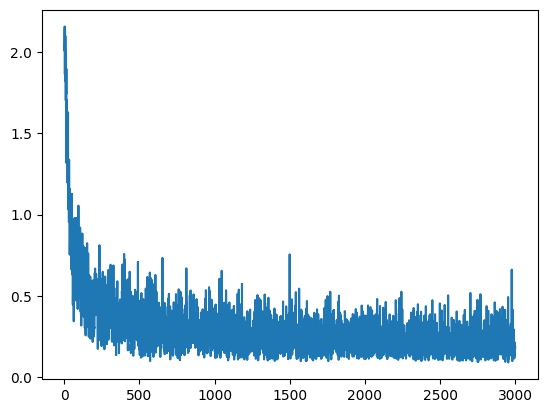

In [14]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

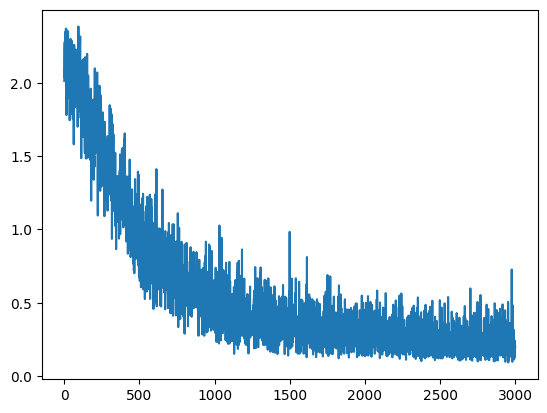

In [15]:
import matplotlib.pyplot as plt
plt.plot(ema_model_losses)
plt.show

Тут мы подглядели в репозиторий https://github.com/atong01/conditional-flow-matching/tree/main и попробовали использовать их алгоритм сэмплирования. Во-первых, он предлагал несколько тактик сэмплирования, во-вторых, в нём удобно реализовано логирование. Оказалось, что этот алгоритм работает не всегда и наличие результата зависит от количества сэмплов

In [ ]:
!pip install torchdiffeq

In [ ]:
import torchdiffeq
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
USE_TORCH_DIFFEQ = True
generated_class_list = torch.tensor([0,1,0,0,0,0,0,0,0,0], device='cuda').repeat(15)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: ema.ema_model.forward(x,t, generated_class_list),
            torch.randn(15, 3, 32, 32, device='cuda'),
            torch.linspace(0, 1, 2, device='cuda'),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
pictures = traj[-1, :15].view([-1, 3, 32, 32])
# для времен, когда мы нормировали картинки
#pictures = pictures*0.5+0.5
grid = make_grid(
  pictures, padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [ ]:
# сохраняли веса для дообучения
torch.save(net.state_dict(), 'model_weights.pth')

Адаптировали алгоритм сэмплирования из 2ой домашки

In [24]:
from torchvision.utils import make_grid

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def visualize_batch(img_vis, title='Семплы', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()

def solve_euler(f, x_0, class_labels, n_steps_vis=10, n_steps_per_vis=10, eps=1e-3, return_history=True):
    if return_history:
        history = [x_0[None, ...]]

    n_steps = n_steps_vis * n_steps_per_vis
    t_values = torch.linspace(eps, 1.0 - eps, n_steps + 1, device='cuda') #, device='cuda')
    t_diffs = t_values[1:] - t_values[:-1]
    x_t = x_0

    with torch.no_grad(): #
        for step_vis in range(n_steps_vis):
            for inner_step in range(n_steps_per_vis):
                step = step_vis * n_steps_per_vis + inner_step
                t = torch.ones(x_t.shape[0], device='cuda') * t_values[step]
                h = t_diffs[step]
                x_t = x_t + h * f(x_t, t[:, None], class_labels=class_labels)
            if return_history:
                history.append(x_t[None, ...])

    if return_history:
        return x_t, torch.cat(history, dim=0)

    return x_t



def visualize_model_samples(model, params=[], labels_usage='dummy', class_labels=None, title='Семплы из модели', num_sampled=1, **model_kwargs):
    noise = torch.randn(num_sampled, 3, 32, 32, device='cuda') #, device=params['device'])
    class_labels = torch.randint(low=0, high=10, size=(num_sampled,), device='cuda') # , device=params['device'])
    class_labels = (class_labels[:, None] == torch.arange(10, device='cuda')[None, :]).float() # , device=params['device']
    print(class_labels)

    out, trajectory = solve_euler(model, noise, class_labels=class_labels, **model_kwargs)
    visualize_batch(out.detach().cpu(), title=title)

Сэмплы у нас были не очень хорошие. Опять же, исходное разрешение датасета такое, что даже человеку не всегда понятно, что изображено на исходной картинке, поэтому результаты генерации были обманчивы

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')


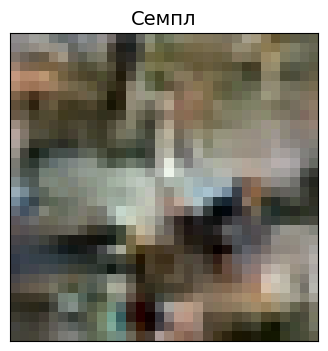

In [36]:
visualize_model_samples(ema.ema_model, labels_usage='dummy', title='Семпл')#, title='Семплы из модели, обусловленной на dummy класс')

In [26]:
classes

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Алгоритм Optimal Transport - Conditional Flow Matching

In [ ]:
!pip install pot

In [ ]:
# OT-CFM
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_
import ot as pot
from functools import partial
batch_size = 32

def training_loop_ot(net, opt, dataloader, num_epochs=10000):
    net.train()
    pbar = tqdm(range(num_epochs))
    for i in pbar:
        opt.zero_grad()
        data = next(iter(dataloader))
        x1 = data[0].to('cuda')
        y = data[1].to('cpu')
        x0 = torch.randn_like(x1).to('cuda')

        # эту часть взяли из репозитория https://github.com/atong01/conditional-flow-matching/tree/main
        ot_fn = partial(pot.sinkhorn, reg=0.05)

        a, b = pot.unif(x0.shape[0]), pot.unif(x1.shape[0])
        x0 = x0.reshape(x0.shape[0], -1)
        x1 = x1.reshape(x1.shape[0], -1)
        M = torch.cdist(x0, x1) ** 2
        p = ot_fn(a, b, M.detach().cpu().numpy())
        if np.abs(p.sum()) < 1e-8:
            p = np.ones_like(p) / p.size

        pi = p
        p = p.flatten()
        p = p / p.sum()
        choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
        i, j = np.divmod(choices, pi.shape[1])
        x0 = x0[i]
        x1 = x1[j]
        y1 = y[j]

        x1=x1.reshape(32,3,32,32)
        x0=x0.reshape(32,3,32,32)

        #batch_size = x0.shape[0]
        t = torch.rand(x0.shape[0], device=x0.device)
        t = t.reshape(-1, *([1] * (x0.dim() - 1)))
     #  print(t)
        x_t = x0 + (x1 - x0) * t
        new_labels = torch.eye(10)[y1]
     #   print(x_t.shape, t.shape, y1.shape)
        f_x_t = net(x_t, t, class_labels=new_labels.to('cuda'))
        loss = ((f_x_t - (x1 - x0)) ** 2).mean()

        loss.backward()
        clip_grad_norm_(net.parameters(), max_norm=1.0)
        opt.step()
        pbar.set_description(f'Loss: {loss.item()}')
        if loss.item() > 2:
          print("!!!!!")
        history_ot.append(loss.item())

In [ ]:
history_ot=[]
training_loop_ot(net, opt, dataloader, num_epochs=250)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_ot)
plt.show

MSE Loss для OT CFM
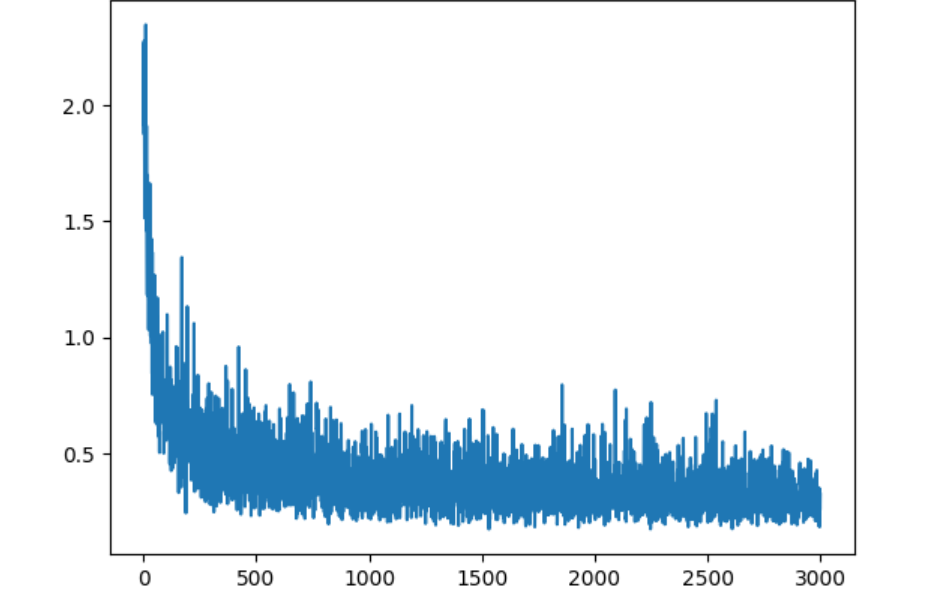